In [1]:
#@title INIT - Imports
import gc
import gym
import math as mt
import scipy as sp
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.font_manager import FontProperties
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import networkx as nx
import pickle as pkl
import itertools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
!pip3 install pycolormap_2d
from pycolormap_2d import ColorMap2DBremm, ColorMap2DZiegler
import time
import os #for creating directories
from scipy.optimize import curve_fit
from typing import Union, Optional
!pip3 install umap-learn
import umap.umap_ as umap

#for jupyter widget progress bar
from google.colab import output
output.enable_custom_widget_manager()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
#this is set for the printing of Q-matrices via console
torch.set_printoptions(precision=3, sci_mode=False, linewidth=100)

from tqdm.auto import tqdm, trange


#Uncomment if GPU is to be used - right now use CPU, as we have very small networks and for them, CPU is actually faster
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")

#suppress scientific notation in printouts
np.set_printoptions(suppress=True)

In [2]:
#@title INIT - Guideline/dictionary for the changeable parameters

#qmat_read_code
"training_4x4" # Fig. 5 -> the training Q-matrices -> all tasks in all 4x4 grid-worlds with 0 or 1 wall states
"test_4x4" # Fig. 6 -> the test Q-matrices -> all tasks in all 4x4 grid-worlds with 2 wall states


#language_code
"nonlinear_nostudent_language0" # Fig. 2a -> ReLU activations on the autoencoder (and student), but NO student feedback
"nonlinear_goallocs0_zeta5_language2" # Fig. 2b,c -> ReLU activations on both autoencoder and student, WITH student feedback
"linear_ae_nostudent_language0" # Fig. S1a -> linear activations on the autoencoder (and student), but NO student feedback
"linear_both_zeta5_language0" # Fig. S1b,c -> linear activations on the autoencoder and student, WITH student feedback
"linear_ae_zeta5_language0" # Fig. S2a,b -> linear activations on the autoencoder, ReLU activations on the student, WITH student feedback

"linear_ae_nostudent_language{i}" # i in range(6) -> linear activations on the autoencoder (and student), but NO student feedback
"nonlinear_frozen_feedback_goallocs{m}_zeta5_language{i}" # i in range(5), m in range(7) -> student trained on a fixed language created WITH feedback (on different goal location groups)
"nonlinear_frozen_nofeedback_goallocs{m}_zeta5_language{i}" # i in range(5), m in range(7) -> student trained on a fixed language created WITHOUT feedback (on different goal location groups)
"nonlinear_goallocs{m}_zeta5_language{i}" # i in range(25), m in range(7) -> ReLU activations on both autoencoder and student, student and language trained together WITH student feedback
"nonlinear_nostudent_language{i}" #i in range(5) -> ReLU activations on the autoencoder (and student), but NO student feedback
"nonlinear_zeta{k}_language{i}" #i in range(3), k in [1,2,5,10] -> ReLU activations on both autoencoder and student, student and language trained together WITH student feedback, different values of zeta


#folders_goalloc_plots
[f"nonlinear_goallocs{i}_zeta5_factor1" for i in range(7)] # Fig. 3e,f,g,h -> regular messages, student and language trained together -> language_nr_goalloc_plots=5, chuck_out=False
[f"studentQfeedback_goallocs{i}_zeta5_factor1" for i in range(7)] # Fig. 4b,c,d,e -> messages from student matrices, student and language trained together -> language_nr_goalloc_plots=25, chuck_out=True
[f"nonlinear_frozen_goallocs{i}_zeta5_factor1" for i in range(7)] # Fig. S3 -> regular messages, student trained on fixed languages created WITHOUT feedback -> language_nr_goalloc_plots=5, chuck_out=False
[f"nonlinear_frozen2_goallocs{i}_zeta5_factor1" for i in range(7)] # Fig. S4 -> regular messages, student trained on fixed languages created WITH feedback -> language_nr_goalloc_plots=5, chuck_out=False


#language_code_closingloop
"nonlinear_goallocs0_zeta5_language0" # Fig. 4a and Fig. S6a,b

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'nonlinear_goallocs0_zeta5_language0'

In [3]:
#@title INIT - Changeable parameters

#location of the file folder
file_loc: str="/content/drive/MyDrive/masterthesis/"


#generate new Q-matrices with RL teacher networks or load them from a file
qmat_read_code: str="training_4x4" #file for loading Q-matrices from a file

#generate a new "language" with the autoencoder, or load it from a file
language_code: str="nonlinear_goallocs0_zeta5_language2" #code to get autoencoder parameters from a file

#message space PCA (and t-SNE) plots
do_tsne_message_plots=True #do t-SNE plots as well?
tsne_perplexity_all=10 #10 in Fig. S9, 50 in Fig. S10
tsne_perplexity_single=2 #2 in Fig. S9, 5 in Fig. S10
do_umap_message_plots=True #do UMAP plots as well?
umap_neighbors_all=10 #10 in Fig. S11, 50 in Fig. S12
umap_neighbors_single=2 #2 in Fig. S11, 5 in Fig. S12
plot_worlds=range(16) #all these worlds are included in the main plot - can not be more than 20 at the moment due to the color cycler -> range(16) are all training worlds
plot_worlds_single=[6] #create individual plots for all of the worlds included in this list

#autoencoder loss plots
#Fig. 3a,b,c,d -> zeta_lossplot=5
#Fig. S5 -> zeta_lossplots=1,2,5,10
zeta_lossplot=10 #change the hyperparameter zeta here to see the loss plots for different values (1,2,5,10)

#plot the student performances for different groups of goal locations trained
folders_goalloc_plots=[f"nonlinear_frozen2_goallocs{i}_zeta5_factor1" for i in range(7)] #the goal groups 0-6 have the same order as in the plots in the paper
language_nr_goalloc_plots=5 #how many languages per group of goal locations?
chuck_out=True #chuck out languages in which the performance of the informed student is below the misinformed student or below the random walker?

#closing the loop
language_code_closingloop="nonlinear_goallocs0_zeta5_language4" #language code for which language we should plot the results of "closing the loop"

#topographic similarity analysis
norm_topo=2
n_bins_topo=20
#entropy analysis (binning method)
H_binlist=np.linspace(8,62,10).astype(int)


In [4]:
#@title INIT - Fixed parameters

grid_dim: int=4 #side length of the square gridworld
n_actions: int=4 #how many actions are possible in each state
student_init: int=0 #initial state where the student is always starting - states are indexed as follows (example for the 4x4 mazes):
# 12 13 14 15
#  8  9 10 11
#  4  5  6  7
#  0  1  2  3
lava: bool=False #do we use lava states - i.e. accessible wall states - (True) or wall states (False)? (we now always use "False")
data_shape: 'tuple[int,int,int]'=(n_actions,grid_dim,grid_dim) #Q matrix shape


#rewards in the gridworld
step_reward: float=-0.1 #for taking a step
goal_reward: float=2. #for reaching the goal
wall_reward: float=-0.5 #for bumping into a wall


#teacher network parameters for learning Q-matrices
qmat_gen: bool=False #generate new Q-matrices?
accuracy=20 #how accurate do the final Q-matrices have to be compared to the "perfect" ones, which can be calculated by table lookup? (in terms of vector 1-norm)
max_attempts=3 #limit the attempts we give the teacher to calculate a Q-matrix that lies within the accuracy bound
wall_state_dict={0:[]} #only in case of new Q-matrix generation, we index all the mazes, and calculate a Q-matrix for every possible goal location in each maze
gamma_bellman: float=0.99 #temporal discount factor used in the Bellman equation of the teacher networks
L: int=50 #short term memory size of teacher learning Q-matrices
lr_teacher: float=3e-3 #learning rate for the teachers


#autoencoder network parameters for generating the language
language_gen: bool=False #generate a new language?
K: int=5 #length of the message vectors
gamma_sparse=1/20*mt.sqrt(grid_dim**2*n_actions/K) #how important is the sparsity loss compared to reconstruction loss
                                                   #we have the square root here to compare individual entries (in both cases take the overall 2-norm)
kappa=1/500 #balances how much focus is put on regularization, compared to the probability of finding the goal (for the student)
learning_rate_autoenc=5e-4 #learning rate of the autoencoder-student network
language_number_autoenc=5 #how many different languages to create (for statistics, other parameters stay the same)
training_epochs=1000 #number of training epochs for the autoencoder

#message plots
nonlinear_ae_plots=True if language_code.__contains__("nonlinear") else False #does the autoencoder have nonlinear activations?
nonlinear_std_plots=True if (language_code.__contains__("nonlinear") or language_code.__contains__("linear_ae")) else False #does the student have nonlinear activations?
save_message_plots=False #save the plots?

#evaluate the student agent's performance (calculate goal finding success rates)
student_evaluate: bool=False
save_rates: bool=False #save the goal finding success rates

#autoencoder loss plots
epskip=50 #skip first few epochs to have narrower loss range and see details better
save_autoenc_lossplots=False #save the autoencoder plots?

#plot the student performances for different amounts of steps allowed for the students ("stepfactors")
folder_stepfactor_plots="nonlinear_goallocs0_zeta5_factor1"
language_nr_stepfactor_plots=5
stepfactor_list_plots=[1,1.5,2,2.5,3,3.5,4]
rdrates_list_plots=[]
save_stepfactor_plots=False #save the plots?

#plot the student performances for different groups of goal locations trained
goal_groups_plots=np.array([0,1,2,3,4,5,6]) #include those groups in the plot
stepfactor_goalloc_plots=2
rdrate_goalloc_plots=0.25
save_goalloc_plots=False #save the plots?

#closing the loop
closingloop_nonlinear_ae=True #do the neurons in the autoencoder have nonlinear activations?
closingloop_nonlinear_std=True #do the neurons in the student have nonlinear activations?
save_closingloop_plots=False #save the plots?

In [5]:
#@title FUNCTIONS - Helper functions

def set_seed(seed: Optional[int]=None, seed_torch: bool=True):
    {'''
        Function that controls randomness by setting a random seed
        ---
        INPUT:
        seed: the random state
        seed_torch: If `True` sets the random seed for pytorch tensors, so pytorch module
                    must be imported
        ---
        OUTPUT:
        nothing, write into file
      '''}
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


def write_dict_into_pkl(dictionary: dict,pkl_file: str):
    {'''
        Write a dictionary into a .txt file
        ---
        INPUT:
        dictionary: the dictionary
        txt_file: location of the .txt file we are writing into
        ---
        OUTPUT:
        nothing, write into file
    '''}
    with open(pkl_file,"wb") as f:
        pkl.dump(dictionary, f)
    f.close()


def read_dict_from_pkl(pkl_file: str)->dict:
    {'''
        Read a dictionary from a .txt file
        ---
        INPUT:
        txt_file: location of the .txt file we are reading from
        ---
        OUTPUT:
        the dictionary we get from the file
    '''}
    pickle_off = open(pkl_file, 'rb')
    dictionary = pkl.load(pickle_off)
    pickle_off.close()
    return dictionary


def moving_average(a: Union[list, np.ndarray], n: int) ->np.ndarray:
    {'''
        computes the moving average of an array
        ---
        INPUT
        a - the array
        n - width of the moving window in steps
        ---
        OUTPUT
        the moving average array
    '''}
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def linfunc(x: Union[float,int],m: Union[float,int],b: Union[float,int])->Union[float,int]:
    '''
    A simple linear function
    ---
    INPUT
    x - input x-value
    m - linear function slope parameter
    b - linear function offset parameter
    ---
    OUTPUT
    y=m*x+b
    '''
    return m*x+b

def tanhfunc(x: Union[float,int],a: Union[float,int], c: Union[float,int], b: Union[float,int])->Union[float,int]:
    '''
    Hyperbolic tangent function with scaling parameters
    ---
    INPUT
    x - input x-value
    a - parameter
    b - scaling parameter (y-axis)
    ---
    OUTPUT
    y=tanh(a*x)
    '''
    return b*np.tanh(a*(x-1)**c)

def logfunc(x: Union[float,int],a: Union[float,int], c: Union[float,int], b: Union[float,int])->Union[float,int]:
    '''
    Logistic function with scaling parameters
    ---
    INPUT
    x - input x-value
    a - parameter
    b - scaling parameter (y-axis)
    ---
    OUTPUT
    y=(2*b)/(1+e^(-a*x))-b
    '''
    return 2*b/(1+np.exp(-a*(x-1)**c))-b

def hypfunc(x: Union[float,int],a: Union[float,int], c: Union[float,int], b: Union[float,int])->Union[float,int]:
    '''
    Hyperbola with scaling parameter
    ---
    INPUT
    x - input x-value
    a - parameter
    c - parameter
    b - scaling parameter (y-axis)
    ---
    OUTPUT
    y=1/(a*x)+b
    '''
    return -1/(a*(x-1)**c)+b

def arctanfunc(x: Union[float,int],a: Union[float,int], c: Union[float,int], b: Union[float,int])->Union[float,int]:
    '''
    Hyperbola with scaling parameter
    ---
    INPUT
    x - input x-value
    a - parameter
    c - parameter
    b - scaling parameter (y-axis)
    ---
    OUTPUT
    y=1/(a*x)+b
    '''
    return (2/mt.pi)*b*np.arctan(a*(x-1)**c)

def constfunc(x, a):
    return 0*x+a

def flattening_spotter(data: Union[list, np.ndarray], fit_size: int, certainty: float) ->int:
    '''
    This function finds the point when a series of data points (data) has converged/levelled/flattened
    It assumes that by the end of the data series (minus fit_size data points), convergence has definitely happened!!
    ---
    INPUT
    data - list/array of numbers. the data series
    fit_size - the number of data points taken into account for each linear fit
    certainty - if the slope plus this number of standard deviations is below zero, we stop and declare that the data is no longer level
    ---
    OUTPUT
    learned_index - the first index where the data series has become level
    '''

    learned_index: int=0
    for l in range(len(data)-fit_size,-1,-1):
        popt, pcov=curve_fit(linfunc,range(l,l+fit_size,1),data[l:l+fit_size]) #fit linear function
        if popt[0]<1e-3 and popt[0]+certainty*mt.sqrt(pcov[0,0])<1e-3: #if the slope is negative with given certainty, we stop
            learned_index=l+1 #+1 step, don't include the data that is not level anymore
            break
    return learned_index


def to_interval(x: float,left: float,right: float)->float:
    '''
    Fits data point into an interval (left outliers to left boundary, right outliers to right boundary)
    ---
    INPUT
    x - the data point
    left - left interval boundary
    right - right interval boundary
    ---
    OUTPUT
    y - the position of x in the interval
    '''

    return min(right,max(x,left))


def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def get_message_list(language_code, q_matrix_dict):
    #create the message list corresponding to a certain language
    #load stored autoencoder network parameters
    autoencoder = ConvAutoEncoder(data_shape, K, nonlinear_ae_plots, nonlinear_std_plots).to(device)
    autoencoder.load_state_dict(torch.load(file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{language_code}.pt"))
    autoencoder.eval()
    #create a message dictionary, with indices corresponding to the task indices
    message_dict={}
    for task_index,q_matrix in q_matrix_dict.items():
        q_matrix=torch.unsqueeze(q_matrix,0) #need this because the autoencoder always expects batches of inputs!
        message=autoencoder.encode(q_matrix)[0]
        message_dict[task_index]=torch.flatten(message).detach().numpy()

    return list(message_dict.values()), autoencoder


In [6]:
#@title FUNCTIONS - Gridworld class and state representation transformations

class SquareGridworld():
    """
    the class for the gridworlds

    n**2 states (n-by-n gridworld) -> n is the grid dimension

    The mapping from state to the grid is as follows:
    n(n-1)  n(n-1)+1  ...  n^2-1
    ...     ...       ...  ...
    n       n+1       ...  2n-1
    0       1         ...  n-1

    Actions 0, 1, 2, 3 correspond to right, up, left, down (always exactly one step)

    -Agent starts at the init_state
    -Landing in the goal_state gets a reward of goal_reward and ends the episode
    -Bumping into wall states or the map border incurs a reward of wall_reward
    -In case of lava=False, the agent bounces back from walls, while in case of lava=True wall states are accessible (the outside boundary can never be crossed)
    -Each step additionally incurs a reward of step_reward
    """
    def __init__(self,init_state: int,goal_state: int,wall_states: 'list[int]', lava: bool):

        self.init_state: int=init_state
        self.goal_state: int=goal_state
        self.wall_states: 'list[int]'=wall_states
        self.n_states: int = grid_dim**2
        self.lava: bool = lava


    def get_outcome(self, state: int, action: int)-> 'tuple[Optional[int], float]':
        '''
        given a state and an action, this returns the next state and the immediate reward for the action
        ---
        INPUT
        state: the state the agent is in
        action: the action taken
        ---
        OUTPUT
        next_state - the next state
        reward - the reward for the action taken
        '''

        #if the goal is reached, we get the goal_reward and the episode ends
        if state == self.goal_state:
                reward: float = goal_reward
                next_state = None #terminates the episode
                return next_state, reward

        #get the next state before taking into account walls or outside boundary
        next_state_dict={0:state+1, 1:state+grid_dim, 2:state-1, 3:state-grid_dim}
        #for all actions, this dictionary stores a boolean indicating whether we cross the map border executing this action in our current state
        cross_boundary_dict={0:state % grid_dim == grid_dim-1, 1:state >= grid_dim*(grid_dim-1), 2:state % grid_dim ==0, 3:state<grid_dim}

        #case that we have lava states that the agent can walk through with large negative reward
        if self.lava:
            reward=step_reward
            next_state=next_state_dict[action]
            #bounce back from map border
            if cross_boundary_dict[action]:
                reward+=wall_reward
                next_state=state
            #entering or exiting a lava state gives negative reward, but we do not bounce back
            elif next_state in self.wall_states or state in self.wall_states:
                reward+=wall_reward

        #case that we have wall states that the agent bounces back from
        else:
            reward=step_reward
            next_state=next_state_dict[action]
            #bounce back from a wall or the map border?
            if next_state in self.wall_states or cross_boundary_dict[action]:
                next_state=state #bounce back
                reward+=wall_reward


        return int(next_state) if next_state is not None else None, reward


    def get_outcomes(self) -> 'dict[ tuple[int,float] , tuple[Optional[int], float] ]':
        '''
        returns a dictionary where for every possible combination of state and action we get the next state and
        corresponding immediate reward
        ---
        OUTPUT
        outcomes - the dictionary keyed by state-action combo, whose values are the next states and rewards
        '''
        outcomes = {(s, a): self.get_outcome(s,a) for s in range(self.n_states) for a in range(n_actions)}
        return outcomes



def state_int_to_tuple(state_int: Optional[int]) -> Optional[torch.tensor]:
    '''
    Gets state tuple representation (coordinates) from integer representation
    ---
    INPUT
    state_int - the state integer representation
    ---
    OUTPUT
    state - the state tuple representation
    '''
    if state_int==None:
        return None
    else:
        cval: float=(grid_dim-1)/2 #center (0,0) is in the middle of the grid
        sx,sy=state_int%grid_dim-cval, mt.floor(state_int/grid_dim)-cval
        state = torch.tensor([[sx,sy]],device=device)
        return state

def state_tuple_to_int(state: Optional[torch.tensor]) -> Optional[int]:
    '''
    Gets state integer representation from tuple representation (coordinates)
    ---
    INPUT
    state - the state tuple representation
    ---
    OUTPUT
    state_int - the state integer representation
    '''
    if state==None:
        return None
    else:
        sx,sy=state
        cval: float=(grid_dim-1)/2
        sx,sy=sx+cval,sy+cval
        state_int=int(sx.item()+grid_dim*sy.item())
        return state_int

def get_state_tensors(m_len: int) -> torch.tensor:
    '''
    Concatenate tensors representing particular states in the gridworld so that fewer network forwards are needed
    ---
    INPUT
    m_len - length of the message batch
    ---
    OUTPUT
    state_tensors - the concatenated state tensors
    '''
    state_tensors=torch.zeros(size=(grid_dim,grid_dim*m_len,2))
    for j in range(grid_dim):
        for i in range(grid_dim):
            s=i*grid_dim+j
            s_tup=state_int_to_tuple(s)[0]
            for b in range(m_len):
                state_tensors[j,i*m_len+b]=s_tup

    return state_tensors


In [7]:
#@title FUNCTIONS - Transition Memory class



Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    '''
    a class to store and replay previous transitions of states and actions done by the network
    like a memory
    '''

    def __init__(self, capacity: int):
        #Have short- and long-term memory to optimize exploration results
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int)->'list[Transition]':
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

In [8]:
#@title FUNCTIONS - DQN class

class DQN(nn.Module):
    '''
    Deep Q Network class
    '''

    def __init__(self, K: int, zero_init: bool = False):
        '''
        INPUT
        K: length of input message (zero for the teacher)
        zero_init: initialize all weights to zero?
        '''
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(2+K, 10, device=device) #input size is 2(gridworld coordinates)+length of message
        self.lin2=nn.Linear(10,20, device=device)
        self.lin3 = nn.Linear(20,20, device=device)
        self.lin4 = nn.Linear(20,n_actions, device=device)

        #Initialize all weights (and biases) to zero
        if zero_init:
            torch.nn.init.zeros_(self.lin1.weight)
            torch.nn.init.zeros_(self.lin1.bias)
            torch.nn.init.zeros_(self.lin2.weight)
            torch.nn.init.zeros_(self.lin2.bias)
            torch.nn.init.zeros_(self.lin3.weight)
            torch.nn.init.zeros_(self.lin3.bias)


    def forward(self, x:torch.tensor)->torch.tensor:
        '''
        forward pass of the network
        ---
        INPUT
        x - network input, i.e. combination of state and potentially message
        ---
        OUTPUT
        y - the four Q-values, i.e. torch.tensor([Q(s,0),Q(s,1),Q(s,2),Q(s,3)])
        '''
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x


class BiasLayer(nn.Module):
    '''
    Bias Layer (add bias to individual network nodes/filter positions)
    '''
    def __init__(self, shape: tuple):
        '''
        Initialise parameters of bias layer
        ---
        INPUT
        shape: Requisite shape of bias layer
        '''
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape, device=device)
        self.bias = nn.Parameter(init_bias, requires_grad=True)

    def forward(self, x: torch.tensor)->torch.tensor:
        '''
        Forward pass
        ---
        INPUT
        x: Input features
        ---
        OUTPUT
        y: Output of bias layer
        '''
        y=x+self.bias
        return y


In [9]:
#@title FUNCTIONS - Policies
def select_action_epsgreedy(agent: DQN,state:torch.tensor,message:torch.tensor,epsilon:float)->int:
    '''
    epsilon-greedy algorithm for action selection
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state - the state the agent is currently in (in coordinate representation)
    message - the message the agent has received
    epsilon - epsilon from the epsilon greedy algorithm
    ---
    OUTPUT
    The action to be taken (0:right, 1:up, 2:left, 3:down)
    '''
    if random.random() > epsilon:
        with torch.no_grad():
            input=torch.cat((state[0],message),0)
            return agent(input).argmax().item() #do forward pass and return optimal action found
    else:
        return random.choice(range(4)) #return random action



def select_action_optimism(agent: DQN,state_int:int,message:torch.tensor,alpha:float,sa_counts:'dict[tuple[int, int],int]'):
    '''
    optimism-in-face-of-uncertainty algorithm for action selection
    using the unchanged Q-values and no probabilities
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state_int - the state the agent is currently in (in integer representation)
    message - the message the agent has received
    alpha - constant for optimism in face of uncertainty algorithm
    sa_counts - counts how often each state-action combination has already been seen by the agent
    ---
    OUTPUT
    The action to be taken (0:right, 1:up, 2:left, 3:down)
    '''
    state=state_int_to_tuple(state_int)
    current_sa_counts=torch.tensor([sa_counts[(state_int, a)] for a in range(4)]).to(device) #pick out counts of current state
    with torch.no_grad():
        input=torch.cat((state[0],message),0)
        qvals=agent(input) #do forward pass
        qvals=qvals+alpha/torch.sqrt(current_sa_counts) #add current uncertainties
        return qvals.argmax().item() #return optimal action given uncertainties



def select_action_eps_trust(agent: DQN, state_int:int, probas_message_matrix:torch.tensor, softy:nn.Softmax, iota:float,
                            trust:float, current_ep:int, total_eps:int)->'tuple[torch.tensor, torch.tensor, int]':
    '''
    global trust parameter for teacher and epsilon greedy exploration
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state_int - the state the agent is currently in (in integer representation)
    probas_message_matrix - matrix of action probabilities according to the message
    softy - a softmax function
    iota - parameter to adjust student Q-values, so that softmax gives reasonable probabilities
    trust - tells how much the student trusts the teacher (between 0 and 1)
    current_ep - current episode number
    total_eps - total episode number (both parameters relevant for decaying epsilon in epsilon-greedy)
    ---
    OUTPUT
    probas_message - action probabilities in current state according to the message
    probas_student - action probabilities in current state according to the student's own learning
    action - next action that will be executed by the student
    '''
    state=state_int_to_tuple(state_int)
    with torch.no_grad():
        #1.message
        probas_message=probas_message_matrix[:,mt.floor(state_int/grid_dim),state_int%grid_dim] #filter out current state
        #2.student
        qvals_student=agent(state[0])
        qvals_student-=min(qvals_student)*torch.ones(n_actions).to(device)
        probas_student=softy(iota*qvals_student) #multiply by constant iota for suitable probabilities from Q-values
        #3.combination
        probas=trust*probas_message+(1-trust)*probas_student
        #4.randomness
        r=random.random()
        if r<0.4*(1-current_ep/total_eps)+0.4*(current_ep/total_eps): #decaying eps-greedy according to episode number
            action=random.choice([0,1,2,3])
        else:
            action=torch.argmax(probas).item()
    return probas_message, probas_student, action



def select_action_eps_trust_uninfo(agent: DQN, state_int:int, softy:nn.Softmax, iota:float, current_ep:int, total_eps:int)->'tuple[torch.tensor,int]':
    '''
    mirror image of above function, just without a message (i.e. without a teacher)
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state_int - the state the agent is currently in (in integer representation)
    softy - a softmax function
    iota - parameter to adjust student Q-values, so that softmax gives reasonable probabilities
    current_ep - current episode
    total_eps - total episode number (both parameters relevant for decaying epsilon in epsilon-greedy)
    ---
    OUTPUT
    probas_student - action probabilities in current state according to the student's own learning
    action - next action that will be executed by the student
    '''
    state=state_int_to_tuple(state_int)
    with torch.no_grad():
        #1.student
        qvals_student=agent(state[0])
        qvals_student-=min(qvals_student)*torch.ones(n_actions).to(device)
        probas=softy(iota*qvals_student) #multiply by constant iota for suitable probabilities from Q-values
        #2.randomness
        r=random.random()
        if r<0.4*(1-current_ep/total_eps)+0.4*(current_ep/total_eps): #decaying epsilon greedy according to episode number
            action=random.choice([0,1,2,3])
        else:
            action=torch.argmax(probas).item()
    return probas, action



def select_action_opt_trust(agent: DQN, state_int:int, probas_message_matrix: torch.tensor, softy:nn.Softmax, iota:float,
                            trust: float, alpha: float, sa_counts:'dict[tuple[int, int],int]')->'tuple[torch.tensor, torch.tensor, int]':
    '''
    global trust parameter for teacher and optimism in face of uncertainty exploration
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state_int - the state the agent is currently in (in integer representation)
    probas_message_matrix - matrix of action probabilities according to the message
    softy - a softmax function
    iota - parameter to adjust student Q-values so that softmax gives reasonable probabilities
    trust - tells how much the student trusts the teacher (between 0 and 1)
    alpha - constant for optimism in face of uncertainty algorithm
    sa_counts - counts how often each state-action combination has already been seen by the agent
    ---
    OUTPUT
    probas_message - action probabilities in current state according to the message
    probas_student - action probabilities in current state according to the student's own learning
    action - next action that will be executed by the student
    '''
    state=state_int_to_tuple(state_int)
    current_sa_counts=torch.tensor([sa_counts[(state_int, a)] for a in range(4)]).to(device) #pick out counts of current state
    with torch.no_grad():
        #1.message
        probas_message=probas_message_matrix[:,mt.floor(state_int/grid_dim),state_int%grid_dim] #filter out current state
        #2.student
        qvals_student=agent(state[0])
        qvals_student-=min(qvals_student)*torch.ones(n_actions).to(device)
        probas_student=softy(iota*qvals_student) #multiply by constant iota for suitable probabilities from Q-values
        #3.combination including optimism in the face of uncertainty
        probas=trust*probas_message+(1-trust)*(probas_student+alpha/(current_sa_counts+1))
        #argmax
        action=torch.argmax(probas).item()
    return probas_message, probas_student, action



def select_action_opt_trust_uninfo(agent: DQN, state_int:int, softy:nn.Softmax, iota:float, alpha:float, sa_counts:'dict[tuple[int, int],int]')->int:
    '''
    mirror image of above function, just without a message (i.e. without a teacher)
    ---
    INPUT
    agent - the deep-Q-network representing the agent exploring the world
    state_int - the state the agent is currently in (in integer representation)
    softy - a softmax function
    iota - parameter to adjust student Q-values so that softmax gives reasonable probabilities
    alpha - constant for optimism in face of uncertainty algorithm
    sa_counts - counts how often each state-action combination has already been seen by the agent
    ---
    OUTPUT
    probas - action probabilities in state s according to the student's own learning
    action - next action that will be executed by the student
    '''
    state=state_int_to_tuple(state_int)
    current_sa_counts=torch.tensor([sa_counts[(state_int, a)] for a in range(4)]).to(device) #pick out counts of current state
    with torch.no_grad():
        #1.student
        qvals_student=agent(state[0])
        qvals_student-=min(qvals_student)*torch.ones(n_actions).to(device)
        probas=softy(iota*qvals_student) #multiply by constant iota for suitable probabilities from Q-values
        #2.optimism in face of uncertainty
        probas+=alpha/(current_sa_counts+1)
        #argmax
        action=torch.argmax(probas).item()
    return probas, action

In [10]:
#@title FUNCTIONS - Optimizer for DQN
'''
Optimization function for the DQN
'''

def optimize_dqn(network: DQN,optimizer: torch.optim, memory: torch.tensor, batches: 'tuple[torch.tensor, torch.tensor]', goal_found: bool, loss_norm) -> float:
    '''
    Do one optimizer step of the (teacher) DQN
    ---
    INPUT
    network: the DQN we are optimizing
    optimizer: the opimizer for the DQN
    memory: tensor containing the indices of all transitions that are used for this training step (there can be multiple occurences of single indices)
            -> those indices comprise the short- and long-term memory
    batches: contains a concatenation of a) the batch of all states and b) the batch of nextstates (for all possible transitions)
             further it contains the batch of rewards (for all possible transitions)
    goal_found: Indicates if the goal has been found yet
    loss_norm: norm for the loss function (i.e. nn.MSELoss)
    ---
    OUTPUT:
    loss: loss in this optimizer step
    '''

    states_nextstates, rewards = batches

    #Compute all the Q-values for all states, all nextstates and all 4 actions each
    qvalues=network(states_nextstates)
    state_action_values = torch.flatten(qvalues[:int(len(rewards)/4)])
    # Compute max_a' Q(s_{t+1},a') for all next states
    next_state_values = qvalues[int(len(rewards)/4):].max(dim=1,keepdim=True).values

    # Compute the expected Q values
    expected_state_action_values = torch.flatten(gamma_bellman*next_state_values + rewards) #Bellman


    #get the occurences of each transition, square root is necessary for MSELoss
    trans_factors=torch.sqrt(torch.bincount(memory, minlength=len(next_state_values)))
    #train all 4 goal state values (for the 4 actions) only if the goal has been found
    if goal_found:
        expected_state_action_values[-4:]=2.
        trans_factors[-4:]=mt.sqrt(2) #put every goal action twice (long- and short-term memory)
        # Compute loss using the Bellman equation and MSE norm (if this is to change, have to adjust the square root above)
        loss = 1/mt.sqrt(len(memory)+8)*loss_norm(state_action_values*trans_factors, expected_state_action_values*trans_factors) #+8 because of 4 goal actions two times
    if not goal_found:
        expected_state_action_values[-4:]=0.
        state_action_values[-4:]=0.
        # Compute loss using the Bellman equation and MSE norm (if this is to change, have to adjust the square root above)
        loss = 1/mt.sqrt(len(memory))*loss_norm(state_action_values*trans_factors, expected_state_action_values*trans_factors)


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    '''
    #restricting parameter gradients to lie in the interval [-1,1]
    for param in network.parameters():
        param.grad.data.clamp_(-1, 1)
    '''

    optimizer.step()
    return loss.item()




def transition_memories(init_state:int, goal_state:int, wall_states:'list[int]')->'tuple[ dict[tuple[int,int],int], tuple[torch.tensor, torch.tensor] ]':
    '''
    create practical memory for transitions that allows for savings in Q-network training
    when learning the task
    ---
    INPUT
    init_state, goal_state, wall_states: specifications of the task
    ---
    OUTPUT
    transition_index_dict: dictionary taking as input a state-action combination and giving out the index belonging to this particular transition
    batches_list: list containing two tensor, firstly the concatenated states and next_states and secondly the concatenated rewards.
                  this complicated format makes computations faster.
    '''
    #initialize environment
    env = SquareGridworld(init_state,goal_state,wall_states, lava)
    outcomes=env.get_outcomes()

    transition_memory = ReplayMemory(capacity=n_actions*grid_dim**2)
    transition_index_dict={} #each transition gets an index
    #create the transition batches according to the world setup
    i=0
    for s_int in range(grid_dim**2):
        if s_int in wall_states or s_int==goal_state:
            continue
        s=state_int_to_tuple(s_int)
        for a in range(n_actions):
            transition_index_dict[(s_int,a)]=i
            i+=1
            ns_int, r = outcomes[s_int,a]
            ns=state_int_to_tuple(ns_int)
            transition_memory.push(s, torch.tensor([[a]], device=device), ns, torch.tensor([[r]], device=device))
    #add the goal state transitions at the end
    gs=state_int_to_tuple(goal_state)
    for a in range(n_actions):
        transition_memory.push(gs, torch.tensor([[a]], device=device), gs, torch.tensor([[2.]], device=device))
        transition_index_dict[(goal_state,a)]=i
        i+=1

    transitions = transition_memory.memory
    #create a big transition
    batch = Transition(*zip(*transitions))
    #and now the batches to train on for the network
    nextstates=torch.cat(batch.next_state)
    rewards=torch.cat(batch.reward)


    #second memory for only the states (don't need to run all of them through the network four times, but only one time)
    transition_memory = ReplayMemory(capacity=n_actions*grid_dim**2)
    for s_int in range(grid_dim**2):
        if s_int in wall_states or s_int==goal_state:
            continue
        s=state_int_to_tuple(s_int)
        transition_memory.push(s, torch.tensor([[0]], device=device), s, torch.tensor([[0.]], device=device))
    #add the goal state transitions at the end
    gs=state_int_to_tuple(goal_state)
    transition_memory.push(gs, torch.tensor([[0]], device=device), gs, torch.tensor([[0.]], device=device))

    transitions = transition_memory.memory
    #create a big transition
    batch = Transition(*zip(*transitions))
    states=torch.cat(batch.state)
    batches_list=[torch.cat([states, nextstates]), rewards]

    return transition_index_dict, batches_list

In [11]:
#@title FUNCTIONS - Plots of Q-matrices and probability matrices (from Q matrices)

def q_probabilities_plotter(Q: torch.tensor, init_state:int, goal_state:int, wall_states:'list[int]', steps:int, title: str):
    '''
    Plot the probabilites of state occupancy after a certain number of steps in a grid plot
    The initial state is marked with green text color, the final state with gold text color
    ---
    INPUT
    Q: the q-matrix to be used for probability calculation
    init_state, goal_state, wall_states: properties of the gridworld
    steps: number of steps for the agent after which the probabilites are calculated
    title: title for the plot
    ---
    OUTPUT
    Nothing except the plot
    '''

    cmap=plt.get_cmap("binary")
    softy=nn.Softmax(dim=0)
    #first build the network architecture
    env = SquareGridworld(init_state,goal_state,wall_states, lava)
    outcomes = env.get_outcomes()
    #dictionary to retrieve next state and reward given current (s,a)
    next_states_dict={s:[outcomes[s,a][0] for a in range(n_actions)]  for s in range(grid_dim**2)}
    matrix_big=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix
    #get action probabilities as softmax of the Q-values
    action_probas=softy(Q)
    for s in range(grid_dim**2):
        if s!=goal_state:
            for i,ns in enumerate(next_states_dict[s]):
                matrix_big[ns,s]+=action_probas[i,mt.floor(s/grid_dim),s%grid_dim] #need to have the "+=" here because there can be multiple identical transitions, e.g. for corner states
        else:
            matrix_big[s,s]=1
    #initialize probabilities
    probas=torch.zeros(grid_dim**2, device=device)
    probas[init_state]=1
    #Apply the transition matrix to the initial probability distribution for each allowed step to get the final probability distribution
    for _ in range(steps):
        probas=matrix_big@probas

    xydict={s:(grid_dim-1-mt.floor(s/grid_dim), s%grid_dim) for s in range(grid_dim**2)}
    #Create 2D lists for state probabilites and state colors
    state_probas=np.zeros(shape=(grid_dim,grid_dim))
    state_colors=np.zeros(shape=(grid_dim,grid_dim))
    state_probas=[list(arr) for arr in state_colors]
    state_colors=[list(arr) for arr in state_colors]
    #Insert probabilites and colors at the correct positions (so that state 0 is bottom left and state grid_dim**2-1 is top right)
    for s in range(grid_dim**2):
        x,y=xydict[s]
        if s in wall_states:
            state_probas[x][y]=f"0%"
            state_colors[x][y]=cmap(1-probas[s].item())
        else:
            state_probas[x][y]=f"{round(100*probas[s].item(),2)}%"
            state_colors[x][y]=cmap(0.75*(1-probas[s].item()))


    #Now plot as 2D plot with probabilities and state numbers
    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table=ax.table(cellText=state_probas, cellColours=state_colors, loc='center', colWidths=[0.2]*grid_dim, cellLoc='center')
    #some tweaking of font and text color (initial state green, goal state gold)
    table._cells[xydict[init_state]]._text.set_color('darkgreen')
    table._cells[xydict[goal_state]]._text.set_color('goldenrod')
    table.scale(0.72,4)
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(fontproperties=FontProperties(size=35))
    fig.tight_layout()
    plt.title(title)
    plt.show()



def q_arrows_plotter(Q:torch.tensor, init_state: int, goal_state:int, wall_states:'list[int]', bad_trust_states: 'list[int]',
                     good_trust_states: 'list[int]', title: str, save_loc: str, save: bool):
    '''
    Plot the probabilites of state transitions as arrows in a grid plot
    The initial state is marked with green color, the final state with gold color
    ---
    INPUT
    Q: the q-matrix to be used for probability calculation
    init_state, goal_state, wall_states:  properties of the gridworld
    bad_trust_states/good_trust_states: states in which the trust was bad/good
    title: title for the plot
    save_loc: saving location for the plot.
    save: True if we should save the figure, False otherwise
    ---
    OUTPUT
    Nothing except the plot
    '''
    plot_dim=grid_dim+2 #outside walls on each side mean the dimension is increased by 2
    #change wall states to incorporate outside states
    outer_wall_states=[i for i in range(plot_dim**2) if i<plot_dim or i%plot_dim in [plot_dim-1,0] or i>plot_dim*(plot_dim-1)]
    outer_bt_states, outer_gt_states= [],[]
    for w in wall_states:
        w1,w2=w%grid_dim, mt.floor(w/grid_dim)
        outer_wall_states+=[plot_dim*w2+w1+plot_dim+1]
    wall_states=outer_wall_states
    i1,i2=init_state%grid_dim, mt.floor(init_state/grid_dim)
    init_state=plot_dim*i2+i1+plot_dim+1
    g1,g2=goal_state%grid_dim, mt.floor(goal_state/grid_dim)
    goal_state=plot_dim*g2+g1+plot_dim+1
    for b in bad_trust_states:
        b1,b2=b%grid_dim, mt.floor(b/grid_dim)
        outer_bt_states+=[plot_dim*b2+b1+plot_dim+1]
    bad_trust_states=outer_bt_states
    for g in good_trust_states:
        g1,g2=g%grid_dim, mt.floor(g/grid_dim)
        outer_gt_states+=[plot_dim*g2+g1+plot_dim+1]
    good_trust_states=outer_gt_states


    cmap=plt.get_cmap("binary")
    softy=nn.Softmax(dim=0)
    #get action probabilities as softmax of the Q-values
    action_probas=softy(Q)

    xydict={s:(plot_dim-1-mt.floor(s/plot_dim), s%plot_dim) for s in range(plot_dim**2)} #+1 to include outside walls
    #Create 2D lists for state probabilites and state colors
    state_colors=np.zeros(shape=(plot_dim,plot_dim))
    state_colors=[list(arr) for arr in state_colors]
    for s in range(plot_dim**2):
        x,y=xydict[s]
        if s in wall_states:
            state_colors[x][y]=(122/255, 176/255, 207/255,1)
        elif s in bad_trust_states:
            state_colors[x][y]=(255/255, 170/255, 170/255,1)
        elif s in good_trust_states:
            state_colors[x][y]=(144/255, 238/255, 144/255,1)
        else:
            state_colors[x][y]=cmap(0.)

        '''
        elif s==init_state:
            state_colors[x][y]=(239/255, 138/255, 98/255,1)
        elif s==goal_state:
            state_colors[x][y]=(95/255, 182/255, 119/255,1)
        '''

    #Now plot as 2D plot with probabilities and state numbers
    fig, ax = plt.subplots(figsize=(8,8))
    # hide axes
    fig.patch.set_visible(True)
    ax.axis('off')
    ax.axis('tight')
    table=ax.table(cellColours=state_colors, loc='center', colWidths=[0.2]*plot_dim, cellLoc='center')
    table.scale(1,7)
    cell_size_x, cell_size_y=[0.0221,0.0212]  #have to somehow find out the cell size to plot proper arrows
    for s in range(plot_dim**2):
        if s in wall_states or s==goal_state:
            continue
        x,y=cell_size_x*(s%plot_dim-plot_dim/2+0.5), cell_size_y*(mt.floor(s/plot_dim)-plot_dim/2+0.5) #coordinates on the plot of our state
        #transform back the state index
        s_original=s-plot_dim-1
        if s>=2*plot_dim:
            s_original-=2*mt.floor(s/plot_dim-1)
        indx,indy=mt.floor(s_original/grid_dim),s_original%grid_dim
        probas=np.round_(action_probas[:,indx,indy].detach().cpu().numpy(),2)
        maxdir=np.argmax(probas)
        #all four possible directions
        wbase=1.8e-3
        hb=2e-3
        hb2=3e-3
        if maxdir==0:
            plt.arrow(x+cell_size_x/4,y+cell_size_y/8,cell_size_x/2,0, width=wbase*mt.sqrt(probas[0]),length_includes_head=True, head_width=hb+hb2*mt.sqrt(probas[0]), head_length=hb+hb2*mt.sqrt(probas[0]), color="firebrick") #right
            #plt.text(x+cell_size_x/4,y+cell_size_y/6, f"{round(100*probas[0])}", horizontalalignment="left", verticalalignment="bottom")
        elif maxdir==2:
            plt.arrow(x-cell_size_x/4,y-cell_size_y/8,-cell_size_x/2,0, width=wbase*mt.sqrt(probas[2]),length_includes_head=True, head_width=hb+hb2*mt.sqrt(probas[2]), head_length=hb+hb2*mt.sqrt(probas[2]),color="firebrick") #left
            #plt.text(x-cell_size_x/4,y-cell_size_y/12, f"{round(100*probas[2])}", horizontalalignment="right", verticalalignment="bottom")
        elif maxdir==1:
            plt.arrow(x+cell_size_x/8,y+cell_size_y/4,0,cell_size_y/2, width=wbase*mt.sqrt(probas[1]),length_includes_head=True, head_width=hb+hb2*mt.sqrt(probas[1]), head_length=hb+hb2*mt.sqrt(probas[1]),color="firebrick") #up
            #plt.text(x+cell_size_x/6,y+3*cell_size_y/4, f"{round(100*probas[1])}", horizontalalignment="left", verticalalignment="top")
        else:
            plt.arrow(x-cell_size_x/8,y-cell_size_y/4,0,-cell_size_y/2, width=wbase*mt.sqrt(probas[3]),length_includes_head=True, head_width=hb+hb2*mt.sqrt(probas[3]), head_length=hb+hb2*mt.sqrt(probas[3]),color="firebrick") #down
            #plt.text(x-cell_size_x/6,y-3*cell_size_y/4, f"{round(100*probas[3])}", horizontalalignment="right", verticalalignment="bottom")
    plt.title(title)
    if save:
        plt.savefig(save_loc, format="svg")
        plt.figure()
    if not save:
        plt.show()




In [12]:
#@title FUNCTIONS - Graph operations

def graph_from_walls(wall_states: 'list[int]')->nx.Graph:
    '''
    Creates a graph representing the gridworld (goal state or initial state are not highlighted)
    The edges have weights corresponding to step rewards or wall rewards
    ---
    INPUT
    wall_states: wall state positions
    ---
    OUTPUT
    G: graph representing the gridworld
    '''
    G=nx.Graph()
    #add nodes
    for s in range(grid_dim**2):
        G.add_node(s,pos=(s%grid_dim,mt.floor(s/grid_dim))) #so that the coordinate (0,0) is in the middle of the gridworld
    #add "regular" edges (no wall states)
    for s1 in range(grid_dim**2):
        for s2 in [s1+1, s1+grid_dim]: #s1+1: horizontal edges, s1+grid_dim: vertical edges
            if s2 in G.nodes:
                if (s2==s1+1 and s1%grid_dim==grid_dim-1) or (s2==s1+grid_dim and s1>=grid_dim*(grid_dim-1)): #exceptions for right and top walls - here make no connection
                    continue
                else:
                    G.add_edge(s1,s2, weight=-step_reward) #we make the weights here positive so that later shortest-path-algorithms can be applied easily
    if lava:
        #for wall states, change the edge weights leading to them and away from them
        for s in wall_states:
            for (s_i,s_j) in [[s-1,s],[s,s+1],[s-grid_dim, s],[s,s+grid_dim]]: #change all edges extending from the wall state
                if (s_i,s_j) in G.edges:
                    G.edges[s_i,s_j]['weight']-=wall_reward #add the negative wall reward to these edges
    else:
        for s in wall_states:
            G.remove_node(s) #remove inaccessible wall states
    return G


def max_dist_pair(G:nx.Graph)->'tuple[int,int]':
    '''
    Compute pair of states with maximum distance between them in a given gridworld
    ---
    INPUT
    G: the graph representing the gridworld as created by graph_from_walls
    ---
    OUTPUT
    (s1,s2): The pair of states that are furthest apart form each other in the gridworld
    '''
    #find pair of nodes with maximum distance between them using dijkstra
    all_pairs=dict(nx.all_pairs_dijkstra(G))
    all_pairs_dist=[(n,all_pairs[n][0]) for n in all_pairs]
    max_dist_per_node=[(n,list(dijkdict.keys())[np.argmax(np.array(list(dijkdict.values())))],max(list(dijkdict.values()))) for n,dijkdict in all_pairs_dist]
    best_index=np.argmax([k for i,j,k in max_dist_per_node])
    s1, s2 = max_dist_per_node[best_index][0], max_dist_per_node[best_index][1]
    return s1, s2


def dead_end_goals(wall_states:'list[int]')->'list[int]':
    '''
    given a maze where lanes to walk are only a single step wide, this function calculates where possible goals can be (in dead ends)
    ---
    INPUT:
    wall_states: list of wall state positions
    ---
    OUTPUT:
    dead_ends: list of dead end states
    '''
    dead_ends=[]
    for s in range(grid_dim**2):
        #calculate neighbour "values" -> if -1 it means that there is a wall
        left_nb = -1 if s%grid_dim == 0 else s-1
        up_nb = -1 if s>=grid_dim*(grid_dim-1) else s+grid_dim
        right_nb = -1 if s%grid_dim == grid_dim-1 else s+1
        down_nb = -1 if s<grid_dim else s-grid_dim
        nbs=[right_nb,up_nb,left_nb,down_nb] #neighbours
        road_nbs=[n for n in nbs if n!=-1 and not (n in wall_states)]
        if len(road_nbs)==1 and not (s in wall_states): #has exactly one neighbour and is not a wall, then it is a possible goal
            dead_ends+=[s]
    return dead_ends


def node_dist(G: nx.Graph, s1:int, s2:int)->int:
    '''
    Compute shortest path length between two given states
    ---
    INPUT
    G: the graph representing the gridworld as created by graph_from_walls
    s1, s2: two integers representing the two states
    ---
    OUTPUT
    dist - The distance between the two nodes in steps
    '''
    #find distance between the nodes (use weight=None to count every step as distance 1)
    dist=nx.dijkstra_path_length(G,s1,s2, weight=None)
    return dist


In [13]:
#@title FUNCTIONS - Q matrix generation from gridworlds


def q_matrix_generator(label_dict: 'dict[int,tuple[int, int, int]]', wall_state_dict: 'dict[int,list[int]]', perfect_qdict: 'dict[int, torch.tensor]', matrix_accuracy: float, max_attempts: int,
                       batch_size: Optional[int]=None, num_eps: int=200, loss_norm=nn.MSELoss(), max_steps: int=50, memory_size_short=L, alpha: float=16, learning_rate=lr_teacher)->'dict[int, torch.tensor]':
    '''
    For each maze task stored in the label dict, a (near-) optimal Q-matrix is created by the DQN and stored in the dictionary
    ---
    INPUT
    label_dict -dictionary with indices representing tasks as keys and corresponding tuple (wall_index, initial_state, goal_state)
                as value (wall index is key for wall_state_dict)
    wall_state_dict: dictionary with "wall indices" as keys and lists representing wall states of a particular gridworld as values
    perfect_qdict: the perfect q-matrices created by q_matrix_generator_deterministic (keyed by task integer), in the calculations we make sure that the teacher's q-matrix
                             is not too far off the perfect q-matrix
    batch_size: batching of transitions in network learning ("None" means there is no batching and we do full gradient descent with all transitions)
    num_eps: Number of episodes the (teacher) agent gets
    loss_norm: The norm that is used for Q-learning training on the transitions in the memory
    max_steps: Maximum steps the agent gets per episode
    memory_size_short: Size of the short-term memory
    alpha: constant in the "optimism in the face of uncertainty"-policy
    learning_rate: learning rate for the optimizer of the DQN
    matrix_accuracy: Guideline for how close (in terms of 1-norm) the teacher's q-matrix has to be to the perfect q-matrix to be accepted
    ---
    OUTPUT
    qdict: dictionary with gridworld task indices as keys and corresponding q-matrices as values
    '''

    qdict: 'dict[int, torch.tensor]'={}
    for task, [wall_index, init_state, goal_state] in label_dict.items():
        wall_states=wall_state_dict[wall_index]
        print(f"task is {task}")
        G=graph_from_walls(wall_states)
        #when the graph is not connected, then the wall states cut off some regular states -> we don't analyze this gridworld
        if not nx.is_connected(G):
            continue
        '''
        initialization
        '''

        #initialize environment
        env = SquareGridworld(init_state,goal_state,wall_states, lava)
        outcomes=env.get_outcomes()
        #initialize softmax and student probabilities
        softy=nn.Softmax(dim=0)

        #dictionary for faster switching between int and tuple representations of states
        state_int_to_tuple_dict={s:state_int_to_tuple(s) for s in range(grid_dim**2)}
        state_int_to_tuple_dict[None]=None

        transition_index_dict, batches_list=transition_memories(init_state, goal_state, wall_states)

        '''
        execution
        '''
        #We deem a q-matrix "good" if it is not too far off the "perfect" Q-matrix for the task (which was generated deterministically)
        good_qmatrix=False
        counter=0
        while counter<max_attempts and (not good_qmatrix):

            ep_steps=np.zeros(num_eps)
            teacher = DQN(0).to(device)
            message=torch.tensor([]).to(device) #teacher gets no messages
            optimizer = torch.optim.Adam(teacher.parameters(), lr=learning_rate, weight_decay=0)

            #initialize short-term and long-term memories
            memory_short = deque([],maxlen=memory_size_short)
            memory_long = deque([],maxlen=n_actions*grid_dim**2)
            #record actions already taken
            sa_counts={(s,a):0 for s in range(grid_dim**2) for a in range(n_actions)} #state action counter
            goalfound=False
            for ep in range(num_eps):
                #each episode starts at a random state to guarantee that the perfect Q-matrix is found!
                state_int=random.choice([s for s in range(grid_dim**2) if not (s in wall_states) and s!=goal_state])
                for t in range(max_steps):
                    #Choose the next action as combination of instructions and own experience plus exploration of the unknown
                    action=select_action_optimism(teacher, state_int, message ,alpha, sa_counts)
                    #observe outcomes from the environment (next state and immediate reward)
                    next_state_int, reward = outcomes[state_int,action]

                    #transform them to the input shape required by the teacher network
                    reward = torch.tensor([[reward]], device=device)
                    action = torch.tensor([[action]], device=device)

                    #episode is finished once we reached the goal
                    if next_state_int==None:
                        #add the goal to the memory if we encounter it for the first time -> if yes then include all four goal transitions into learning
                        if not goalfound:
                            goalfound=True
                        ep_steps[ep]=t
                        break

                    else:
                        #add experience to the memory
                        memory_short.append(transition_index_dict[state_int,action.item()])
                        if sa_counts[state_int,action.item()]==0:
                            memory_long.append(transition_index_dict[state_int,action.item()])

                        #episode is also finished if we took the maximum number of steps
                        if t==max_steps-1:
                            ep_steps[ep]+=max_steps
                        # Move to the next state
                        sa_counts[(state_int,action.item())]+=1
                        state_int = next_state_int
                    # Perform one step of the optimization (on the teacher network)
                    memory=torch.tensor(list(memory_short)+list(memory_long)).to(device)
                    '''
                    lp2 = LineProfiler()
                    lp2_wrapper = lp2(optimize_dqn)
                    lp2_wrapper(student, optimizer, memory, batches_list, goalfound, loss_norm)
                    lp2.print_stats()
                    '''
                    current_loss=optimize_dqn(teacher, optimizer, memory, batches_list, goalfound, loss_norm)

            #create student Q-matrix and print out
            q_matrix=q_matrix_from_network(teacher, message ,wall_states)
            difference_to_perfect=torch.linalg.vector_norm(q_matrix-perfect_qdict[task], ord=1)
            print(f"difference to perfect Q-matrix: {difference_to_perfect}")
            if difference_to_perfect < matrix_accuracy:
                good_qmatrix=True #if False, we repeat the calculation, the final Q-matrix was not "good enough"
                qdict[task]=q_matrix
                q_array=np.round_(np.flip(q_matrix.detach().numpy(),1).copy(),3) #flip dimension so it has the correct maze form when printing
                print(f"final q-matrix of student is {q_array}")
            elif counter==max_attempts-1:
                qdict[task]=perfect_qdict[task]
                counter+=1
            else:
                counter+=1
        #plt.plot(range(num_eps),ep_steps)
        plt.show()
    return qdict



def q_matrix_from_network(network: nn.Module, message: torch.tensor, wall_states:'list[int]')->torch.tensor:
    '''
    generate the entire q-matrix of a task from the (trained) network
    ---
    INPUT
    network - a teacher network that gets a state as input and outputs the four corresponding q-values
    message - the message the network may have received
    wall_states - list of the wall states of the gridworld under consideration
    ---
    OUTPUT
    q_matrix - the q-matrix
    '''

    q_matrix=torch.zeros(size=(4,grid_dim,grid_dim))
    for s in range(grid_dim**2):
        indx,indy=mt.floor(s/grid_dim),s%grid_dim
        if (not (s in wall_states)) or lava: #lava states are accessible, so we have trained teacher q-values for them
            q_matrix[:,indx,indy]=network(torch.cat((state_int_to_tuple(s)[0],message),0))
        else:
            q_matrix[:,indx,indy]=0*network(state_int_to_tuple(s)) #add zeros as placeholder values for the inaccessible wall states

    return q_matrix



def q_matrix_generator_deterministic(label_dict: 'dict[int,tuple[int, int, int]]', wall_state_dict: 'dict[int,list[int]]')->'dict[int, torch.tensor]':
    '''
    function to create (perfect) Q-matrices for maze tasks in a deterministic way - they can then be compared to the
    calculated Q-matrices of the teacher DQN (or student)
    ---
    INPUT
    label_dict: dictionary with indices representing tasks as keys and corresponding tuple (wall_index, initial_state, goal_state)
                as value (wall index is key for wall_state_dict)
    wall_state_dict: dictionary with "wall indices" as keys and lists representing wall states of a particular gridworld as values
    ---
    OUTPUT
    qdict - dictionary with indices of gridworld tasks as keys and corresponding "perfect" deterministic q-matrices as values

    '''
    qdict={} #final outputs

    for task, [wall_index, init_state, goal_state] in label_dict.items():
        wall_states=wall_state_dict[wall_index]
        G=graph_from_walls(wall_states)
        if not nx.is_connected(G):
            continue

        #initialize environment
        env = SquareGridworld(init_state,goal_state,wall_states, lava)
        outcomes=env.get_outcomes()

        #create q-matrix from the network results
        q_matrix=torch.zeros(size=(4,grid_dim,grid_dim))
        v_value_dict={} #value function for all the states
        v_value_dict[goal_state]=goal_reward

        #first find the value function v(s)
        for s in range(grid_dim**2):
            if (lava or not (s in wall_states)) and not s==goal_state:
                reverse_goal_path=nx.dijkstra_path(G, s, goal_state, weight='weight')
                reverse_goal_path.reverse() #reverse the path to move backwards step by step from the goal
                v_value=goal_reward
                for k in range(len(reverse_goal_path)-1): #iterate through the edges
                    edge_reward=-G.edges[(reverse_goal_path[k], reverse_goal_path[k+1])]['weight']
                    v_value=gamma_bellman*v_value+edge_reward #discount every step and add the (negative) reward
                v_value_dict[s]=v_value

        #then generate q(s,a) from v(s)
        for s in range(grid_dim**2):
            indx,indy=mt.floor(s/grid_dim),s%grid_dim
            if s in wall_states:
                q_matrix[:,indx,indy]=torch.tensor([0,0,0,0], device=device)
            elif s==goal_state:
                q_matrix[:,indx,indy]=torch.tensor([goal_reward, goal_reward, goal_reward, goal_reward], device=device)
            else:
                for a in range(4):
                    next_state, reward=outcomes[s,a]
                    q_matrix[a,indx,indy]=gamma_bellman*v_value_dict[next_state]+reward

        qdict[task]=q_matrix
    print(f"Completed calculation of deterministic Q-matrices")
    return qdict


In [14]:
#@title FUNCTIONS - Autoencoder definition + corresponding matrix data
'''
Data Class definition (matrices) for the autoencoder
'''

#This is a class for our input data, which are the q-matrices (needs to be structured like this..)
class MatrixDataset(Dataset):
    #The __init__ function is run once when instantiating the Dataset object.
    def __init__(self, matrix_dict:'dict[int, torch.tensor]', label_dict: 'dict[int,tuple[int, int, int]]'):
        self.labels=label_dict #dictionary that stores matrix labels (grid world number/init state/goal state) keyed by index
        self.matrices = matrix_dict #dictionary that stores matrices keyed by index

    #The __len__ function returns the number of samples in our dataset
    def __len__(self)->int:
        return len(self.labels)

    #The __getitem__ function loads and returns a sample from the dataset at the given index idx.
    def __getitem__(self, idx: int)->'tuple[torch.tensor, tuple[int,int,int]]':
        matrix = self.matrices[idx]
        labels = self.labels[idx]
        return matrix, labels


'''
convolutional autoencoder class to encode q-matrices into messages
'''


def conv2d_output_dims(x: 'tuple[int,int,int]', layer: nn.Conv2d)->'tuple[int,int,int]':
    """
    Unnecessarily complicated but complete way to
    calculate the output depth, height
    and width size for a Conv2D layer
    ---
    INPUT
    Args:
    x: Input size (depth, height, width)
    layer: The Conv2D layer
    ---
    OUTPUT:
    Tuple of out-depth/out-height and out-width
    Output shape as given in [Ref]
    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    assert isinstance(layer, nn.Conv2d)
    p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
    k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
    d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
    s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
    in_depth, in_height, in_width = x
    out_depth = layer.out_channels
    out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
    out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
    return (out_depth, out_height, out_width)


class ConvAutoEncoder(nn.Module):
    '''
    A Convolutional AutoEncoder
    '''
    def __init__(self, x_dim: 'tuple[int,int,int]', K: int, nonlinear_ae: bool, nonlinear_std: bool, n_filters: int=10, filter_size: int=2):
        '''
        Initialize parameters of ConvAutoEncoder
        ---
        INPUT
        x_dim: Input dimensions (channels, height, widths)
        K: message length/hidden dimension
        nonlinear_ae: are the activations in the autoencoder nonlinear?
        nonlinear_std: are the activations in the student nonlinear?
        n_filters: Number of filters (number of output channels)
        filter_size: Kernel size
        '''
        super().__init__()
        channels, height, widths = x_dim

        # Encoder input bias layer
        self.enc_bias = BiasLayer(x_dim)
        # First encoder conv2d layer
        #32 different filters -> grid_dim x grid_dim x n_actions to grid_dim+1 x grid_dim+1 x 32
        self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size, padding=filter_size-1, device=device)
        #32 different filters -> grid_dim+1 x grid_dim+1 x 32 to grid_dim+2 x grid_dim+2 x 32
        # Output shape of the first encoder conv2d layer given x_dim input
        conv_1_shape = conv2d_output_dims(x_dim, self.enc_conv_1)
        # Second encoder conv2d layer
        self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size, padding=filter_size-1, device=device) #and here once again 32 different filters?!
        # Output shape of the second encoder conv2d layer given conv_1_shape input
        conv_2_shape = conv2d_output_dims(conv_1_shape, self.enc_conv_2)
        # The bottleneck is a dense layer, therefore we need a flattenning layer
        self.enc_flatten = nn.Flatten()
        # Conv output shape is (depth, height, width), so the flatten size is:
        flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]
        # Encoder Linear layer
        self.enc_lin = nn.Linear(flat_after_conv, K, device=device)

        # Decoder Linear layer
        self.dec_lin = nn.Linear(K, flat_after_conv, device=device)
        # Unflatten data to (depth, height, width) shape
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)
        # First "deconvolution" layer
        self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size, padding=filter_size-1, device=device)
        # Second "deconvolution" layer
        self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size, padding=filter_size-1, device=device)
        # Decoder output bias layer
        self.dec_bias = BiasLayer(x_dim)

        #Student layers (only linear and bias layers)
        self.std_lin1=nn.Linear(2+K, 10, device=device) #input size is 2(gridworld coordinates)+length of message -> adjustable later
        self.std_lin1_bias=BiasLayer(10)
        self.std_lin2=nn.Linear(10,20, device=device) #first intermediate layer
        self.std_lin2_bias=BiasLayer(20)
        self.std_lin3=nn.Linear(20,20, device=device) #second intermediate layer
        self.std_lin3_bias=BiasLayer(20)
        self.std_lin4=nn.Linear(20,4, device=device) #output layer
        self.std_lin4_bias=BiasLayer(4)

        #booleans marking the nonlinearities
        self.nonlinear_ae=nonlinear_ae
        self.nonlinear_std=nonlinear_std





    def encode(self, q:torch.tensor)->torch.tensor:
        '''
        first half of autoencoder: encode q-matrix to create the message
        ---
        INPUT
        q: The Q-matrix
        ---
        OUTPUT
        m: The message, i.e. the encoded Q-matrix
        '''
        m = self.enc_bias(q)

        #nonlinear
        if self.nonlinear_ae:
            m = F.relu(self.enc_conv_1(m))
            m = F.relu(self.enc_conv_2(m))
        #linear
        else:
            m=self.enc_conv_1(m)
            m=self.enc_conv_2(m)

        m = self.enc_flatten(m)
        m = self.enc_lin(m)
        return m


    def decode_ae(self, m:torch.tensor)->torch.tensor:
        '''
        second half of autoencoder: reconstruct the original q-matrix from the message
        ---
        INPUT
        m: The message
        ---
        OUTPUT
        q: The decoded Q-matrix
        '''

        #nonlinear
        if self.nonlinear_ae:
            q = F.relu(self.dec_lin(m))
            q = self.dec_unflatten(q)
            q = F.relu(self.dec_deconv_1(q))
        #linear
        else:
            q=self.dec_lin(m)
            q = self.dec_unflatten(q)
            q=self.dec_deconv_1(q)

        q = self.dec_deconv_2(q)
        q = self.dec_bias(q)
        return q




    def student(self, m_all: torch.tensor, state_tensors: torch.tensor)->torch.tensor:
        '''
        student decoding - the student network creates its q-matrix from the message(s)
        Could probably improve this function by replacing the for-loop..
        ---
        INPUT
        m_all: A number of messages combined in one tensor
        ---
        OUTPUT
        Q_all: torch.tensor. The student Q-matrices corresponding to the input messages
        '''
        Q_all=torch.zeros(size=[len(m_all),n_actions,grid_dim,grid_dim]).to(device)
        m_all=m_all.repeat(grid_dim,1)
        for j in range(grid_dim):
            ms=torch.cat((m_all,state_tensors[j]), dim=1)

            #nonlinear
            if self.nonlinear_std:
                x=F.relu(self.std_lin1(ms))
                x=self.std_lin1_bias(x)
                x=F.relu(self.std_lin2(x))
                x=self.std_lin2_bias(x)
                x=F.relu(self.std_lin3(x))

            #linear
            else:
                x=self.std_lin1(ms)
                x=self.std_lin1_bias(x)
                x=self.std_lin2(x)
                x=self.std_lin2_bias(x)
                x=self.std_lin3(x)

            x=self.std_lin3_bias(x)
            x=self.std_lin4(x)
            x=self.std_lin4_bias(x)
            for i in range(grid_dim):
                Q_all[:,:,i,j]=x[i*int(len(m_all)/grid_dim):(i+1)*int(len(m_all)/grid_dim)]
        return Q_all


    def forward(self, q: torch.tensor)->'tuple[torch.tensor, torch.tensor]':
        '''
        do a forward pass of the autoencoder, i.e. encoding and decoding, but without the student
        ---
        INPUT
        q: A number of messages combined in one tensor
        OUTPUT
        m: The student Q-matrices corresponding to the input messages
        q_rec: The reconstructed Q-matrix (by the second half of the autoencoder)
        '''
        m=self.encode(q)
        q_rec=self.decode_ae(m)
        return m, q_rec

    #do a full pass of the autoencoder, i.e. encoding/decoding (WITH student)
    def forward_student(self, q: torch.tensor, state_tensors: torch.tensor)->'tuple[torch.tensor, torch.tensor, torch.tensor]':
        '''
        do a forward pass of the autoencoder, i.e. encoding and decoding, and also the student
        ---
        INPUT
        q: A number of messages combined in one tensor
        OUTPUT
        m: The student Q-matrices corresponding to the input messages
        q_rec: The reconstructed Q-matrix (by the second half of the autoencoder)
        q_std: The Q-matrix created by the student
        '''
        m=self.encode(q)
        q_rec=self.decode_ae(m)
        '''
        lp = LineProfiler()
        lp_wrapper = lp(self.student)
        lp_wrapper(m)
        lp.print_stats()
        '''
        q_std=self.student(m, state_tensors)
        return m, q_rec, q_std




In [15]:
#@title FUNCTIONS - Autoencoder training
'''
function to train the autoencoder network (includes several sub-loss functions)
'''

def train_autoencoder(autoencoder: nn.Module, optim: torch.optim, dataset: MatrixDataset, wall_state_dict:  'dict[int,list[int]]', gamma_sparse: float, zeta_std: float, kappa: float,
                      epochs: int, batch_size: Optional[int], student_incl: bool, train_order: int)-> torch.tensor:
    '''
    Function to train the autoencoder network (=language proxy)
    ---
    INPUT
    autoencoder - Autoencoder instance
    optim - the optimizer for the autoencoder network
    dataset - the q-matrix dataset used for training
    wall_state_dict - dictionary with indices as keys and lists representing wall states of a particular gridworld as values
    gamma_sparse - balances how much focus is put on sparsity loss compared to mse loss
    zeta_std - balances how much focus is put on student loss (finding the goal), compared to raw autoencoder loss
    kappa - balances how much focus is put on regularization, compared to the probability of finding the goal
    epochs - Number of training epochs
    batch_size - Batch size
    student_incl - Is the student network included in autoencoder training?
    train_order - 1: train only the messages with fixed student / 2: train only the student with fixed messages / 0:train both at the same time
    ---
    OUTPUT
    overall_losses: tensor with floats documenting training losses over time (one value per epoch)
    '''

    epoch_printout: int=25 #after how many do we print out the current losses
    big_next_states_dict={}
    probas_transformer_dict={}



    #some modules have to be frozen in case we only train the messaging (autoencoder) or the understanding (student)
    if student_incl:
        for i,module in enumerate(autoencoder.modules()):
            if i>0:
                if i<11:
                    module.requires_grad_(not (train_order==2))
                else:
                    module.requires_grad_(not (train_order==1))

    #initialize data
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=False) #drop_last=False means we include all data in training, the last batch is smaller each epoch

    #one loop through all the data to save some computing in every iteration later
    for matrix_batch, labels_batch in loader:
        for t in range(len(matrix_batch)):
            wall_label, init_state, goal_state=labels_batch[0][t].item(), labels_batch[1][t].item(), labels_batch[2][t].item()
            #get dictionaries
            env = SquareGridworld(init_state,goal_state,wall_state_dict[wall_label], lava)
            outcomes=env.get_outcomes()
            next_states_dict={s:[outcomes[s,a][0] for a in [0,1,2,3]]  for s in range(grid_dim**2)}
            #dictionary to retreive next state and reward given current (s,a)
            big_next_states_dict[(wall_label, goal_state)]=next_states_dict

            probas_transformer=torch.zeros(size=(n_actions*grid_dim**2, grid_dim**2*grid_dim**2))
            for s in range(grid_dim**2):
                if s==goal_state:
                    for a in range(n_actions):
                        probas_transformer[a*grid_dim**2+grid_dim*mt.floor(s/grid_dim)+s%grid_dim,s*grid_dim**2+s]=1
                else:
                    for a, ns in enumerate(next_states_dict[s]):
                        probas_transformer[a*grid_dim**2+grid_dim*mt.floor(s/grid_dim)+s%grid_dim,s*grid_dim**2+ns]=1
            probas_transformer_dict[(wall_label, goal_state)]=probas_transformer

    #now the actual training loop
    overall_losses, reconstruction_losses, sparsity_losses = [], [], []
    for epoch in trange(epochs, desc='Epoch'):
        loss_total, student_loss_total, reconstruction_loss_total, sparse_loss_total = 0,0,0,0
        for matrix_batch, labels_batch in loader:
            state_tensors=get_state_tensors(len(matrix_batch))



            optim.zero_grad(set_to_none=True) #set to none is very important as otherwise often some small gradients remain!!
            matrix_batch=matrix_batch.to(device)
            if student_incl:
                '''
                lp = LineProfiler()
                lp_wrapper = lp(autoencoder.forward_student)
                lp_wrapper(matrix_batch, state_tensors)
                lp.print_stats()
                '''
                messages, matrices_dec, matrices_std=autoencoder.forward_student(matrix_batch, state_tensors) #get decoded matrices by autoencoder
            else:
                messages, matrices_dec = autoencoder.forward(matrix_batch)

            # Loss calculation for the autoencoder - "batch" stands for the loss in this batch, "total" for the overall loss in this epoch (sum of all batches)
            reconstruction_loss_batch=reconstruction_loss(matrix_batch, matrices_dec)
            sparse_loss_batch = sparsity_loss(messages)
            if student_incl:
                '''
                lp = LineProfiler()
                lp_wrapper = lp(goal_finding_loss)
                lp_wrapper(matrices_std, labels_batch, wall_state_dict, kappa, big_next_states_dict, probas_transformer_dict)
                lp.print_stats()
                '''
                student_loss_batch=goal_finding_loss(matrices_std, labels_batch, wall_state_dict, kappa, big_next_states_dict, probas_transformer_dict)
                #student_loss_batch=reward_loss(matrices_std, labels_batch, wall_state_dict, kappa)
            #overall loss is a combination
            if student_incl:
                loss_batch=(1-gamma_sparse)*reconstruction_loss_batch+gamma_sparse*sparse_loss_batch+zeta_std*student_loss_batch
                #loss_batch=gamma_sparse*sparse_loss_batch+zeta_std*student_loss_batch
            if not student_incl:
                loss_batch=(1-gamma_sparse)*reconstruction_loss_batch+gamma_sparse*sparse_loss_batch

            #add losses of the current batch to the total of this epoch
            loss_total+=loss_batch.detach()
            reconstruction_loss_total+=reconstruction_loss_batch.detach()
            sparse_loss_total+=sparse_loss_batch.detach()
            if student_incl:
                student_loss_total+=student_loss_batch.detach()

            loss_batch.backward() #changing of the gradients according to the loss
            optim.step()

        overall_losses.append(loss_total) #list of autoencoder losses per epoch
        reconstruction_losses.append(reconstruction_loss_total)
        sparsity_losses.append(sparse_loss_total)
        #printouts of intermediate losses
        if epoch %epoch_printout==0:
            print(f"losses in epoch {epoch}:")
            if student_incl:
                print(f"losses are sparse:{gamma_sparse*sparse_loss_total}, reconstruction:{(1-gamma_sparse)*reconstruction_loss_total}, student:{zeta_std*student_loss_total}")
            if not student_incl:
                print(f"losses are sparse:{gamma_sparse*sparse_loss_total}, reconstruction:{(1-gamma_sparse)*reconstruction_loss_total}")
    #transfer to cpu -Why?
    autoencoder.to('cpu')
    return torch.tensor(overall_losses).cpu(), torch.tensor(reconstruction_losses).cpu(), torch.tensor(sparsity_losses).cpu()


def reconstruction_loss(matrices: torch.tensor, matrices_dec: torch.tensor)->torch.tensor:
    '''
    Loss for reproduction accuracy of input for the autoencoder
    ---
    INPUT
    matrices - torch.tensor. input q-matrices
    matrices_dec - torch.tensor. reconstructed q-matrices (from the messages)
    ---
    OUTPUT
    loss - the loss
    '''
    loss = torch.norm(matrices_dec-matrices,2)
    return loss

def sparsity_loss(messages: torch.tensor)->torch.tensor:
    '''
    Loss for sparsity of the messages
    ---
    INPUT
    messages - torch.tensor. the messages
    ---
    OUTPUT
    loss - the loss
    '''
    loss = torch.norm(messages,1)
    return loss




def goal_finding_loss(matrices_std_batch: torch.tensor, labels_batch: torch.tensor, wall_state_dict: 'dict[int,list[int]]', kappa: float, big_next_states_dict, probas_transformer_dict)->float:
    '''
    Loss for how accurately the student finds the goal given the message
    ---
    INPUT
    matrices_std - batch of q-matrices of the student
    labels - batch of labels from the labels dictionary corresponding to the batch of student matrices
    wall_state_dict - dictionary with indices as keys and lists representing wall states of a particular gridworld as values
    kappa - balances how much focus is put on regularization, compared to the probability of finding the goal
    ---
    OUTPUT
    loss - the loss
    '''
    student_loss=torch.zeros(size=(1,), dtype=float).to(device)[0]
    #iterate through all the tasks
    print_output=[] #this is what we print out each iteration
    softy=nn.Softmax(dim=0)
    for t in range(len(matrices_std_batch)):
        #load data
        Q=matrices_std_batch[t]
        wall_label, init_state, goal_state, opt_steps=labels_batch[0][t].item(), labels_batch[1][t].item(), labels_batch[2][t].item(), labels_batch[3][t].item()
        wall_states=wall_state_dict[wall_label]
        #first build the network architecture
        next_states_dict=big_next_states_dict[(wall_label, goal_state)]
        matrix_big=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix
        #get action probabilities as softmax of the Q-values
        action_probas=torch.flatten(softy(Q)).unsqueeze(dim=0)

        #print(wall_states, goal_state)
        matrix_big=action_probas@probas_transformer_dict[(wall_label, goal_state)]
        '''
        for i in range(64):
            for j in range(256):
                hi=probas_transformer_dict[(wall_label, goal_state)][i][j]
                if hi>0:
                    print(i,mt.floor(j/16), j%16)

        sys.exit()
        '''
        matrix_big=torch.transpose(torch.unflatten(input=matrix_big, dim=1, sizes=(grid_dim**2, grid_dim**2)).squeeze(),0,1)

        #For each student step, Apply the transition matrix to the initial probability distribution to get the new probability distribution
        goal_proba=torch.linalg.matrix_power(matrix_big,opt_steps)[goal_state,init_state]

        student_loss+=(1-kappa)*(1-goal_proba)**4 #first part - probability to find the goal (difference to 1)
        student_loss+=kappa/mt.sqrt(grid_dim**2*n_actions)*torch.norm(Q,2) #second part - keep overall Q-values low to avoid some local minima and enhance overall stability

    return student_loss



def reward_loss(matrices_std_batch: torch.tensor, labels_batch: torch.tensor, wall_state_dict: 'dict[int,list[int]]', kappa: float)->float:
    '''
    Loss for how accurately the student finds the goal given the message
    ---
    INPUT
    matrices_std - batch of q-matrices of the student
    labels - batch of labels from the labels dictionary corresponding to the batch of student matrices
    wall_state_dict - dictionary with indices as keys and lists representing wall states of a particular gridworld as values
    kappa - balances how much focus is put on regularization, compared to the probability of finding the goal
    ---
    OUTPUT
    loss - the loss
    '''
    reward_loss=torch.zeros(size=(1,), dtype=float).to(device)[0]
    #iterate through all the tasks
    print_output=[] #this is what we print out each iteration
    softy=nn.Softmax(dim=0)
    for t in range(len(matrices_std_batch)):
        #load data
        Q=matrices_std_batch[t]
        wall_label, init_state, goal_state, opt_steps=labels_batch[0][t].item(), labels_batch[1][t].item(), labels_batch[2][t].item(), labels_batch[3][t].item()
        wall_states=wall_state_dict[wall_label]
        #first build the network architecture
        env = SquareGridworld(init_state,goal_state,wall_states, lava)
        outcomes = env.get_outcomes()
        #dictionary to retreive next state and reward given current (s,a)
        next_states_rewards_dict={s:[outcomes[s,a] for a in [0,1,2,3]]  for s in range(grid_dim**2)}
        matrix_big=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix
        #get action probabilities as softmax of the Q-values
        action_probas=softy(Q)
        state_rewards=torch.zeros(grid_dim**2, device=device)
        for s in range(grid_dim**2):
            if s!=goal_state:
                for i,[ns,r] in enumerate(next_states_rewards_dict[s]):
                    current_action_probas=action_probas[i,mt.floor(s/grid_dim),s%grid_dim]
                    state_rewards[s]+=current_action_probas*r
                    matrix_big[ns,s]+=current_action_probas #need to have the "+=" here because there can be multiple identical transitions, e.g. for corner states
            else:
                matrix_big[s,s]=1

        #initialize state occupancy probabilities
        probas=torch.zeros(grid_dim**2, device=device)
        probas[init_state]=1
        reward=0

        #For each student step, Apply the transition matrix to the initial probability distribution to get the new probability distribution
        for rep in range(opt_steps): #strict: use the opt_steps here as well!
            reward+=torch.dot(probas,state_rewards) #for each step, add the average obtained reward in this step
            probas=matrix_big@probas
        reward+=probas[goal_state]*goal_reward #finally add the goal reward

        #put worst and best possible reward for the student and from the actual obtained reward create a "probability", like in the goal probability loss
        '''
        best_reward=opt_steps*step_reward+reward
        worst_reward=opt_steps*(wall_reward+step_reward)
        reward_proba=(reward-worst_reward)/(best_reward-worst_reward)
        reward_loss+=(1-kappa)*(1-reward_proba)**4 #same method as for goal finding probability
        '''
        reward_loss+=(1-kappa)*(goal_reward+opt_steps*step_reward-reward)**2 #first part - maximise obtained reward
        reward_loss+=kappa/mt.sqrt(grid_dim**2*n_actions)*torch.norm(Q,2) #second part - keep overall Q-values low to avoid some local minima and enhance overall stability
        print_output+=[round(goal_reward+opt_steps*step_reward-reward.item(),2)] #optimize on probability but still print the lost reward output
    print(print_output)
    return reward_loss


def plot_losses(losses: list):
    '''
    plotting function for the autoencoder training losses (per epoch)
    losses are plotted on a log scale
    ---
    INPUT
    losses: Log of overall losses during the process of the model
    ---
    OUTPUT
    Nothing but the plot
    '''
    plt.figure()
    plt.plot(losses)
    plt.legend(['Autoencoder training loss progression'])
    plt.xlabel('Training batch number')
    plt.ylabel('Losses')
    plt.show()


def task_indices_sorter(label_dict, train_worlds: 'list[int]', train_goals:  'list[int]')->'list[list[int]]':
    '''
    Sorts indices of the tasks according to whether the agent knows the world or the goal
    ---
    INPUT
    label_dict - dictionary with indices (of gridworld "tasks") as keys and corresponding tuple (wall_index, initial_state, goal_state)
                 as value (wall index comes from the wall_state_dict)
    train_worlds - indices of worlds that the network should train on
    train_goals - indices of goal locations the network should train on (only in the worlds specified by train_worlds!)
    ---
    OUTPUT
    goal_world_indices - indices of tasks that the network was trained on
    goal_noworld_indices - indices of tasks where the network was trained on the goal location, but not on the world
    nogoal_world_indices - indices of tasks where the network was trained on the world, but not on the goal location
    nogoal_noworld_indices - indices of tasks where the network was trained on neither goal location nor world
    '''

    #indices marking tasks where the agent has seen the goal location or the world before (or both or neither)
    goal_world_inds=[]
    goal_noworld_inds=[]
    nogoal_world_inds=[]
    nogoal_noworld_inds=[]
    #iterate over all possible tasks
    for task_index, [world,init,goal,mindist] in label_dict.items():
        if goal==student_init: #do not want to train or evaluate student performance on tasks that are always solved trivially
                continue
        if world in train_worlds:
            if goal in train_goals:
                goal_world_inds+=[task_index]
            else:
                nogoal_world_inds+=[task_index]
        else:
            if goal in train_goals:
                goal_noworld_inds+=[task_index]
            else:
                nogoal_noworld_inds+=[task_index]

    return [goal_world_inds, goal_noworld_inds, nogoal_world_inds, nogoal_noworld_inds]

In [16]:
#@title FUNCTIONS - For message plots

def variance_analyzer(autoencoder: nn.Module,message_list: 'list[np.array]', label_list: 'list[tuple[int,int,int]]', plot_worlds)-> 'tuple[float, float, float,float]':
    '''
    find out the variance contributions of goal location and world identity (and maybe initial action or other quantities)
    we compare within-group variance to between-group variance - use ANOVA (ANALYSIS OF VARIANCE)
    1.between-group-variance computes variance of the mean message values of groups
    2.within-group-variance computes variance of messages within groups and sums them up
    Take care of the case where the groups might have different standard deviations but the same mean, then between-group variance is low despite the groups
    being very different
    ---
    INPUT
    autoencoder - the language proxy network generating Q-matrices from messages
    message_list - all messages we are considering
    label_list - the task labels corresponding to the messages we are considering
    plot_worlds - list of all plotted worlds (with indices)
    ---
    OUTPUT
    relvart_worlds - relative variance (between/between+within) when considering "world groups"
    relvart_goals - relative variance (between/between+within) when considering "goal groups"
    relvart_actions - relative variance (between/between+within) when considering "action groups"
    discarded_pctg - percentage of discarded messages for action variance (those where probability of walking into wall at beginning is above 20%)
    '''

    #sort the messages into groups (messages within a group are tasks from the same gridworld/with identical goal locations)
    #in both cases, we exclude world 0 from the analysis -> goal 0 was already excluded in Q-matrix generation
    world_groups_messages=[[message_list[i] for i,label in enumerate(label_list) if label[0]==j if label[2]!=student_init] for j in plot_worlds if j!=0]
    goal_groups_messages=[[message_list[i] for i,label in enumerate(label_list) if label[2]==j and label[0]!=0] for j in range(grid_dim**2) if j!=student_init]

    #number of groups
    K_world=len(world_groups_messages)
    K_goal=len(goal_groups_messages)
    #number of total messages
    N_world=sum([len(i) for i in world_groups_messages])
    N_goal=sum([len(i) for i in goal_groups_messages])

    print(f"We include {N_world} messages in the {K_world} groups in the variance analysis with world groupings")
    print(f"We include {N_goal} messages in the {K_goal} groups in the variance analysis with goal groupings")

    #remove empty groups
    world_groups_messages=[group for group in world_groups_messages if len(group)!=0]
    goal_groups_messages=[group for group in goal_groups_messages if len(group)!=0]

    #calculate group means
    world_message_means=[[len(group),np.mean(group, axis=0)] for group in world_groups_messages]
    goal_message_means=[[len(group),np.mean(group, axis=0)] for group in goal_groups_messages]

    #calculate overall mean
    world_mean_message=np.sum([i*j for i,j in world_message_means], axis=0)/N_world
    goal_mean_message=np.sum([i*j for i,j in world_message_means], axis=0)/N_goal


    #between group variation
    var_between_worlds=np.sum([i*(np.linalg.norm(j-world_mean_message,2)**2) for i,j in world_message_means])
    var_between_goals=np.sum([i*(np.linalg.norm(j-goal_mean_message,2)**2) for i,j in goal_message_means])

    #within group variation
    var_within_worlds=np.sum([np.linalg.norm(j-world_message_means[i][1],2)**2 for i,group in enumerate(world_groups_messages) for j in group])
    var_within_goals=np.sum([np.linalg.norm(j-goal_message_means[i][1],2)**2 for i,group in enumerate(goal_groups_messages) for j in group])

    #calculate relative variations (beta)-> ratio of between-group variation to the sum of between-group and within-group variation
    beta_world=round(var_between_worlds/(var_within_worlds+var_between_worlds),3)
    beta_goal=round(var_between_goals/(var_within_goals+var_between_goals),3)

    #calculate F-values:
    #first mean squares between and within groups
    MSb_world, MSb_goal=var_between_worlds/(K_world-1), var_between_goals/(K_goal-1)
    MSw_world, MSw_goal=var_within_worlds/(N_world-K_world), var_within_goals/(N_goal-K_goal)
    #finally get F-value
    F_world, F_goal=MSb_world/MSw_world, MSb_goal/MSw_goal

    print(f"World groups: var. within {round(var_within_worlds,2)}, var. between {round(var_between_worlds,2)}, beta {beta_world}, F {round(F_world,2)}")
    print(f"Goal groups: var. within {round(var_within_goals,2)}, var. between {round(var_between_goals,2)}, beta {beta_goal}, F {round(F_goal,2)}")
    print("")





def pca_plotting(message_list: 'list[np.array]', label_list: 'dict[int,tuple[int, int, int]]', language_code: str, world_add_on: str, cmap, markersize):
    '''
    Does a PCA on a list of messages and creates two plots
    One barplot for the variance explained by PC
    One scatterplot for the messages, where PC1 vs PC2 is plotted and the messages are colored according to goal location
    ---
    INPUT
    message_list - list of messages to consider/plot
    label_list - list of tuples (wall_index, initial_state, goal_state) corresponding to the messages (wall index from wall state dict)
    language_add_on - Marks the language from which we are analyzing the messages -> the corresponding folder where we store the figures
    world_add_on - Marks in the plot title if we are considering all worlds or only one specific world
    cmap - 2d colormap
    ---
    OUTPUT
    The plot.
    '''


    pca=PCA(K)
    pca.fit(message_list)
    message_pca=pca.fit_transform(message_list)




    #FIGURE WITH BARS SHOWING VARIANCE EXPLAINED BY PC
    cmap2=plt.get_cmap("bwr")
    axt = plt.gca()
    axt.tick_params(width=5, length=10)
    #Barplot of variance explained for all messages
    var_arr=np.round_(pca.explained_variance_ratio_*100,2)
    plt.bar(range(min(K+1,11))[1:],var_arr, color="gray") #for each message dimension have one PC
    plt.xlabel(f"PC index")
    plt.ylabel(r"Variance" "\n" r"explained (%)")
    plt.xticks(range(min(K+1,11))[1:])
    plt.yticks([0,25,50,75,100])
    plt.ylim(0,100)
    print(f"explained variances by the first {min(K,10)} PCs are {var_arr[:min(K,10)]}")

    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    if save_message_plots:
        if world_add_on=="all":
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/Variance explained all messages.svg",  format="svg")
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/Variance explained all messages.png",  format="png")
        else:
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/Variance explained messages world(s) {world_add_on}.svg", format="svg")
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/Variance explained messages world(s) {world_add_on}.png", format="png")
    plt.show()




    #FIGURE WITH COLOR BY GOAL LOCATION IN 2D
    fig,ax = plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    for i, label in enumerate(label_list):
        goal=label[2]
        #transform to goal coordinates
        cval=(grid_dim-1)/2 #center (0,0) is in the middle of the grid
        goal_coords=goal%grid_dim-cval, mt.floor(goal/grid_dim)-cval
        #plot datapoint
        ax.scatter(message_pca[i,0],message_pca[i,1],color=cmap(goal_coords[0],goal_coords[1])/255, s=markersize)

    #make some adjustments to the axes so the legend is nicely placed and doesn't overlap with data points
    ax.set_xlabel(f"first PC")
    xdatamin,xdatamax=min(message_pca[:,0]), max(message_pca[:,0])
    ydatamin,ydatamax=min(message_pca[:,1]), max(message_pca[:,1])
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
    xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

    #typical case of PCA
    if xdatamax-xdatamin > ydatamax-ydatamin:
        ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
        ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    #for t-sne and umap have to take other scenario into account
    else:
        ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
        ax.set_ylim(ymin, ymax)

    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    plt.title("Color: goal location", y=1.05)
    if save_message_plots:
        if world_add_on=="all":
            ax.tick_params(left=False, labelleft=False) #remove ticks and labels from y axis
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color goal.svg", format="svg")
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color goal.png", format="png")
        else:
            ax.set_ylabel(f"second PC")
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA messages, color goal, world(s) {world_add_on}.svg", format="svg")
            plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA messages, color goal, world(s) {world_add_on}.png", format="png")
    plt.show()




    if not language_code.__contains__("nostudent"):
        #FIGURE WITH COLOR BY INITIAL ACTION IN 2D
        fig,ax = plt.subplots()
        ax.xaxis.set_tick_params(width=5, length=10)
        ax.yaxis.set_tick_params(width=5, length=10)
        softy=nn.Softmax(dim=0)
        for i,message in enumerate(message_list):
            state_tensors=get_state_tensors(1)
            Q=autoencoder.student(torch.tensor([message]), state_tensors)[0]
            probas=softy(Q[:,0%grid_dim,mt.floor(0/grid_dim)]).detach().cpu().numpy()
            extr=0.5+grid_dim/2-1
            comb2d=probas[0]*np.array([extr,extr])+probas[1]*np.array([extr,-extr])+probas[2]*np.array([-extr,-extr])+probas[3]*np.array([-extr,extr])
            ax.scatter(message_pca[i,0],message_pca[i,1],color=cmap(comb2d[0],comb2d[1])/255, s=markersize)

        plt.xlabel(f"first PC")
        #plt.ylabel(f"second PC")
        plt.tick_params(left=False, labelleft=False) #remove ticks and labels from y axis
        xdatamin,xdatamax=min(message_pca[:,0]), max(message_pca[:,0])
        ydatamin,ydatamax=min(message_pca[:,1]), max(message_pca[:,1])
        xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
        ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
        xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

        #typical case of PCA
        if xdatamax-xdatamin > ydatamax-ydatamin:
            ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
            ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
        #for t-sne and umap have to take other scenario into account
        else:
            ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
            ax.set_ylim(ymin, ymax)
        plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
        plt.title(f"Color: first student action", y=1.05)
        if save_message_plots:
            if world_add_on=="all":
                plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color action.svg",  format="svg")
                plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color action.png",  format="png")
            else:
                plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA messages, color action, world(s) {world_add_on}.svg",  format="svg")
                plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA messages, color action, world(s) {world_add_on}.png",  format="png")
        plt.show()





def tsne_plotting(perplexity: int, n_iter: int, rdkernel: int, message_list: 'list[np.array]', label_list: 'dict[int,tuple[int, int, int]]', language_code: str,
                  world_add_on: str, scaling: bool, cmap, markersize):
    '''
    Does a t-SNE on a list of messages and creates a plot, namely
    a 2D scatterplot for the transformed messages, which are colored according to goal location
    ---
    INPUT
    perplexity - something like number of neighbours to consider for the tsne-algorithm (need integer here instead of float or some weird format error in plotting will occur)
    n_iter - number of iterations for tsne algorithm
    rdkernel - random seed
    message_list - list of messages to consider/plot
    label_list - list of tuples (wall_index, initial_state, goal_state) corresponding to the messages (wall index from wall state dict)
    language_add_on - Marks the language from which we are analyzing the messages -> the corresponding folder where we store the figures
    world_add_on - Marks in the plot title if we are considering all worlds or only one specific world
    scaling - if True, scaling is performed before tsne application (only recommended if all dimensions should be treated with same importance)
    cmap - 2d colormap
    ---
    OUTPUT
    The plot.
    '''

    tsne = TSNE(perplexity=perplexity, n_iter=n_iter, random_state=rdkernel, init="pca", learning_rate="auto")
    if scaling:
        message_list=StandardScaler().fit_transform(message_list)
    message_tsne = tsne.fit_transform(np.array(message_list))




    #FIGURE WITH COLOR BY GOAL LOCATION IN 2D
    fig,ax=plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    for i, label in enumerate(label_list):
        goal=label[2]
        #transform to goal coordinates
        cval=(grid_dim-1)/2 #center (0,0) is in the middle of the grid
        goal_coords=goal%grid_dim-cval, mt.floor(goal/grid_dim)-cval
        #plot datapoint
        ax.scatter(message_tsne[i,0],message_tsne[i,1],color=cmap(goal_coords[0],goal_coords[1])/255, s=markersize)

    xdatamin,xdatamax=min(message_tsne[:,0]), max(message_tsne[:,0])
    ydatamin,ydatamax=min(message_tsne[:,1]), max(message_tsne[:,1])
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
    xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

    #typical case of PCA
    if xdatamax-xdatamin > ydatamax-ydatamin:
        ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
        ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    #for t-sne and umap have to take other scenario into account
    else:
        ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
        ax.set_ylim(ymin, ymax)
    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    plt.title(f"Color: goal location, "+r"$\pi$="+f"{perplexity}", y=1.05)
    if save_message_plots:
        if world_add_on=="all":
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color goal, perplexity {perplexity}.svg", format="svg")
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color goal, perplexity {perplexity}.png", format="png")
        else:
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE messages world(s) {world_add_on}, color goal, perplexity {perplexity}.svg", format="svg")
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE messages world(s) {world_add_on}, color goal, perplexity {perplexity}.png", format="png")
    plt.show()



    if not language_code.__contains__("nostudent"):
        fig,ax=plt.subplots()
        ax.xaxis.set_tick_params(width=5, length=10)
        ax.yaxis.set_tick_params(width=5, length=10)
        #FIGURE WITH COLOR BY INITIAL ACTION IN 2D
        softy=nn.Softmax(dim=0)
        for i,message in enumerate(message_list):
            state_tensors=get_state_tensors(1)
            Q=autoencoder.student(torch.tensor([message]), state_tensors)[0]
            probas=softy(Q[:,student_init%grid_dim,mt.floor(student_init/grid_dim)]).detach().cpu().numpy()
            extr=0.5+grid_dim/2-1
            #combine the four probabilities into a 2-dimensional vector using the four corners of a square with four different colours
            comb2d=probas[0]*np.array([extr,extr])+probas[1]*np.array([extr,-extr])+probas[2]*np.array([-extr,-extr])+probas[3]*np.array([-extr,extr])
            ax.scatter(message_tsne[i,0],message_tsne[i,1],color=cmap(comb2d[0],comb2d[1])/255, s=markersize)

        xdatamin,xdatamax=min(message_tsne[:,0]), max(message_tsne[:,0])
        ydatamin,ydatamax=min(message_tsne[:,1]), max(message_tsne[:,1])
        xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
        ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
        xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

        #typical case of PCA
        if xdatamax-xdatamin > ydatamax-ydatamin:
            ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
            ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
        #for t-sne and umap have to take other scenario into account
        else:
            ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
            ax.set_ylim(ymin, ymax)
        plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
        plt.title(f"Color: first student action, "+r"$\pi$="+f"{perplexity}", y=1.05)
        if save_message_plots:
            if world_add_on=="all":
                plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color action, perplexity {perplexity}.svg", format="svg")
                plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color action, perplexity {perplexity}.png", format="png")
            else:
                plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE messages world(s) {world_add_on}, color action, perplexity {perplexity}.svg", format="svg")
                plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE messages world(s) {world_add_on}, color action, perplexity {perplexity}.png", format="png")
        plt.show()








def umap_plotting(neighbors: int, min_dist: float, rdkernel: int, message_list: 'list[np.array]', label_list: 'dict[int,tuple[int, int, int]]', language_code: str,
                  world_add_on: str, cmap, markersize):
    '''
    Does a Umap on a list of messages and creates a plot, namely
    a 2D scatterplot for the transformed messages, which are colored according to goal location
    ---
    INPUT
    neighbors - parameter of UMAP that controls tradeoff between local and global properties
    min_dist - minimum distance between two points in the final embedding (prevent clumping if >0)
    rdkernel - random seed
    message_list - list of messages to consider/plot
    label_list - list of tuples (wall_index, initial_state, goal_state) corresponding to the messages (wall index from wall state dict)
    language_add_on - Marks the language from which we are analyzing the messages -> the corresponding folder where we store the figures
    world_add_on - Marks in the plot title if we are considering all worlds or only one specific world
    cmap - 2d colormap
    ---
    OUTPUT
    The plot.
    '''

    umap_red = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist, random_state=rdkernel)
    message_umap = umap_red.fit_transform(np.array(message_list))


    #FIGURE WITH COLOR BY GOAL LOCATION IN 2D
    fig,ax=plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    for i, label in enumerate(label_list):
        goal=label[2]
        #transform to goal coordinates
        cval=(grid_dim-1)/2 #center (0,0) is in the middle of the grid
        goal_coords=goal%grid_dim-cval, mt.floor(goal/grid_dim)-cval
        #plot datapoint
        ax.scatter(message_umap[i,0],message_umap[i,1],color=cmap(goal_coords[0],goal_coords[1])/255, s=markersize)

    xdatamin,xdatamax=min(message_umap[:,0]), max(message_umap[:,0])
    ydatamin,ydatamax=min(message_umap[:,1]), max(message_umap[:,1])
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
    xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

    #typical case of PCA
    if xdatamax-xdatamin > ydatamax-ydatamin:
        ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
        ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    #for t-sne and umap have to take other scenario into account
    else:
        ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
        ax.set_ylim(ymin, ymax)
    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    plt.title(f"Color: goal location, k={neighbors}", y=1.05)
    if save_message_plots:
        if world_add_on=="all":
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color goal, neighbors {neighbors}.svg", format="svg")
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color goal, neighbors {neighbors}.png", format="png")
        else:
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP messages world(s) {world_add_on}, color goal, neighbors {neighbors}.svg", format="svg")
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP messages world(s) {world_add_on}, color goal, neighbors {neighbors}.png", format="png")
    plt.show()




    if not language_code.__contains__("nostudent"):
        fig,ax=plt.subplots()
        ax.xaxis.set_tick_params(width=5, length=10)
        ax.yaxis.set_tick_params(width=5, length=10)
        #FIGURE WITH COLOR BY INITIAL ACTION IN 2D
        softy=nn.Softmax(dim=0)
        for i,message in enumerate(message_list):
            state_tensors=get_state_tensors(1)
            Q=autoencoder.student(torch.tensor([message]), state_tensors)[0]
            probas=softy(Q[:,student_init%grid_dim,mt.floor(student_init/grid_dim)]).detach().cpu().numpy()
            extr=0.5+grid_dim/2-1
            #combine the four probabilities into a 2-dimensional vector using the four corners of a square with four different colours
            comb2d=probas[0]*np.array([extr,extr])+probas[1]*np.array([extr,-extr])+probas[2]*np.array([-extr,-extr])+probas[3]*np.array([-extr,extr])
            ax.scatter(message_umap[i,0],message_umap[i,1],color=cmap(comb2d[0],comb2d[1])/255, s=markersize)

        xdatamin,xdatamax=min(message_umap[:,0]), max(message_umap[:,0])
        ydatamin,ydatamax=min(message_umap[:,1]), max(message_umap[:,1])
        ymean=(ydatamax+ydatamin)/2
        xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
        ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
        xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

        #typical case of PCA
        if xdatamax-xdatamin > ydatamax-ydatamin:
            ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
            ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
        #for t-sne and umap have to take other scenario into account
        else:
            ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
            ax.set_ylim(ymin, ymax)
        plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
        plt.title(f"Color: first student action, k={neighbors}", y=1.05)
        if save_message_plots:
            if world_add_on=="all":
                plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color action, neighbors {neighbors}.svg", format="svg")
                plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color action, neighbors {neighbors}.png", format="png")
            else:
                plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP messages world(s) {world_add_on}, color action, neighbors {neighbors}.svg", format="svg")
                plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP messages world(s) {world_add_on}, color action, neighbors {neighbors}.png", format="png")
        plt.show()


In [17]:
#@title FUNCTIONS - Student solving rates
def student_performance_evaluator(language_code, saving_folder, language_nr, method, random_repeat: int, step_rate_bool: bool, solving_steps, rdwalker_base_rate, stepfactor, label_dict, q_matrix_dict, evaluate_nonlinear_ae, evaluate_nonlinear_std):
    '''
    Evaluates a language on the performance of the student by generating solving rates for all the possible tasks
    Three students are investigates:
    -informed student that was trained and gets the correct message
    -misinformed student that was trained and gets a random message from the message dictionary
    -untrained student that was not trained, but gets the correct message
    ---
    INPUT
    language_code - String. Identifier of the autoencoder network (language proxy) in the stored data
    saving_folder - String. Identifier of the folder where the solving rates should be saved
    language_nr - integer. How many languages were generated for this set of trained worlds and trained tasks (to reduce variance)
    method - either "no_learning" or "simple_learning"
    stepfactor - integer. how many times the number of steps in the optimal solution do we give the student before the episode is ended
    random_repeat - how many times is the random procedure for uninformed/misinformed students repeated?
    solving_steps - list of how many steps the random walker needed to obtain a certain solving rate - use this as baseline
    step_rate_bool - which method do we do, either the stepfactor method (True) or the random walker rate method (False) (for determining how many steps are allowed)
    evaluate_nonlinear_ae, evaluate_nonlinear_std - do the neurons in the autoencoder/the student network have nonlinear ReLU activations?
    ---
    OUTPUT
    None. (Store data of solving rates for all three students in a corresponding file.
    '''
    softy=nn.Softmax(dim=0)
    probas=torch.zeros(grid_dim**2, device=device)
    language_code=f"{language_code}_language{language_nr}"
    saving_folder=f"{saving_folder}/{saving_folder}_language{language_nr}"
    #iterate over languages that should be analysed


    #Load the autoencoder network
    autoencoder = ConvAutoEncoder(data_shape, K, evaluate_nonlinear_ae, evaluate_nonlinear_std)
    autoencoder.load_state_dict(torch.load(file_loc+"autoencoder/autoencoder network parameters/"f"params_autoenc{language_code}.pt"))
    autoencoder.eval()

    #create a message dictionary, with indices corresponding to the task indices
    message_dict={}
    for task_index,q_matrix in enumerate(q_matrix_dict.values()):
        q_matrix=torch.unsqueeze(q_matrix,0) #need this because the autoencoder always expects batches of inputs!
        message=autoencoder.encode(q_matrix)[0]
        message_dict[task_index]=message

    #state int-to-tuple dictionary
    state_int_to_tuple_dict={}
    for s in range(grid_dim**2):
        state_int_to_tuple_dict[s]=state_int_to_tuple(s)

    #get state tensors
    state_tensors=get_state_tensors(1)

    #create a dictionary containing all the student action probabilities (for all possible messages)
    action_probas_dict={}
    for message_index, message in message_dict.items():
        message=message_dict[message_index].to(device).detach()
        #create student Q-matrix and corresponding action probabilities
        Q=autoencoder.student(message, state_tensors)[0]
        action_probas=softy(Q)
        action_probas_dict[message_index]=action_probas


    #solving rates for the informed and misinformed students are saved in the corresponding arrays
    solving_rates = [np.zeros(len(label_dict)), np.zeros(len(label_dict))]
    solving_rates_worlds_avg=[[],[]]
    #iterate over gridworlds
    for world_index, wall_states in wall_state_dict.items():
        world_task_indices=[i for i,label in label_dict.items() if label[0]==world_index and label[2]!=student_init] #all tasks in this particular world
        world_quotas_info, world_quotas_random, world_quotas_misinfo =[], [], []
        G=graph_from_walls(wall_states)
        solving_rates_world = [np.zeros(len(world_task_indices)), np.zeros(len(world_task_indices)), np.zeros(len(world_task_indices))] #solving rates in this particular world
        #iterate over goal locations
        for j,task_index in enumerate(world_task_indices):
            goal_state=label_dict[task_index][2]
            #initialize environment
            env = SquareGridworld(student_init,goal_state,wall_states, lava)
            outcomes=env.get_outcomes()
            #dictionary to retreive next state and reward given current (s,a)
            next_states_dict={s:[outcomes[s,a][0] for a in [0,1,2,3]]  for s in range(grid_dim**2)}
            #print(wall_states, student_init, goal_state)
            goal_distance=nx.dijkstra_path_length(G,student_init,goal_state, weight=None)
            #allowed steps are the optimum steps times some factor (if factor is 0.5 need to try both and average)
            if not step_rate_bool:
                max_steps_list=[round(solving_steps[task_index]-0.500001), round(solving_steps[task_index]+0.499999)]
            elif step_rate_bool:
                if (stepfactor*goal_distance)%1<0.01:
                    max_steps_list=[round(stepfactor*goal_distance)]
                else:
                    max_steps_list=[round(stepfactor*goal_distance-0.1), round(stepfactor*goal_distance+0.1)]

            #iterate over informed (l=0) and misinformed (l=1) students
            for l in range(2):

                rdrep_fraction=random_repeat if l==1 else 1 #informed student does not need several repetitions, as it gets one fixed message

                for g in range(rdrep_fraction):
                    if l==0 and g>0:
                        continue

                    #random message for misinformed student, correct message for random and informed students
                    message_index=task_index if l==0 else np.random.randint(0,len(message_dict))
                    action_probas=action_probas_dict[message_index]

                    if method=="no_learning": #a stochastic method, actions have certain probabilities
                        matrix_big=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix
                        for s in range(grid_dim**2):
                            if s!=goal_state:
                                for i,ns in enumerate(next_states_dict[s]):
                                    matrix_big[ns,s]+=action_probas[i,mt.floor(s/grid_dim),s%grid_dim] #need to have the "+=" here because there can be multiple identical transitions, e.g. for corner states
                            else:
                                matrix_big[s,s]=1

                    #iterate over the three students
                    for max_steps in max_steps_list:
                        max_steps=int(max_steps)

                        if method=="no_learning":
                            #initialize state occupancy probabilities
                            probas=0*probas
                            probas[student_init]=1
                            #For each student step, apply the transition matrix to the initial probability distribution to get the new probability distribution
                            for rep in range(max_steps):
                                probas=matrix_big@probas
                            if not step_rate_bool:
                                solving_rates_world[l][j]+=probas[goal_state]/rdrep_fraction*(1-abs(solving_steps[task_index]-max_steps))
                                solving_rates[l][task_index]+=probas[goal_state]/rdrep_fraction*(1-abs(solving_steps[task_index]-max_steps))
                            elif step_rate_bool:
                                solving_rates_world[l][j]+=probas[goal_state]/(rdrep_fraction*len(max_steps_list))
                                solving_rates[l][task_index]+=probas[goal_state]/(rdrep_fraction*len(max_steps_list))



                        elif method=="simple_learning": #a deterministic method (given the Q-matrix, we know exactly what the student's path will look like)
                            state=student_init
                            for step in range(max_steps):
                                #take the action with maximum Q-value
                                action=torch.argmax(action_probas[:,mt.floor(state/grid_dim),state%grid_dim])
                                #shift its Q-value so that it is now lowest of all the four actions
                                action_probas[action,mt.floor(state/grid_dim),state%grid_dim]=torch.min(action_probas[:,mt.floor(state/grid_dim),state%grid_dim])-1e-5
                                state=next_states_dict[state][action]
                                if state==goal_state:
                                    if not step_rate_bool:
                                        solving_rates_world[l][j]+=1/rdrep_fraction*(1-abs(solving_steps[task_index]-max_steps))
                                        solving_rates[l][task_index]+=1/rdrep_fraction*(1-abs(solving_steps[task_index]-max_steps))
                                    elif step_rate_bool:
                                        solving_rates_world[l][j]+=1/(rdrep_fraction*len(max_steps_list))
                                        solving_rates[l][task_index]+=1/(rdrep_fraction*len(max_steps_list))
                                    break

            #print(f"goal {goal_state}: solving rates info:{round(100*solving_rates[0][task_index])}%, misinfo:{round(100*solving_rates[1][task_index])}%")
        for i in [0,1]:
            if len(solving_rates_world[i]>0): #assume that task numbers per world are approx. equal and then do average
                solving_rates_worlds_avg[i]+=[np.mean(solving_rates_world[i])]
        print(f"in world {world_index} with walls {wall_states} and {len(world_task_indices)} tasks the solving rates are info:{round(100*np.mean(solving_rates_world[0]),2)}%, misinfo:{round(100*np.mean(solving_rates_world[1]),2)}%")

    print("We have the overall results:")
    print(f"Average solving rate for informed: ({round(100*np.mean(solving_rates[0]),2)} +/- {round(100*np.std(solving_rates[0])/mt.sqrt(len(solving_rates[0])),2)})%")
    print(f"Average solving rate for misinformed: ({round(100*np.mean(solving_rates[1]),2)} +/- {100*round(np.std(solving_rates[1])/mt.sqrt(len(solving_rates[1])),2)})%")
    print("")

    #save the results
    if save_rates:
        if not os.path.exists(file_loc+"student/"+saving_folder):
            os.mkdir(file_loc+"student/"+saving_folder)
        if not step_rate_bool:
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_info_{method}_rate{rdwalker_base_rate}.txt", solving_rates[0])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_misinfo_{method}_rate{rdwalker_base_rate}.txt", solving_rates[1])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_worlds_info_{method}_rate{rdwalker_base_rate}.txt", solving_rates_worlds_avg[0])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_worlds_misinfo_{method}_rate{rdwalker_base_rate}.txt", solving_rates_worlds_avg[1])
        elif step_rate_bool:
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_info_{method}_stepfactor{stepfactor}.txt", solving_rates[0])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_misinfo_{method}_stepfactor{stepfactor}.txt", solving_rates[1])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_worlds_info_{method}_stepfactor{stepfactor}.txt", solving_rates_worlds_avg[0])
            np.savetxt(file_loc+"student/"+saving_folder+f"/solving_rates_worlds_misinfo_{method}_stepfactor{stepfactor}.txt", solving_rates_worlds_avg[1])


def random_walker_rates(saving_folder, language_number, step_rate_bool, rdwalker_base_rate, stepfactor, label_dict):
    '''
    Evaluates a language on the performance of the student by generating solving rates for all the possible tasks
    Two students are investigates:
    -random walker that takes completely random actions
    -smart random walker that takes completely random actions, but never runs into a wall
    ---
    INPUT
    saving_folder - String. Identifier of the folder where the solving rates should be saved
    language_number - integer. How many languages were generated for this set of trained worlds and trained tasks (to reduce variance)
    method - either "no_learning" or "simple_learning"
    stepfactor - integer. how many times the number of steps in the optimal solution do we give the student before the episode is ended
    step_rate_bool - boolean. which method do we do, either the stepfactor method (True) or the random walker rate method (False) (for determining how many steps are allowed)
    rdwalker_base_rate - float. we calculate how many steps the random walkers need to achieve the solving rate of rdwalker_base_rate for each task
    ---
    OUTPUT
    None. (Store data of solving rates for the two students in a corresponding file.
    '''

    #state int-to-tuple dictionary
    state_int_to_tuple_dict={}
    probas=torch.zeros(grid_dim**2, device=device)
    for s in range(grid_dim**2):
        state_int_to_tuple_dict[s]=state_int_to_tuple(s)

    #solving rates for the three students are saved in the corresponding arrays
    solving_steps_rd, solving_steps_smartrd = np.zeros(len(label_dict)), np.zeros(len(label_dict))
    solving_rates_rd, solving_rates_smartrd = np.zeros(len(label_dict)), np.zeros(len(label_dict))
    solving_ratesworlds_rd, solving_ratesworlds_smartrd = np.zeros(len(wall_state_dict)), np.zeros(len(wall_state_dict))

    #iterate over gridworlds
    for world_index, wall_states in wall_state_dict.items():
        world_task_indices=[i for i,label in label_dict.items() if label[0]==world_index and label[2]!=student_init] #all tasks in this particular world
        solving_rates_rd_world, solving_rates_smartrd_world = np.zeros(len(world_task_indices)), np.zeros(len(world_task_indices))
        world_quotas_info, world_quotas_random, world_quotas_misinfo =[], [], []
        G=graph_from_walls(wall_states)
        #iterate over goal locations
        for j,task_index in enumerate(world_task_indices):
            goal_state=label_dict[task_index][2]
            #initialize environment
            env = SquareGridworld(student_init,goal_state,wall_states, lava)
            outcomes=env.get_outcomes()
            #dictionary to retreive next state and reward given current (s,a)
            next_states_dict={s:[outcomes[s,a][0] for a in [0,1,2,3]]  for s in range(grid_dim**2)}
            goal_distance=nx.dijkstra_path_length(G,student_init,goal_state, weight=None)

            #create matrices with random action probabilities
            matrix_big=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix, each action has same likelihood
            matrix_big_nowall=torch.zeros(size=(grid_dim**2,grid_dim**2), device=device) #create a big transition matrix, wall actions are likelihood zero
            for s in range(grid_dim**2):
                if s!=goal_state and not (s in wall_states):
                    next_states=next_states_dict[s]
                    nowall_options=[ns for ns in next_states if ns!=s]
                    for ns in next_states:
                        matrix_big[ns,s]+=0.25 #need to have the "+=" here because there can be multiple identical transitions, e.g. for corner states
                    for ns in nowall_options:
                        matrix_big_nowall[ns,s]=1/len(nowall_options)

                else:
                    matrix_big[s,s]=1
                    matrix_big_nowall[s,s]=1

            #a) stepfactor method -> we give a stepfactor times shortest path length number of steps to solve the task.
            if step_rate_bool:
                #allowed steps are the optimum steps times some factor (if factor is 0.5 need to try both and average)
                if (stepfactor*goal_distance)%1<0.01:
                    max_steps_list=[round(stepfactor*goal_distance)]
                else:
                    max_steps_list=[round(stepfactor*goal_distance-0.1), round(stepfactor*goal_distance+0.1)]
                for max_steps in max_steps_list:
                    #initialize state occupancy probabilities
                    probas=0*probas
                    probas[student_init]=1
                    probas_nowall=torch.zeros(grid_dim**2, device=device)
                    probas_nowall[student_init]=1
                    for rep in range(max_steps):
                        #1. regular random walker
                        probas=matrix_big@probas
                        #2. smart random walker
                        probas_nowall=matrix_big_nowall@probas_nowall

                    solving_rates_rd[task_index]+=probas[goal_state]/len(max_steps_list)
                    solving_rates_rd_world[j]+=probas[goal_state]/len(max_steps_list)
                    solving_rates_smartrd[task_index]+=probas_nowall[goal_state]/len(max_steps_list)
                    solving_rates_smartrd_world[j]+=probas_nowall[goal_state]/len(max_steps_list)

            #b) random walker rate method -> we calculate the steps needed for the random walker to surpass a certain goal reaching probability
            if not step_rate_bool:
                #1.regular random walker
                prev_rate1, rate1, steps1=0,0,0
                while rate1 < rdwalker_base_rate:
                    steps1+=1
                    prev_rate1=rate1
                    #initialize state occupancy probabilities
                    probas=0*probas
                    probas[student_init]=1
                    #For each student step, apply the transition matrix to the initial probability distribution to get the new probability distribution
                    for rep in range(steps1):
                        probas=matrix_big@probas
                    rate1=probas[goal_state]
                #linear interpolation to find out the approximate step number for reaching rdwalker_base_rate
                solving_steps_rd[task_index]=steps1-1+(rdwalker_base_rate-prev_rate1)/(rate1-prev_rate1)

                #2.smart random walker
                prev_rate2, rate2, steps2=0,0,0 #for smart random walker
                while rate2<rdwalker_base_rate:
                    steps2+=1
                    prev_rate2=rate2
                    #initialize state occupancy probabilities
                    probas_nowall=torch.zeros(grid_dim**2, device=device)
                    probas_nowall[student_init]=1
                    #For each student step, apply the transition matrix to the initial probability distribution to get the new probability distribution
                    for rep in range(steps2):
                        probas_nowall=matrix_big_nowall@probas_nowall
                    rate2=probas_nowall[goal_state]
                #linear interpolation to find out the approximate step number for reaching rdwalker_base_rate
                solving_steps_smartrd[task_index]=steps2-1+(rdwalker_base_rate-prev_rate2)/(rate2-prev_rate2)

        #collect average solving rates in the single worlds
        solving_ratesworlds_rd[world_index]=np.mean(solving_rates_rd_world)
        solving_ratesworlds_smartrd[world_index]=np.mean(solving_rates_smartrd_world)
        if step_rate_bool:
            print(f"in world {world_index} with walls {wall_states} and {len(world_task_indices)} tasks the solving rates are rd walker:{round(100*np.mean(solving_rates_rd_world),2)}%, smart rd walker:{round(100*np.mean(solving_rates_smartrd_world),2)}%")



    #iterate over languages that should be analysed
    if not os.path.exists(file_loc+"student/"+saving_folder):
        os.mkdir(file_loc+"student/"+saving_folder)

    for language_nr in range(language_number):
        sv_folder=f"{saving_folder}/{saving_folder}_language{language_nr}"

        #save the results
        if save_rates:
            if not os.path.exists(file_loc+"student/"+sv_folder):
                os.mkdir(file_loc+"student/"+sv_folder)
            if step_rate_bool:
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_rates_rdwalker_stepfactor{stepfactor}.txt", solving_rates_rd)
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_rates_rdwalkersmart_stepfactor{stepfactor}.txt", solving_rates_smartrd)
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_rates_worlds_rdwalker_stepfactor{stepfactor}.txt", solving_ratesworlds_rd)
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_rates_worlds_rdwalkersmart_stepfactor{stepfactor}.txt", solving_ratesworlds_smartrd)
            if not step_rate_bool:
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_steps_rdwalker_rate{rdwalker_base_rate}.txt", solving_steps_rd)
                np.savetxt(file_loc+"student/"+sv_folder+f"/solving_steps_rdwalkersmart_rate{rdwalker_base_rate}.txt", solving_steps_smartrd)
    return solving_steps_rd, solving_steps_smartrd

In [18]:
#@title EXECUTION - Q-matrix generation by teacher agents using Reinforcement Learning

qmat_save_code: str="dummy" #file for saving newly generated Q-matrices (if qmat_gen=True)

#create label dictionary (give index to all tasks in the mazes, including goal state and wall states)
task_index=0
label_dict={}
for wall_index, wall_states in wall_state_dict.items():
    G=graph_from_walls(wall_states)
    #when the graph is not connected, then the wall states cut off some regular states -> we don't analyze this gridworld
    if not nx.is_connected(G):
        continue
    for goal_state in range(grid_dim**2):
        if goal_state==student_init: #start location can not be a goal -> would be trivially solved
            continue
        elif goal_state in wall_states: #wall states can not be a goal -> they are not accessible for the agents
            continue
        else:
            label_dict[task_index]=[wall_index, student_init, goal_state]
            task_index+=1



if qmat_gen:
    #first generate the perfect deterministic Q-matrices
    perfect_qdict=q_matrix_generator_deterministic(label_dict, wall_state_dict)
    '''
    lp = LineProfiler()
    lp_wrapper = lp(q_matrix_generator)
    lp_wrapper(wall_state_dict, perfect_q_matrices_dict)
    lp.print_stats()
    '''
    #Then use the DQN and the perfect matrices as a check
    q_matrix_dict=q_matrix_generator(label_dict, wall_state_dict,perfect_qdict, accuracy, max_attempts)
    #write calculated q matrices into file
    write_dict_into_pkl(q_matrix_dict,file_loc+"teacher/q matrix dictionaries/"+f"q_matrices{qmat_save_code}.pkl")
    write_dict_into_pkl(label_dict,file_loc+"teacher/label dictionaries/"+f"q_matrices_labels{qmat_save_code}.pkl")
    write_dict_into_pkl(wall_state_dict,file_loc+"teacher/wall state dictionaries/"+f"wall_states{qmat_save_code}.pkl")


if not qmat_gen:
    #read Q-matrices from a pre-generated file
    wall_state_dict=read_dict_from_pkl(file_loc+"teacher/wall state dictionaries/"+f"wall_states{qmat_read_code}.pkl")
    q_matrix_dict=read_dict_from_pkl(file_loc+"teacher/q matrix dictionaries/"+f"q_matrices{qmat_read_code}.pkl")
    label_dict=read_dict_from_pkl(file_loc+"teacher/label dictionaries/"+f"q_matrices_labels{qmat_read_code}.pkl")
    #transfer Q-matrices to correct device
    for key in q_matrix_dict.keys():
        q_matrix_dict[key] = q_matrix_dict[key].to(device)


#insert shortest path length from initial state to goal state into label dictionary (needed for language training with student feedback)
newlabel_dict={}
for i,label in label_dict.items():
    walls,init,goal=label
    wall_states=wall_state_dict[walls]
    G=graph_from_walls(wall_states)
    o=node_dist(G,init,goal)
    newlabel_dict[i]=[walls,init,goal,o]
label_dict=newlabel_dict


In [19]:
#@title EXECUTION - Language training (with or without student feedback)

#autoencoder: specific properties/parameters
train_order=0 #0: no parameters frozen / 1:student parameters frozen / 2:autoencoder parameters frozen
batch_size=10 #batch the data (mini-batch gradient descent)
train_worlds=range(16) #these are the worlds we are training on (from the wall_state_dict)
#different indices describe different situations where we train on all mazes, but only a subset of the goals
train_goals_dict={0:[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],1:[1,4,3,6,9,12,11,14],2:[2,5,8,7,10,13,15],3:[1,4,5,8,9,12,13],4:[2,3,6,7,10,11,14,15],5:[1,2,3,4,5,6,7],6:[8,9,10,11,12,13,14,15]}
nonlinear_ae_train, nonlinear_std_train=True, True #do autoencoder/student networks have nonlinear activations in training?

language_save_codes=[f"nonlinear_epochs{epx}" for epx in [400]] #this list and the two following need to have the same length (will be zipped together)
train_goals_indices=[0]*len(language_save_codes) #which goal locations are used for training the language?
train_zetas=[5]*len(language_save_codes) #how important is the student loss compared to autoencoder loss (reconstruction + sparsity)

if language_gen:
    #here, specify which languages should be trained
    for language_save_code,train_goals_index, zeta_std in zip(language_save_codes, train_goals_indices, train_zetas):

        train_goals=train_goals_dict[train_goals_index] #pick the goals we train on
        for language_index in range(language_number_autoenc): #create several languages to reduce variance

            language_save_codex=language_save_code
            if language_number_autoenc>0:
                language_save_codex=language_save_code+f"_language{language_index}"

            goal_world_inds, _,_,_ = task_indices_sorter(label_dict, train_worlds, train_goals)
            #create the dataset for the network to train on from the training indices
            q_matrix_dict_train, label_dict_train = {},{}
            #filter out only the relevant tasks (maze in train_worlds, goal in train_goals)
            for task_counter,ind in enumerate(goal_world_inds):
                q_matrix_dict_train[task_counter]=q_matrix_dict[ind]
                label_dict_train[task_counter]=label_dict[ind]

            #create dataset
            matrix_dataset = MatrixDataset(q_matrix_dict_train, label_dict_train)

            #initialize network and optimizer
            autoencoder = ConvAutoEncoder(data_shape, K, nonlinear_ae_train, nonlinear_std_train).to(device)
            optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate_autoenc)

            '''
            #training without student feedback
            losses1, rec_losses1, spar_losses1 = train_autoencoder(autoencoder, optimizer, matrix_dataset, wall_state_dict,
                                                                   gamma_sparse,zeta_std, kappa, training_epochs, batch_size, False, train_order)

            #save autoencoder parameters and losses
            torch.save(autoencoder.state_dict(), file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{language_save_codex}.pt")
            torch.save(optimizer.state_dict(), file_loc+"autoencoder/optimizer parameters/"+f"optimizer{language_save_codex}.pt")
            np.savetxt(file_loc+f"autoencoder/losses/losses1_{language_save_codex}.txt", losses1)
            np.savetxt(file_loc+f"autoencoder/losses/rec_losses1_{language_save_codex}.txt",rec_losses1)
            np.savetxt(file_loc+f"autoencoder/losses/spar_losses1_{language_save_codex}.txt",spar_losses1)

            #re-initialize for new training with student feedback
            autoencoder = ConvAutoEncoder(data_shape, K, nonlinear_ae_train, nonlinear_std_train).to(device)
            optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate_autoenc)
            '''

            #training with student feedback
            losses2, rec_losses2, spar_losses2 = train_autoencoder(autoencoder, optimizer, matrix_dataset, wall_state_dict,
                                            gamma_sparse,zeta_std, kappa, training_epochs, batch_size, True, train_order)

            goal_losses2=(losses2-(1-gamma_sparse)*rec_losses2-gamma_sparse*spar_losses2)/zeta_std

            #save autoencoder parameters and losses
            torch.save(autoencoder.state_dict(), file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{language_save_codex}.pt")
            torch.save(optimizer.state_dict(), file_loc+"autoencoder/optimizer parameters/"+f"optimizer{language_save_codex}.pt")
            np.savetxt(file_loc+f"autoencoder/losses/losses2_{language_save_codex}.txt", losses2)
            np.savetxt(file_loc+f"autoencoder/losses/rec_losses2_{language_save_codex}.txt",rec_losses2)
            np.savetxt(file_loc+f"autoencoder/losses/spar_losses2_{language_save_codex}.txt",spar_losses2)
            np.savetxt(file_loc+f"autoencoder/losses/goal_losses2_{language_save_codex}.txt",goal_losses2)


#load stored autoencoder network parameters
if not language_gen:
    autoencoder = ConvAutoEncoder(data_shape, K, nonlinear_ae_plots, nonlinear_std_plots).to(device)
    autoencoder.load_state_dict(torch.load(file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{language_code}.pt"))
    autoencoder.eval()

    '''
    #only load optimizer if necessary, e.g. if training was interrupted - then parameters can be specified
    optimizer=torch.optim.Adam(autoencoder.parameters(), lr=learning_rate_autoenc)
    optimizer.load_state_dict(torch.load(file_loc+"autoencoder/optimizer parameters/"+f"optimizer{language_code}.pt", map_location=torch.device(device)))
    '''

#create a message dictionary, with indices corresponding to the task indices
message_dict={}
for task_index,q_matrix in q_matrix_dict.items():
    q_matrix=torch.unsqueeze(q_matrix,0) #need this because the autoencoder always expects batches of inputs!
    message=autoencoder.encode(q_matrix)[0]
    message_dict[task_index]=message


In [20]:
#@title EXECUTION - Calculate student performance (solving rates)
'''
test the students on how they process new information given a certain message

methods: softmax with no learning and "simple learning", i.e. avoiding actions done before in this state
'''

#Parameters for the evaluations
random_repeat=5 #randomness repetition for misinformed students
rdwalker_base_rates=[] #baseline random walker rates we set for each task (values like 0.1 for 10% and 0.2 for 20%)
stepfactors=[2] #number of steps we allow for the student in terms of shortest path length for each task
methods=["no_learning"] #could choose "no_learning" (action choice by percentages) and/or "simple_learning" (greedy action choices, but if you come back to a state you take the next best action)

#Parameters specified by the input data (Q-matrices)
known_addon="unknown" #"known" for trained worlds or "unknown" for untrained worlds

#Parameters specified by the languages we want to evaluate
goal_locs=[0] #list of trained goal locations

language_nr_evaluation=5 #number of languages to evaluate (assume it's the same for all different goal locations)
language_codes=[f"nonlinear_zeta{i}" for i in [1,2,5,10,20]]
saving_folders=[f"nonlinear_zeta{i}_{known_addon}" for i in [1,2,5,10,20]]
evalute_nonlinear_ae, evaluate_nonlinear_std = True, True #are the activations in the autoencoder/student nonlinear?

#first choice if we are doing 'closing the loop', i.e. using the student Q-matrices for creating messages (which are different for every language)
#and second choice if we take regular teacher Q-matrices for creating messages
#q_matrix_dict_list=read_dict_from_pkl(file_loc+f"studentqdict_dict_{known_addon}3.pkl")
q_matrix_dict_list=[q_matrix_dict]*len(language_codes)*language_nr_evaluation




gc.enable() #garbage collector enabled to free RAM
if student_evaluate:
    for step_rate_bool in [True,False]: #evaluation for all stepfactors (True) and for all random walker base rates (False) listed above
        if step_rate_bool:
            rdwalker_base_rate=0
        elif not step_rate_bool:
            stepfactor=0

        #a)evaluate solving rates for different stepfactors
        if step_rate_bool:
            for stepfactor in stepfactors:
                i=0
                for lcode_eval, saving_folder in zip(language_codes, saving_folders):
                    #first calculate random walker rates (identical for all languages, but need to do several times, because of saving procedure..)
                    solving_steps_rd, solving_steps_smartrd=random_walker_rates(saving_folder, language_nr_evaluation, step_rate_bool, rdwalker_base_rate, stepfactor, label_dict)
                    gc.collect()
                    for language_nr in range(language_nr_evaluation):
                        for method in methods:
                            #next calculate rates for misinformed and informed students
                            student_performance_evaluator(lcode_eval, saving_folder, language_nr, method, random_repeat, step_rate_bool, solving_steps_rd, rdwalker_base_rate, stepfactor, label_dict, q_matrix_dict_list[i], evalute_nonlinear_ae, evaluate_nonlinear_std)
                            gc.collect()
                        i+=1

        #a)evaluate solving rates for different baseline random walker baseline solving rates
        elif not step_rate_bool:
            for rdwalker_base_rate in rdwalker_base_rates:
                i=0
                for lcode_eval, saving_folder in zip(language_codes, saving_folders):
                    #first calculate random walker steps for the baseline solving rate (identical for all languages, but need to do several times, because of saving procedure..)
                    solving_steps_rd, solving_steps_smartrd=random_walker_rates(saving_folder, language_nr_evaluation, step_rate_bool, rdwalker_base_rate, stepfactor, label_dict)
                    gc.collect()
                    for language_nr in range(language_nr_evaluation):
                        for method in methods:
                            #next calculate rates for misinformed and informed students and give them the steps the random walkers needed
                            student_performance_evaluator(lcode_eval, saving_folder, language_nr, method, random_repeat, step_rate_bool, solving_steps_rd, rdwalker_base_rate, stepfactor, label_dict, q_matrix_dict_list[i], evalute_nonlinear_ae, evaluate_nonlinear_std)
                            gc.collect()
                        i+=1


In [21]:
#@title EXECUTION - create task vectors and do topographical similarity analysis
'''
#For each task, create a goal/wall indicator vector as follows (dimensionality four):
#-the first two entries are the goal state's x- and y coordinates
#-the last two entries are the wall state's x- and y coordinates
#-the distance between two such vectors is simply the Euclidean distance
#-we create weightings for goal and wall by simply multiplying the first and last two components (respectively) with a number corresponding to that weighting

#-the case of no wall state is covered by artificially placing the wall state at the top right corner outside of the maze
#(this way the distances are most meaningful, as this is symmetric w.r.t. action choice up vs. right and also a natural continuation of walls becoming less
#important overall if they are further away from the initial location)
'''

#create dictionary mapping state numbers to coordinates as such:
#here the no-wall-state situation maps the wall state to s=(4,4)
#################
#3,0 3,1 3,2 3,3#
#2,0 2,1 2,2 2,3#
#1,0 1,1 1,2 1,3#
#0,0 0,1 0,2 0,3#
#################
w_goal=goal_reward
w_wall=wall_reward
#while the x- and y-axes start in the bottom left corner
state_coord_dict={i:[mt.floor(i/grid_dim), i%grid_dim] for i in range(16)}
state_coord_dict[0]=[4,4] #the goal is never at zero, so no issue here
indicatorvector_dict={}
indicatorvector_dictw={}
for task, [wall_index, init_state, goal_state, goalsplength] in label_dict.items():
    #get coordinates for wall state and goal state, append them
    wall_coord=np.array(state_coord_dict[wall_index])
    goal_coord=np.array(state_coord_dict[goal_state])
    overall_coord=np.append(goal_coord,wall_coord)
    overall_coordw=np.append(w_goal*goal_coord,w_wall*wall_coord)
    #put entry into dictionary
    indicatorvector_dict[task]=overall_coord
    indicatorvector_dictw[task]=overall_coordw


'''
#We calculate distances between all message pairs in a language and corresponding distances between a related quantity
#So far this quantity are either the ground truth Q-matrices or the ground truth action probability matrices
#In a next step, we then bin the meaning pairs (Q matrix or action proba matrix pairs) according to their distance in bins
#with equal number of entries and show the corresponding distance average and standard deviation in the signal pairs (message pairs)

#currently: 25200 pairs of signals and meanings are compared
'''
#flatten and transfer to numpy
qdict={i:torch.flatten(q).detach().numpy() for i,q in q_matrix_dict.items()}
vdict=indicatorvector_dict
vwdict=indicatorvector_dictw

#pairs distances calculation for ground truth Q-matrices and ground truth action probability matrices (see previous block)
qdist=np.array([np.linalg.norm(qdict[i]-qdict[j], norm_topo) for i in range(225) for j in range(i+1,225)])
vwdist=np.array([np.linalg.norm(vwdict[i]-vwdict[j], norm_topo) for i in range(225) for j in range(i+1,225)])

#sort the meaning distance pairs by distance (Q- and P-matrices) and store the sorted keys
qdist_dict={i:q for i,q in enumerate(qdist)}
vwdist_dict={i:vw for i,vw in enumerate(vwdist)}
qkeylist=list(dict(sorted(qdist_dict.items(), key=lambda item: item[1])).keys())
vwkeylist=list(dict(sorted(vwdist_dict.items(), key=lambda item: item[1])).keys())

for lcode_topo in [f"nonlinear_nostudent_language{i}" for i in range(5)]+[f"nonlinear_goallocs0_zeta5_language{i}" for i in range(5)]:
    #PREPARATION: first create the message dictionary corresponding to a certain language
    #load stored autoencoder network parameters
    autoencoder_topo = ConvAutoEncoder(data_shape, K, nonlinear_ae_plots, nonlinear_std_plots).to(device)
    autoencoder_topo.load_state_dict(torch.load(file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{lcode_topo}.pt"))
    autoencoder_topo.eval()
    #create a message dictionary, with indices corresponding to the task indices
    message_dict2={}
    for task_index,q_matrix in q_matrix_dict.items():
        q_matrix=torch.unsqueeze(q_matrix,0) #need this because the autoencoder always expects batches of inputs!
        message=autoencoder_topo.encode(q_matrix)[0]
        message_dict2[task_index]=torch.flatten(message).detach().numpy()

    #TOPOGRAHIC SIMILARITY ANALYSIS
    #pairs distances calculation for messages
    mdist=np.array([np.linalg.norm(message_dict2[i]-message_dict2[j]) for i in range(225) for j in range(i+1,225)])

    el_per_bin=int(len(qdist)/n_bins_topo) #divisibility required!!
    #for every language, for every bin store average meaning value and corresponding average signal value
    xqvals, yqvals, xpvals, ypvals, xvvals, yvvals, xvwvals, yvwvals=[], [], [], [], [], [], [], []
    for k in range(n_bins_topo): #again divisibility of number of pairs by bin number is needed
        qkeylist_chunk=qkeylist[el_per_bin*k:el_per_bin*(k+1)]
        vwkeylist_chunk=vwkeylist[el_per_bin*k:el_per_bin*(k+1)]

        mqchunk=mdist[qkeylist_chunk]
        mvwchunk=mdist[vwkeylist_chunk]
        qchunk=qdist[qkeylist_chunk]
        vwchunk=vwdist[vwkeylist_chunk]

        xqvals+=[np.average(qchunk)]
        xvwvals+=[np.average(vwchunk)]
        yqvals+=[np.average(mqchunk)]
        yvwvals+=[np.average(mvwchunk)]


    np.savetxt(file_loc+ f"topographic similarity/q vs m {n_bins_topo} bins {norm_topo}-norm {lcode_topo}",np.array([xqvals,yqvals]))
    np.savetxt(file_loc+ f"topographic similarity/vw vs m {n_bins_topo} bins {norm_topo}-norm {lcode_topo}",np.array([xvwvals,yvwvals]))


In [22]:
#@title EXECUTION - Entropy analysis: binning approach
'''
Calculate entropy of message and other distributions
Always project to 2D-PCA space first (this loses some information, but makes figures comparable and also
reduces noise as we have a relatively small number of total samples)
'''

def get_2D_PCA_entropy(input_list, pca_type, hist_method, n_Hbins):
    #do PCA on all inputs, extract first two coordinates
    input_pca=pca_type.fit_transform(input_list)
    xvals, yvals=input_pca[:,0], input_pca[:,1]
    #two different methods for getting the histogram: A or B
    if hist_method=="A":
        hist, xedges, yedges=np.histogram2d(xvals, yvals, bins=n_Hbins)
    elif hist_method=="B":
        delta = max(max(xvals)-min(xvals), max(yvals)-min(yvals))/2
        xmid, ymid = (max(xvals)+min(xvals))/2, (max(yvals)+min(yvals))/2
        hist, xedges, yedges=np.histogram2d(xvals, yvals, bins=n_Hbins, range=[[xmid-delta, xmid+delta],[ymid-delta, ymid+delta]])
    #get probabilities, calculate entropy and store value
    hist=hist.flatten()/np.sum(hist)
    return sp.stats.entropy(hist)


#the number of bins per dimension (so have total of n_bins**2 bins)
bll=len(H_binlist)

#for messages we average entropy over 5 languages each, but for tasks and teacher Q-matrices we do not
H_nofeedback, H_feedback, H_feedback_noregu=np.zeros(shape=(2,bll,5)), np.zeros(shape=(2,bll,5)), np.zeros(shape=(2,bll,5))
H_qstd, H_pstd, H_qstd_noregu, H_pstd_noregu=np.zeros(shape=(2,bll,5)), np.zeros(shape=(2,bll,5)), np.zeros(shape=(2,bll,5)), np.zeros(shape=(2,bll,5))
H_tasks, H_qteacher=np.zeros(shape=(2,bll)), np.zeros(shape=(2,bll))

pca_mssg, pca_mat, pca_task=PCA(K), PCA(grid_dim**2*4), PCA(2)

#other preparations
cmap=plt.get_cmap("bwr")
state_tensors=get_state_tensors(1) #for autoencoder forward function
softy=nn.Softmax(dim=0)

#1.Entropy of the original tasks and Q-matrices
task_list=np.array([[i,k] for [i,j,k,l] in list(label_dict.values())])
q_matrix_list=np.array([torch.flatten(Q).detach().numpy() for Q in q_matrix_dict.values()])

for k,n_Hbins in enumerate(H_binlist):
    for input_list, pca_type, H_arr in zip([q_matrix_list, task_list], [pca_mat, pca_task], [H_qteacher, H_tasks]):
        H_arr[0][k]=get_2D_PCA_entropy(input_list, pca_type, "A", n_Hbins)
        H_arr[1][k]=get_2D_PCA_entropy(input_list, pca_type, "B", n_Hbins)


#2.Entropy of the messages (nofeedback, feedback, feedback without regularization) and student matrices
nofeedback_codes=[f"nonlinear_nostudent_language{i}" for i in range(5)]
feedback_codes=[f"nonlinear_goallocs0_zeta5_language{i}" for i in range(5)]
feedback_noregu_codes=[f"nonlinear_noregularization_language{i}" for i in range(5)]
H_language_codes=[nofeedback_codes, feedback_codes, feedback_noregu_codes]
Hm_arrs=[H_nofeedback, H_feedback, H_feedback_noregu]
Hq_arrs=[None, H_qstd, H_qstd_noregu]
Hp_arrs=[None, H_pstd, H_pstd_noregu]

for Hi_language_codes, Hm_arr, Hq_arr, Hp_arr in zip(H_language_codes, Hm_arrs, Hq_arrs, Hp_arrs):
    for l,lcode in enumerate(Hi_language_codes):
        message_list, autoencoder_H=get_message_list(lcode, q_matrix_dict)
        if Hq_arr is not None:
            q_matrixstd_list=torch.stack([torch.flatten(autoencoder_H.student(torch.tensor([m]),state_tensors)[0])for m in message_list]).detach().numpy()
            p_matrixstd_list=torch.stack([torch.flatten(softy(autoencoder_H.student(torch.tensor([m]),state_tensors)[0])) for m in message_list], dim=0).detach().numpy()
        for k,n_Hbins in enumerate(H_binlist):
            Hm_arr[0][k][l]=get_2D_PCA_entropy(message_list, pca_mssg, "A", n_Hbins)
            Hm_arr[1][k][l]=get_2D_PCA_entropy(message_list, pca_mssg, "B", n_Hbins)
            if Hq_arr is not None:
                for input_list, H_arr in zip([q_matrixstd_list, p_matrixstd_list],[Hq_arr, Hp_arr]):
                    H_arr[0][k][l]=get_2D_PCA_entropy(input_list, pca_mat, "A", n_Hbins)
                    H_arr[1][k][l]=get_2D_PCA_entropy(input_list, pca_mat, "B", n_Hbins)


<ipython-input-22-f90245b59bc7>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  q_matrixstd_list=torch.stack([torch.flatten(autoencoder_H.student(torch.tensor([m]),state_tensors)[0])for m in message_list]).detach().numpy()


In [23]:
#@title EXECUTION - Hyperparameter study (message length, student loss, number of epochs): extract rates
%%script false --no-raise-error

'''
Hyperparameter analysis - we kept everything constant and varied only one of the three parameters mentioned in the title
'''

#label dictionaries for all trained and unknown mazes respectively
label_dict_train=read_dict_from_pkl(file_loc+"teacher/label dictionaries/"+f"q_matrices_labelstraining_4x4.pkl")
label_dict_test=read_dict_from_pkl(file_loc+"teacher/label dictionaries/"+f"q_matrices_labelstest_4x4.pkl")

for folder_tag, xaxis in zip(["epochs", "zeta", "mlength_K"], [[100,200,400,600,800,1000], [1,2,5,10,20], [1,2,3,4,5,6,7,8]]):

    folders_known=[f"nonlinear_{folder_tag}{i}_known" for i in xaxis]
    folders_unknown=[f"nonlinear_{folder_tag}{i}_unknown" for i in xaxis]

    language_nr_hyp=5
    param=2 #the stepfactor
    #potentially chuck out languages if the performances are bad
    for plot, ldict, known_addon, folders in zip([0,1], [label_dict_train, label_dict_test], ["known","unknown"], [folders_known, folders_unknown]): #iterate over performance on known and unknown tasks

        for j,folder in enumerate(folders):
            rates=[[],[],[],[]]

            for language in range(language_nr_hyp):
                single_rates=[[],[],[],[]]
                #load the solving rates
                for k,student in enumerate(["info","misinfo"]):
                    single_rates[k]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_{student}_no_learning_stepfactor2.txt")
                single_rates[2]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_rdwalkersmart_stepfactor2.txt")
                single_rates[3]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_rdwalker_stepfactor2.txt")

                for index in range(len(single_rates)):
                    rates[index]+=[np.mean(single_rates[index])]

            np.savetxt(file_loc+"hyperparameters/"+f"rates {folder_tag} {j} {known_addon}", np.array(rates))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


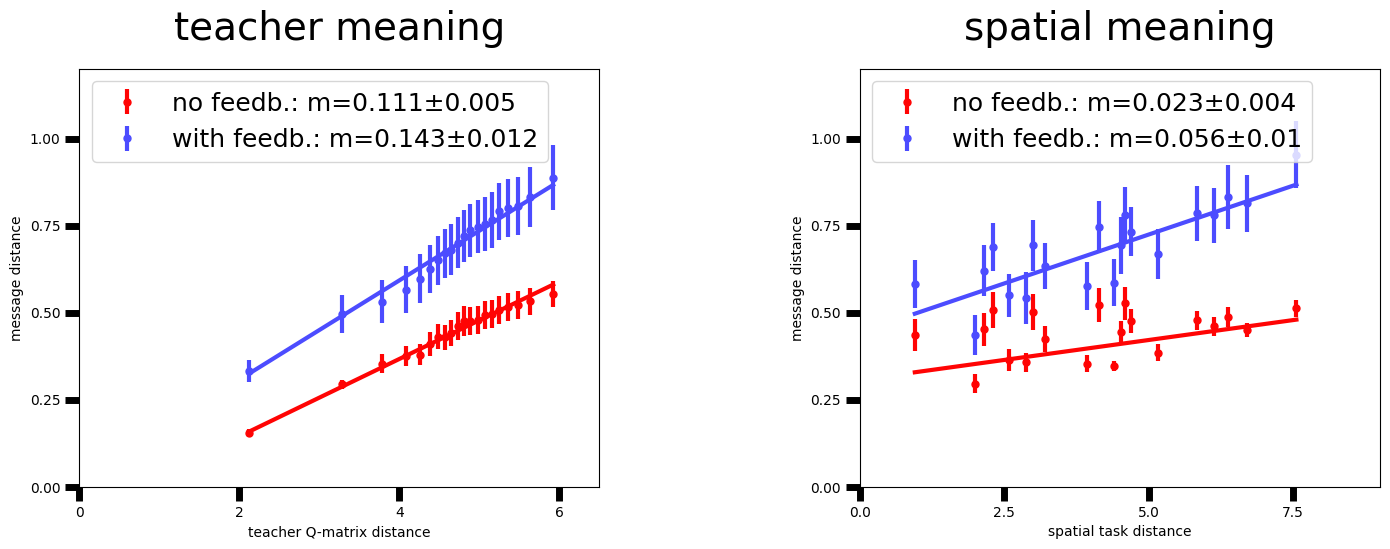

In [24]:
#@title PLOTS - Topographical similarity analysis (Fig. 3b, c)
'''
#See previous block - here are the plots
#basically what we see is how far are the messages from each other, when the ground truth meanings
#(i.e. Q-matrices or proba matrices) have a certain distance from each other

#as every language is different, we also normalize by average message pair distance in the second plot
#and in both cases we compare 5 languages each

#left column: not normalized, right column: normalized by average message pair distance
#first row: Q-matrices
#second row: P-matrices
'''

fig, ax =plt.subplots(1,2, figsize=(14,5.6))
cmap=plt.get_cmap("bwr")
plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
plt.rc('axes', labelsize=28)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)

for i, (language_prefix, color, color2, label) in enumerate(zip(["nonlinear_nostudent", "nonlinear_goallocs0_zeta5"], [cmap(0.99), cmap(0.15)], [cmap(0.75), cmap(0.25)], ["no feedb.", "with feedb."])):
    for j, meaning in enumerate(["q","vw"]):

        yvals=np.zeros((5,n_bins_topo))

        for l,lcode_topo in enumerate([f"{language_prefix}_language{k}" for k in range(5)]):
            x, y=np.loadtxt(file_loc+ f"topographic similarity/{meaning} vs m {n_bins_topo} bins {norm_topo}-norm {lcode_topo}")
            if l==0:
                xvals=x
            yvals[l]=y

        #average across languages
        yvals, yvals_std =np.mean(yvals, axis=0), np.std(yvals, axis=0)

        #linear curve fits for both scenarios
        popt1, pcov1=curve_fit(linfunc, xvals, yvals, sigma=yvals_std, absolute_sigma=True)

        #parameter formatting
        m1, b1=np.round(popt1[0],3), np.round(popt1[1],3)
        m1_std, b1_std=np.round(np.sqrt(np.diagonal(pcov1))[0],3), np.round(np.sqrt(np.diagonal(pcov1))[1],3)

        #first plot: regular message distances (averaged over languages)
        ax[j].errorbar(xvals, yvals, yerr=yvals_std, c=color, fmt="o", ms=5, label=label+f": m={m1}"+u"\u00B1"+f"{m1_std}", lw=3)
        ax[j].plot(xvals, linfunc(xvals, *popt1), color=color, lw=3)
        ax[j].legend(loc=2, fontsize=18)


xlims=[[0,6.5], [0,9]] if norm_topo==2 else [[0,35],[0,15]] if norm_topo==1 else None
ylims =[0,1.2]
ax[0].set_xlabel(f"teacher Q-matrix distance")
ax[1].set_xlabel(f"spatial task distance")
ax[0].set_ylabel(f"message distance")
ax[1].set_ylabel(f"message distance")

for i in range(2):
    ax[i].set_xlim(xlims[i])
    ax[i].set_ylim(ylims)
    ax[i].tick_params(width=5, length=10)

ax[0].set_title("teacher meaning", size=28, y=1.05)
ax[1].set_title("spatial meaning", size=28, y=1.05)

fig.tight_layout() #only titles for columns and rows

plt.subplots_adjust(wspace=0.5, hspace=0.6)

plt.show()

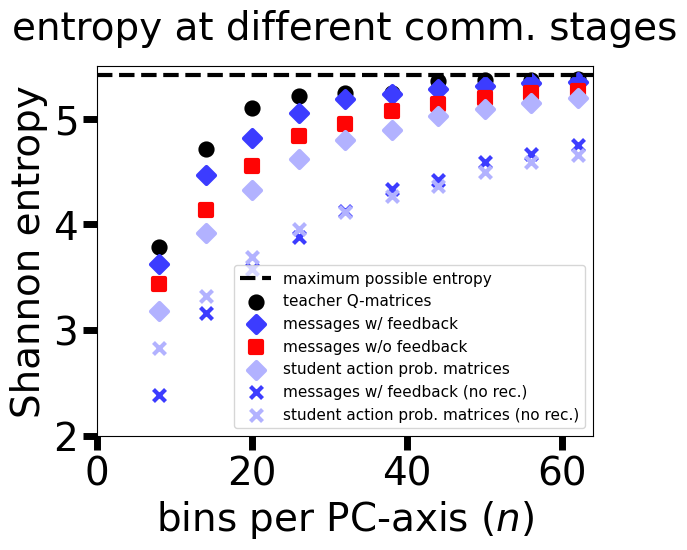

In [25]:
#@title PLOTS - Entropy binning approach (Fig. 3e)
'''
The plots of the entropy analysis
'''

cmap=plt.get_cmap("bwr")

#two plots for the two different histogram methods
for hplot, method in zip([1], ["equal extent"]):
    #I figured out that method 2 is the better one (always lower fit errors, more reasonable...)
    if hplot==0:
        continue
    #calculate mean and standard deviations over the 5 languages
    #change hear what should be plotted (also have to change colors and labels below of course)
    H_arrs=[H_feedback, H_nofeedback, H_pstd, H_feedback_noregu, H_pstd_noregu]
    H_means, H_stds=[], []
    for H_arr in H_arrs:
        H_stds+=[np.std(H_arr[hplot], axis=1)]
        H_means+=[np.mean(H_arr[hplot], axis=1)]

    #plot theoretical maximum entropy as dashed line
    Hmax=sp.stats.entropy([1/len(q_matrix_dict)]*len(q_matrix_dict))
    plt.plot([0,64], [Hmax, Hmax], ls="--", color="black", label="maximum possible entropy", lw=3)
    #scatter plots of entropies and corresponding hyperbolic tangent curve fits
    H_fitlist=[H_qteacher[hplot]]+H_means
    Hstd_fitlist=[None]+H_stds
    colors=["black", cmap(0.12), cmap(0.99), cmap(0.35), cmap(0.12), cmap(0.35)]
    labels=["teacher Q-matrices", "messages w/ feedback", "messages w/o feedback","student action prob. matrices", "messages w/ feedback (no rec.)", "student action prob. matrices (no rec.)"]
    markers=["o", "D", "s", "D", "x", "x"]
    err=0
    for H, H_std, color, label, marker in zip(H_fitlist, Hstd_fitlist, colors, labels, markers):
        #popt, pcov, infodict, _, _=curve_fit(lambda x, a, c: tanhfunc(x, a, c, Hmax), H_binlist, H, p0=[0.5,0.5], sigma=H_std, absolute_sigma=True, full_output=True)
        #err+=np.sum(np.absolute(infodict["fvec"]))
        #aparam, cparam=round(popt[0],3), round(popt[1],3)
        #print(aparam, cparam)
        #plt.plot(H_binlist, tanhfunc(H_binlist, popt[0], popt[1], Hmax), color=color, lw=3)
        plt.scatter(H_binlist, H, marker=marker, s=75, color=color, label=label, lw=3)
        #plt.errorbar(H_binlist, H, yerr=H_std, fmt=marker, ms=8, color=color, label=label, lw=3)

    #print(f"error is {err}")

    plt.legend(loc=4, fontsize=11)

    plt.xlim(0,64)
    plt.ylim(2,5.5)
    plt.xlabel(r"bins per PC-axis ($\it{n}$)")
    plt.ylabel("Shannon entropy")
    plt.title("entropy at different comm. stages", size=28, y=1.05)

    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    plt.rc('axes', labelsize=28)
    plt.rc('xtick', labelsize=28)
    plt.rc('ytick', labelsize=28)

    plt.tick_params(width=5, length=10)

    plt.show()


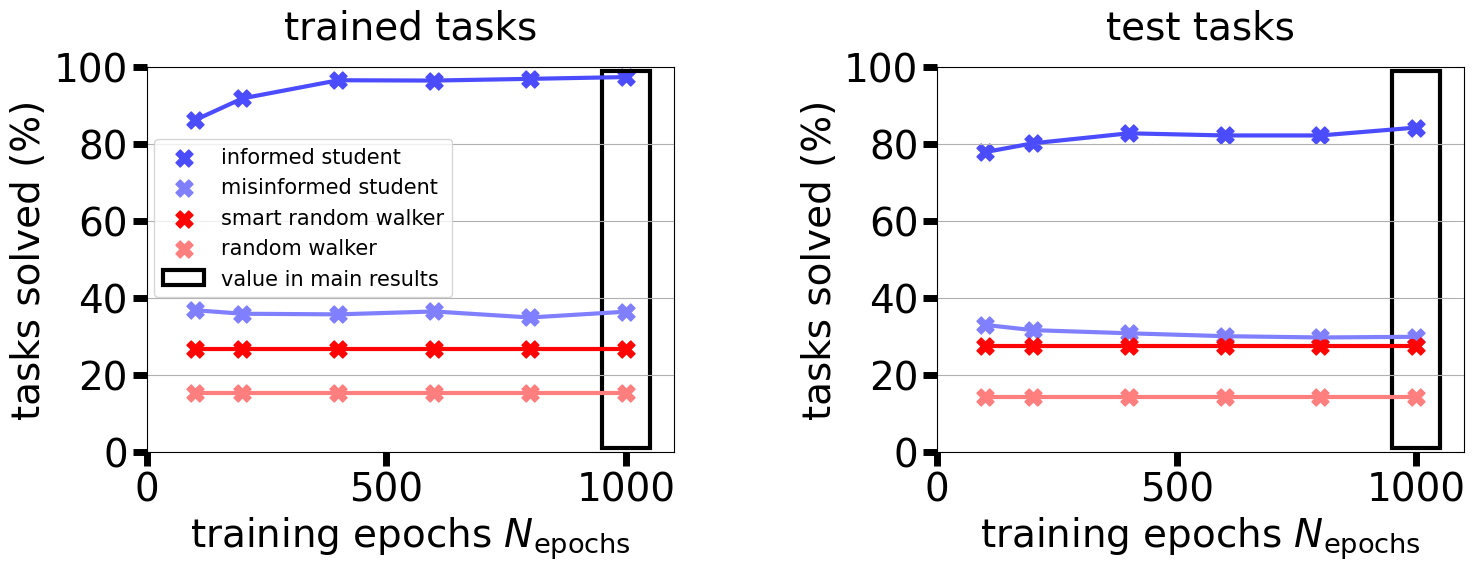

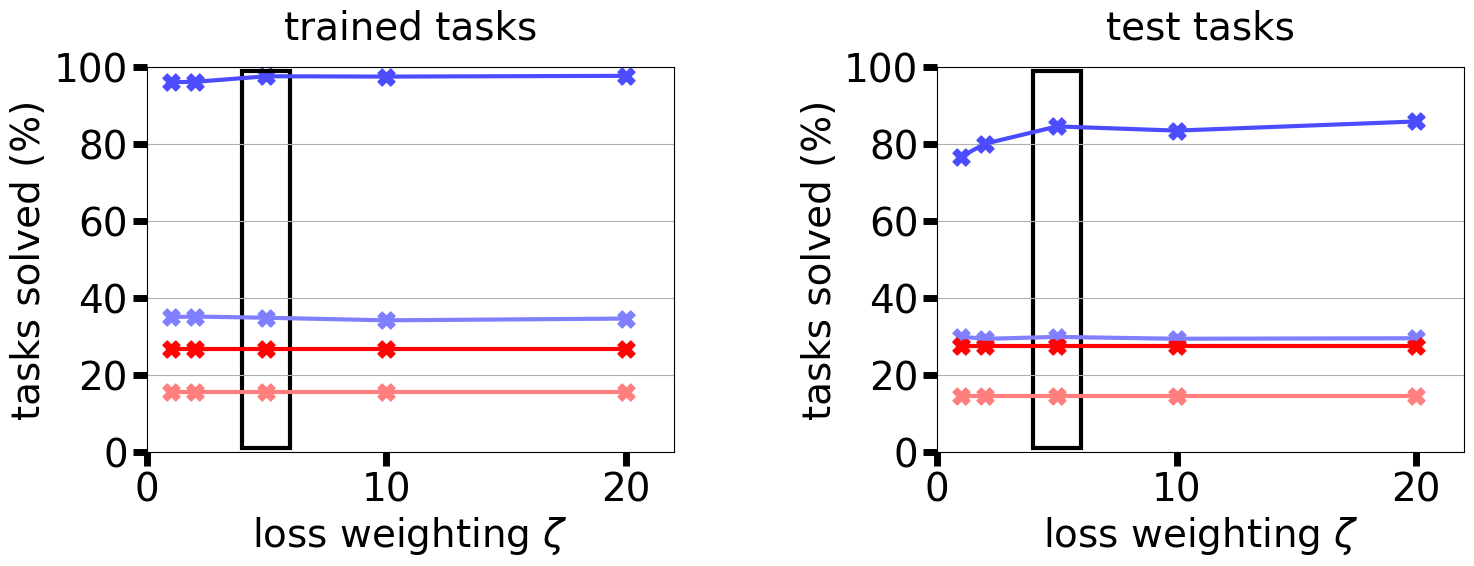

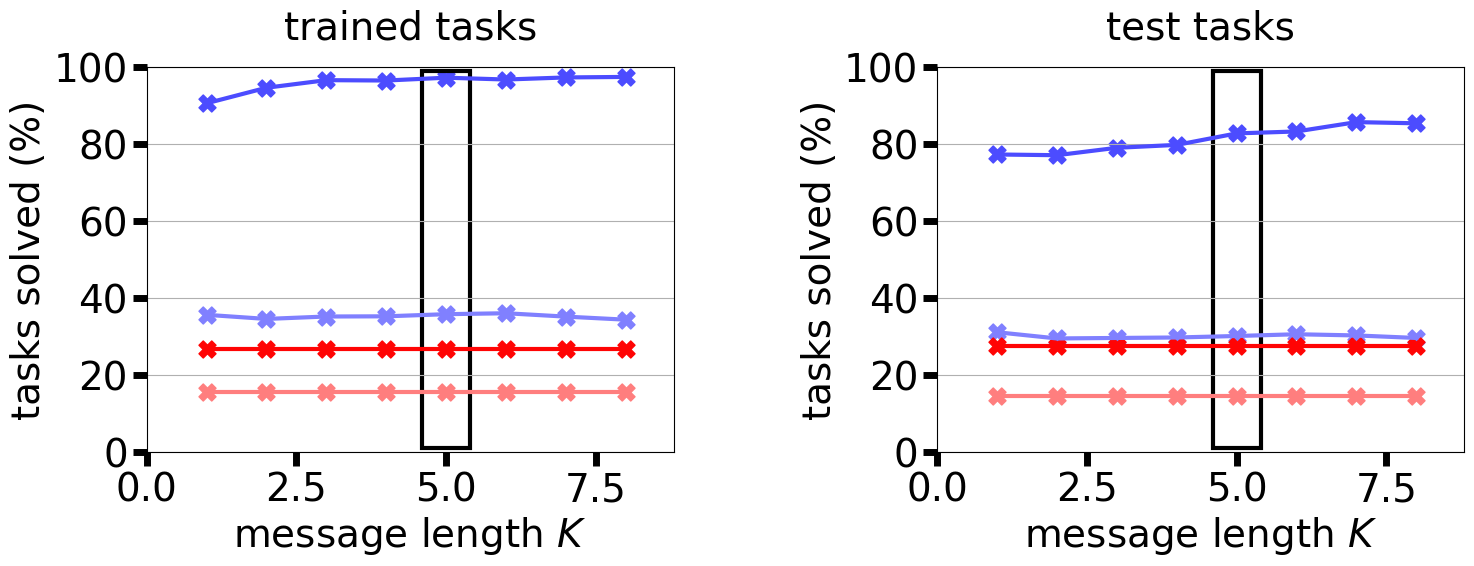

In [26]:
#@title PLOTS - Hyperparameter study (Fig. S8)
'''
Hyperparameter analysis - we kept everything constant and varied only one of the three parameters mentioned in the title
'''
from matplotlib.patches import Rectangle

#plot settings
plt.rc('axes', labelsize=28)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', titlesize=28)
cmap=plt.get_cmap("bwr")

folder_tags=["epochs", "zeta", "mlength_K"]
rect_xs=[950,4,4.6]
rect_widths=[100,2,0.8]
bboxes=[[0.6,0.84], [1, 0.725], [0.44, 0.725]]
xlabels=["training epochs "+r"$N_{\mathrm{epochs}}$", "loss weighting "+r"$\zeta$", "message length "+r"$K$"]

x_axes=[[100,200,400,600,800,1000], [1,2,5,10,20], [1,2,3,4,5,6,7,8]]
for index, (folder_tag, xaxis, rect_x, rect_width, bbox, xlabel) in enumerate(zip(folder_tags, x_axes, rect_xs, rect_widths, bboxes, xlabels)):

    #plot
    fig, ax=plt.subplots(1,2, figsize=(17,5))
    ax[0].grid(visible=True, axis="y")
    ax[1].grid(visible=True, axis="y")
    plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
    labels=["informed student","misinformed student","smart random walker","random walker"]
    colors=[cmap(0.15),cmap(0.25),cmap(0.99),cmap(0.75)]

    language_nr_hyp=5
    param=2 #the stepfactor
    #potentially chuck out languages if the performances are bad
    for plot, known_addon in zip([0,1], ["known","unknown"]): #iterate over performance on known and unknown tasks
        avg_rates=[[],[],[],[]]
        std_rates=[[],[],None, None]

        for j,_ in enumerate(xaxis):

            rates=np.loadtxt(file_loc+"hyperparameters/"+f"rates {folder_tag} {j} {known_addon}")
            #print(f"info:            {np.round(100*np.array(rates[0]),1)} - average {round(100*np.mean(rates[0]),1)}")
            #print(f"misinfo:         {np.round(100*np.array(rates[1]),1)} - average {round(100*np.mean(rates[1]),1)}")
            #print(f"smart rd walker: {round(100*rates[2][0],1)}")
            #print(f"rd walker:       {round(100*rates[3][0],1)}")

            #add average solving rate and NOW STANDARD ERROR OF THE MEAN
            for j,rates_student in enumerate(rates):
                avg_rates[j]+=[100*np.mean(rates_student)]
                if j<2:
                    std_rates[j]+=[100*np.std(rates_student, ddof=1)]
                    #sem_rates[j]+=[100*np.std(rates_student, ddof=1)/mt.sqrt(language_nr_hyp)]

        for yrates,std,label,color in zip(avg_rates, std_rates, labels, colors):
            ax[plot].plot(xaxis, yrates, color=color, lw=3)
            ax[plot].scatter(xaxis, yrates, color=color, label=label, marker="X", s=150)
            #ax[plot].errorbar(xaxis, yrates, yerr=std, color=color, label=label, fmt="X", ms=15, lw=3)

        ax[plot].set_ylim(0,100)
        ax[plot].set_ylabel("tasks solved (%)")
        ax[plot].set_xlim(0,1.1*xaxis[-1])

        #Define the coordinates and dimensions of the rectangle
        rect_height = 98  # height of the rectangle (can be adjusted as needed)
        # Create a Rectangle patch
        rect1 = Rectangle((rect_x, 1), rect_width, rect_height, fill=False, edgecolor='black', label="value in main results", lw=3)
        rect2 = Rectangle((rect_x, 1), rect_width, rect_height, fill=False, edgecolor='black', label="value in main results", lw=3)
        # Add the Rectangle patch to the plot
        if plot==0:
            ax[plot].add_patch(rect1)
        elif plot==1:
            ax[plot].add_patch(rect2)

        ax[plot].set_yticks([0,20,40,60,80,100])
        ax[plot].set_xlabel(xlabel)
        if index==0 and plot==0:
            ax[plot].legend(loc='upper right', bbox_to_anchor=bbox, fontsize=15)

        ax[plot].tick_params(width=5, length=10)

    ax[0].set_title(f"trained tasks", y=1.05)
    ax[1].set_title(f"test tasks", y=1.05)

    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    plt.show()


A total of 225 messages are plotted
We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 20.06, var. between 38.07, beta 0.655, F 26.44
Goal groups: var. within 38.26, var. between 19.87, beta 0.342, F 7.24

explained variances by the first 5 PCs are [33.63 27.93 17.79 12.44  8.21]


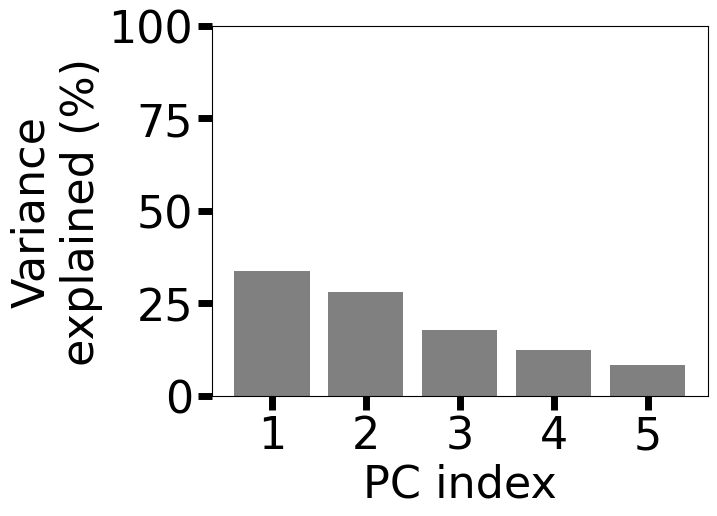

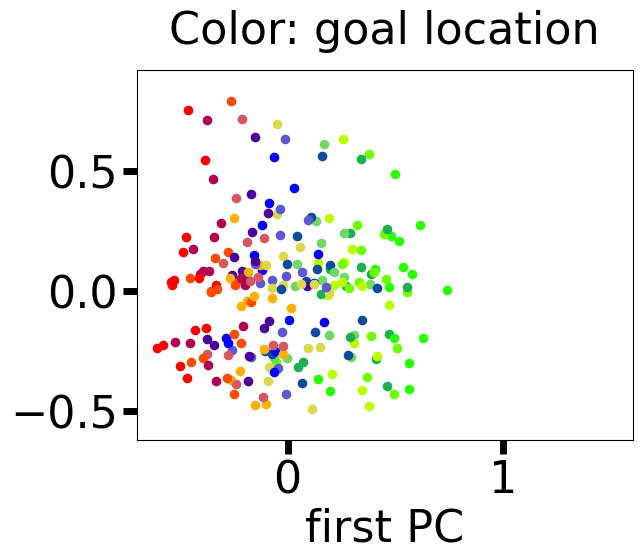

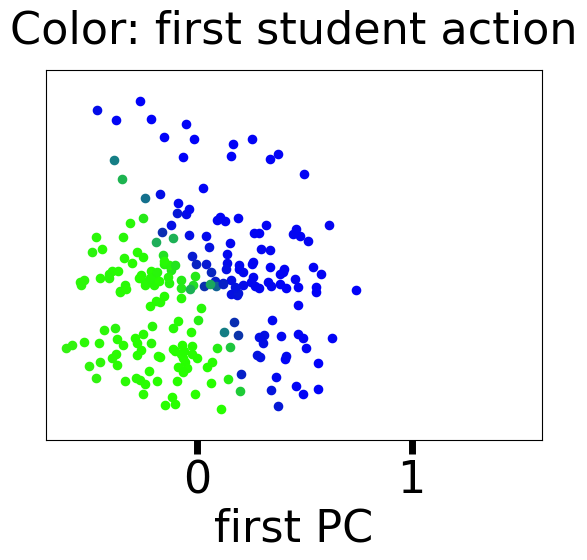

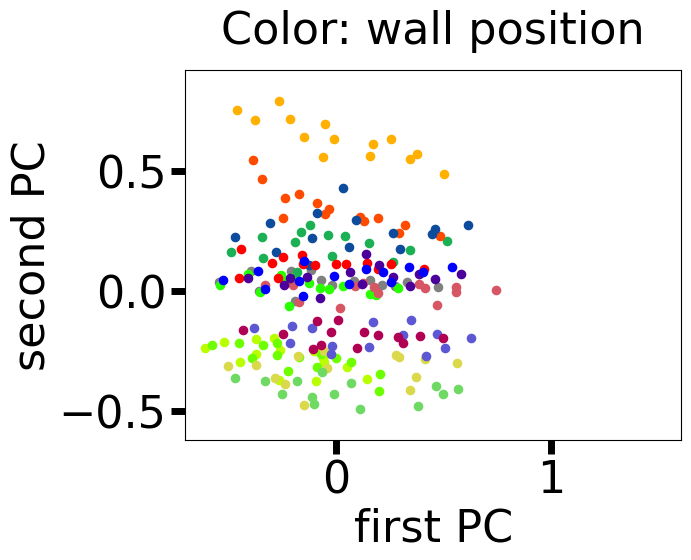

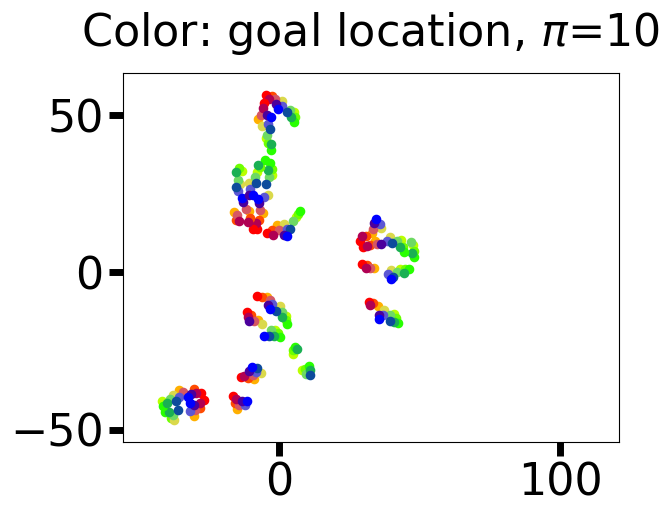

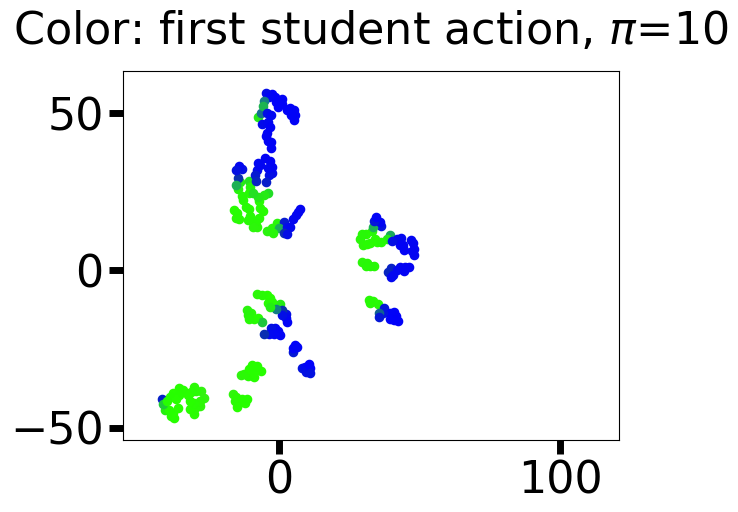

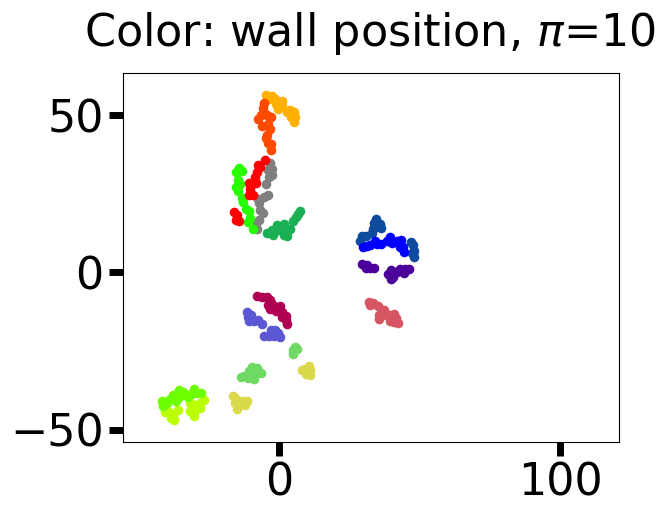

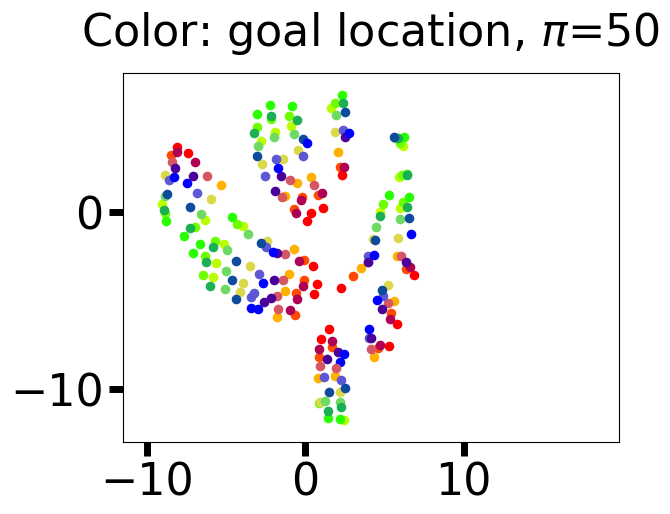

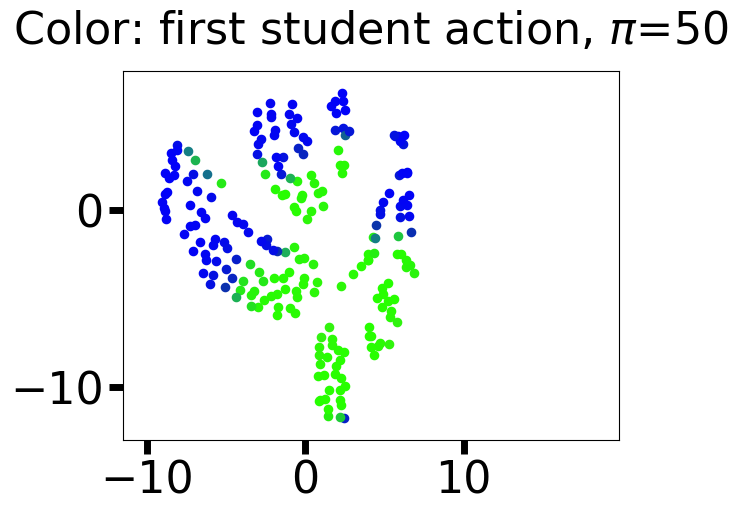

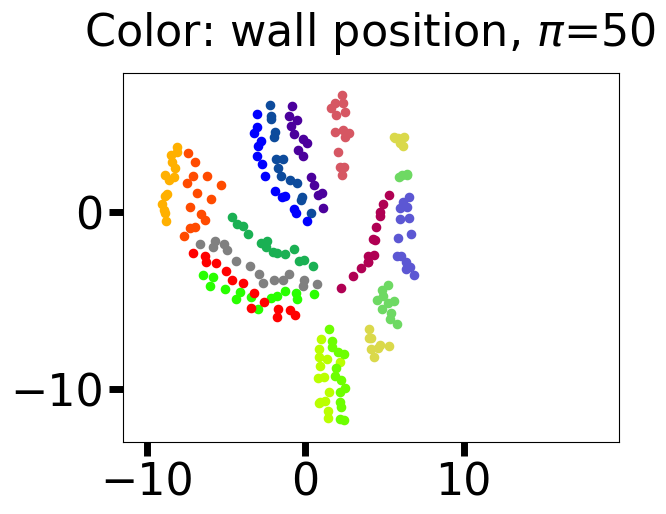

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


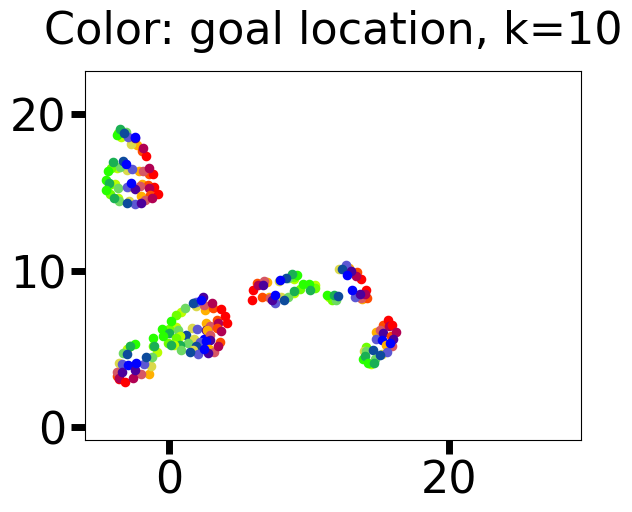

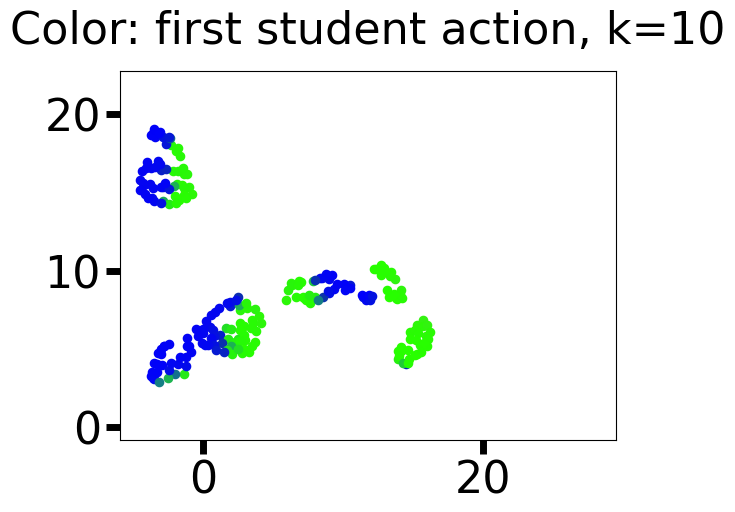

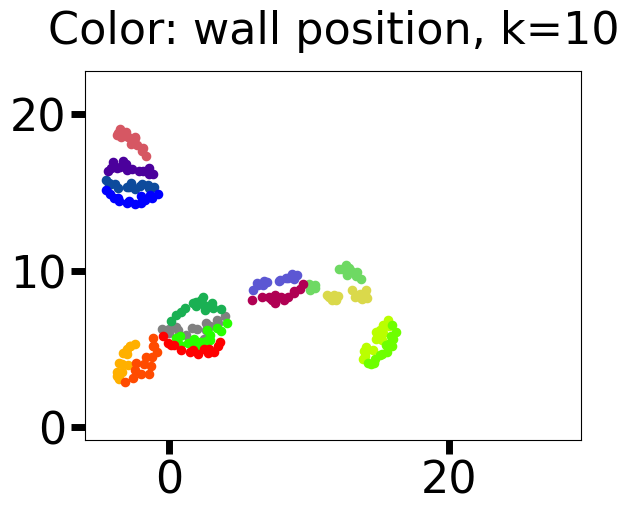

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


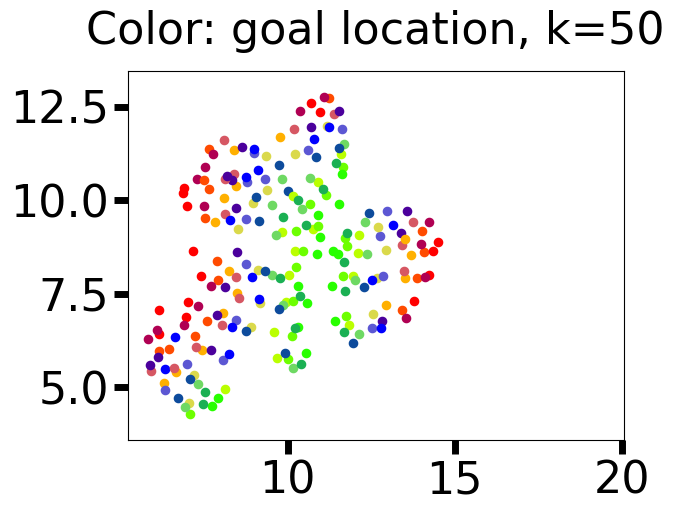

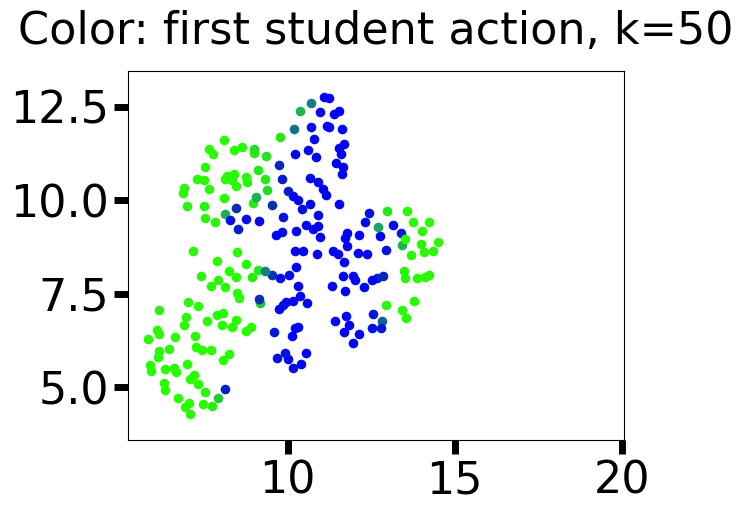

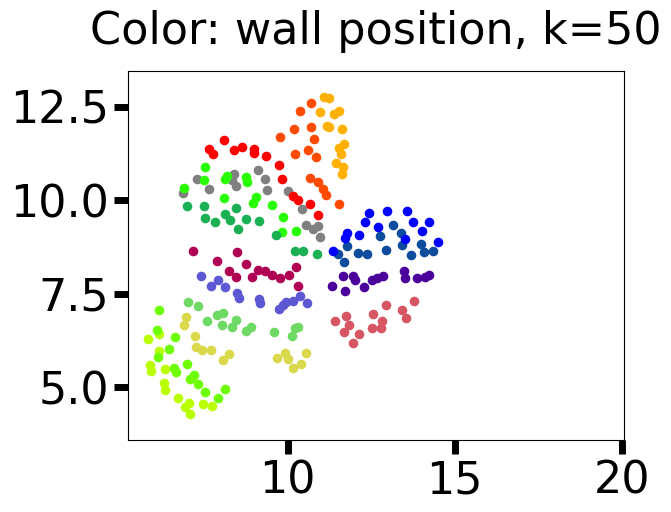

now looking at world 6
explained variances by the first 5 PCs are [90.    9.36  0.5   0.09  0.05]


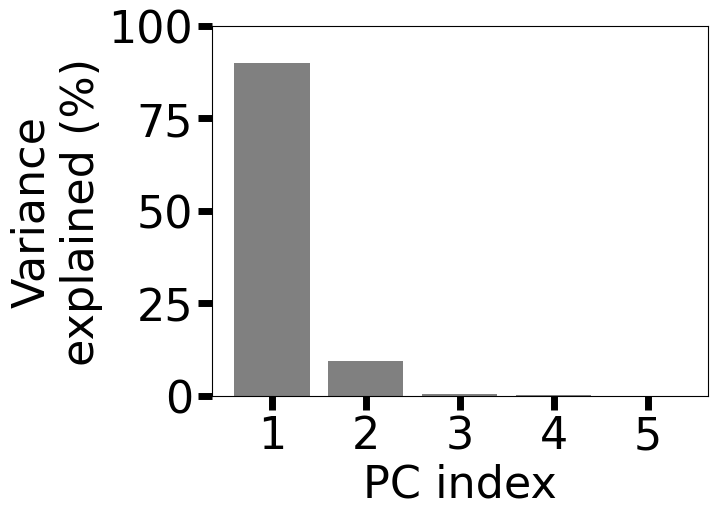

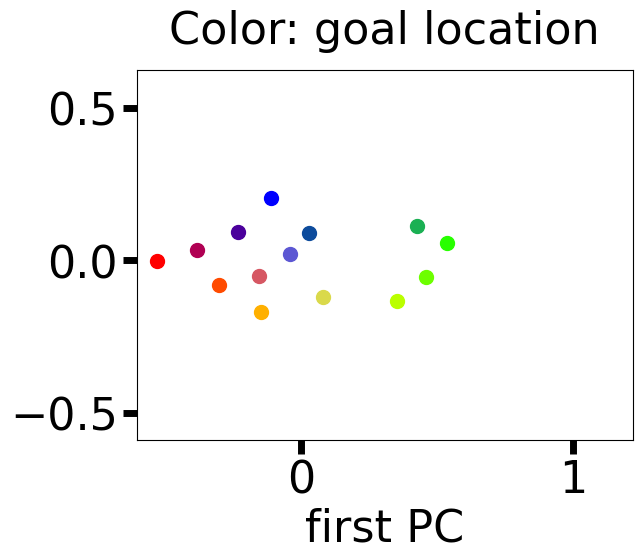

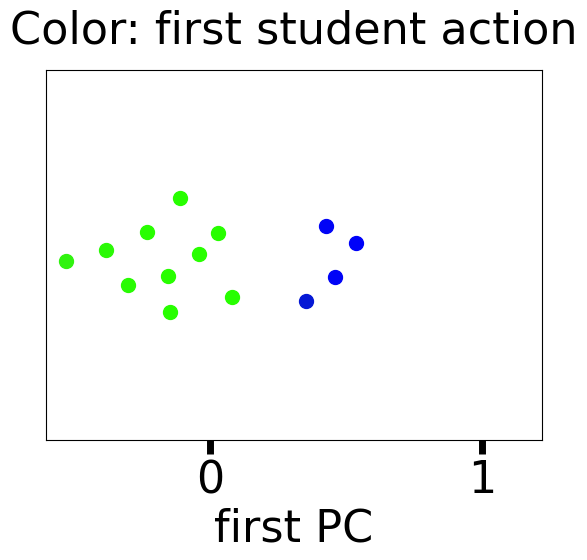

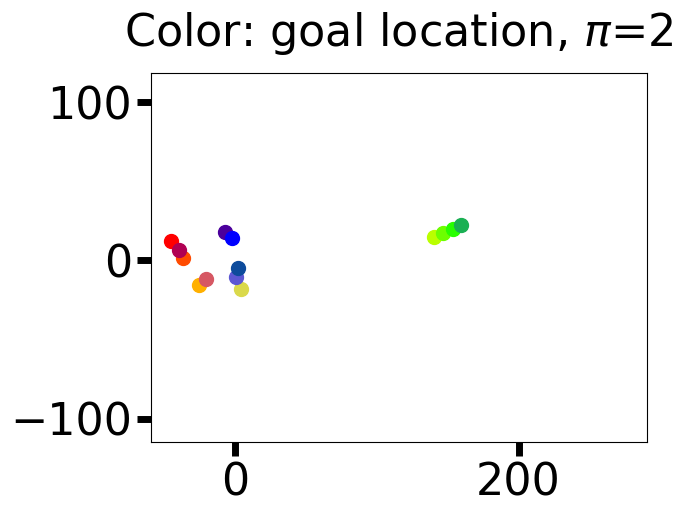

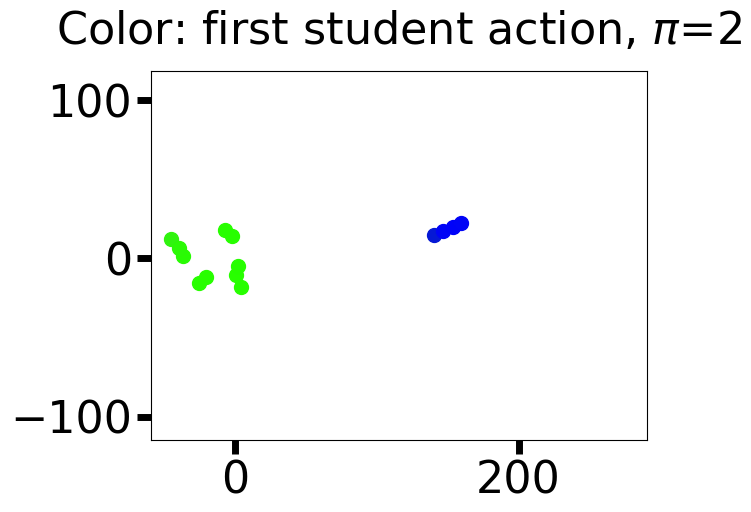

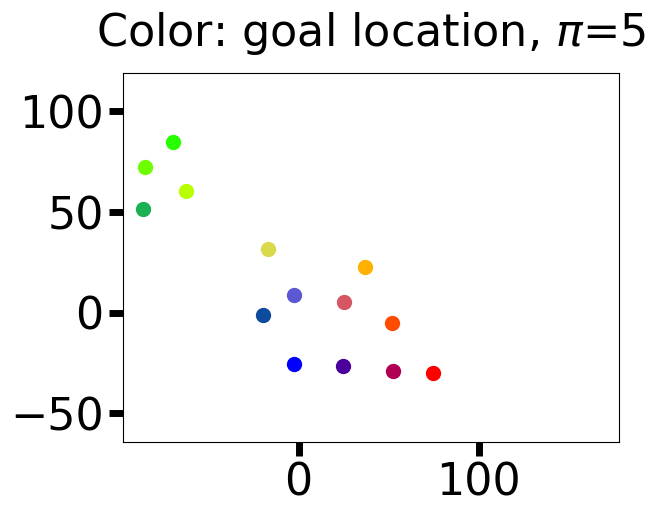

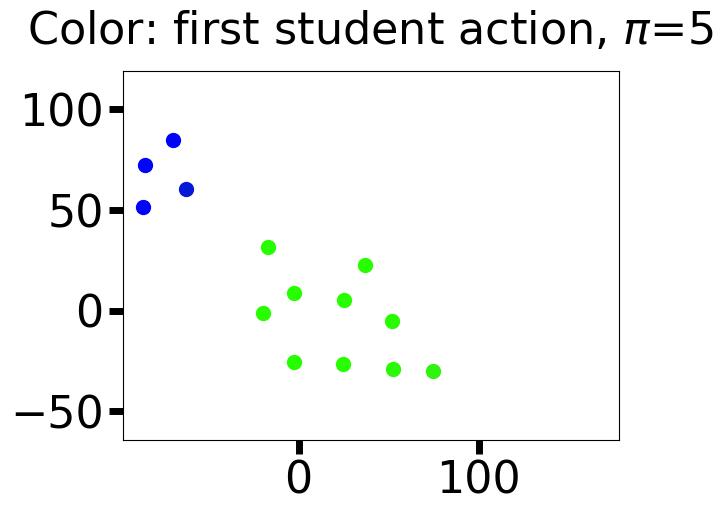

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


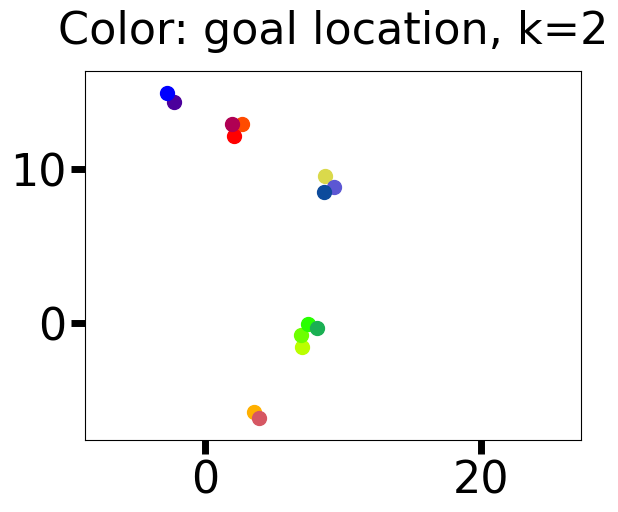

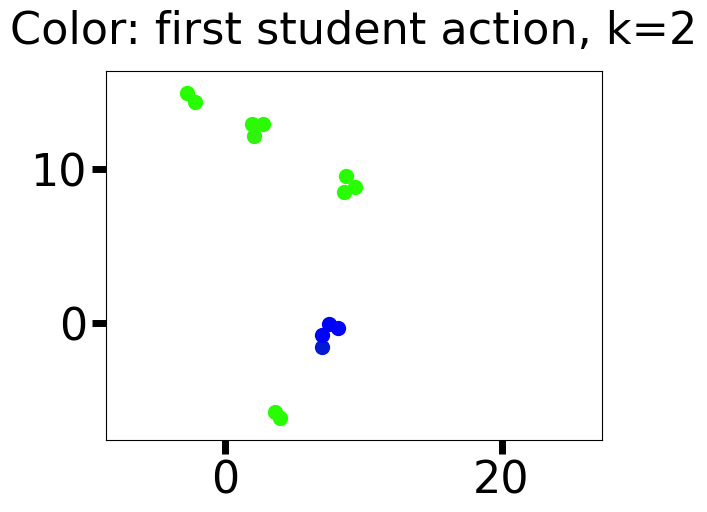

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


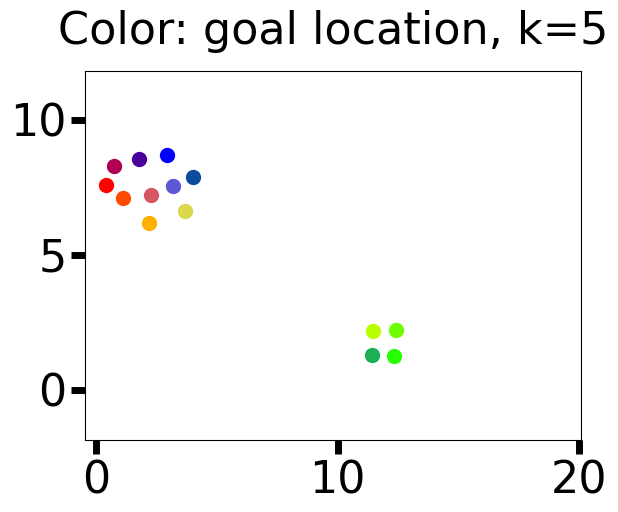

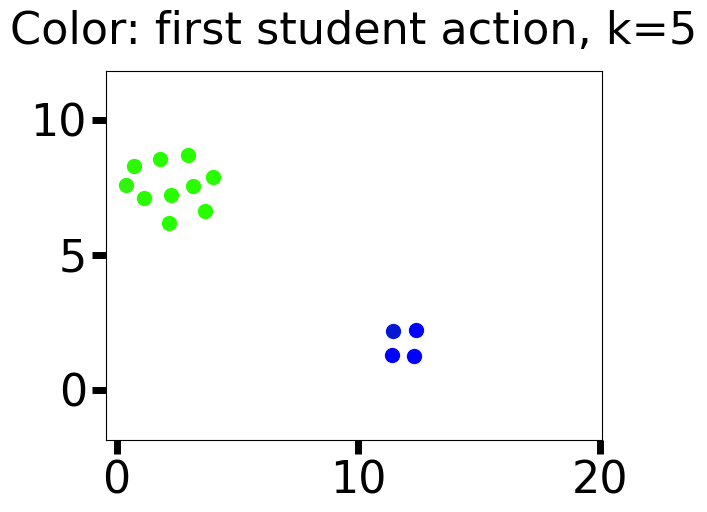

In [27]:
#@title PLOTS - Message space plots (PCA and t-SNE and UMAP)
'''
PCA and t-SNE dimensionality reductions of the messages
'''

#general specs of the plots
world_number=len(plot_worlds)

#parameters of t-sne plots
tsne_scaling=False #if True, then all dimensions will be of equal importance
tsne_iter=1500 #number of iterations for tsne algorithm
tsne_rdkernel=1

#parameters of umap plots
umap_mindist=0.5 #minimum distance between two points (can prevent "clumping") -> (recommended: 0-1), standard 0.1
umap_rdkernel=1


#-> have to create the folder in Drive first
if not os.path.exists(file_loc+f"message plots pca/{language_code}"):
    os.mkdir(file_loc+f"message plots pca/{language_code}")
if not os.path.exists(file_loc+f"message plots tsne/{language_code}"):
    os.mkdir(file_loc+f"message plots tsne/{language_code}")
if not os.path.exists(file_loc+f"message plots umap/{language_code}"):
    os.mkdir(file_loc+f"message plots umap/{language_code}")

#plot layout details
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)
plt.rc('axes', titlesize=32)
markersize_all, markersize_single=35,100 #marker size for the plots involving all words and just a single world respectively
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20(np.linspace(0,world_number/20,world_number))) #color cyclwer
cmap = ColorMap2DZiegler(range_x=(-0.5-(grid_dim/2-1), 0.5+(grid_dim/2-1)), range_y=(-0.5-(grid_dim/2-1), 0.5+(grid_dim/2-1))) #2d color map for goal locations

#create a color dictionary mapping world index to color
world_color_dict={0:"grey"}
for world in range(1,grid_dim**2):
    xworld,yworld=world%grid_dim, mt.floor(world/grid_dim)
    cval=(grid_dim-1)/2
    world_color_dict[world]=cmap(xworld-cval,yworld-cval)/255


#transform messages from tensors to arrays so that PCA and t-SNE can be done on them - only keep the ones from relevant worlds
message_list=np.array([mssg.detach().cpu().numpy() for i,mssg in message_dict.items() if (label_dict[i][0] in plot_worlds and label_dict[i][2]!=student_init)])
label_list=[[i,j,k] for [i,j,k,l] in label_dict.values() if i in plot_worlds]

print(f"A total of {len(message_list)} messages are plotted")

#do the variance analysis of the message space
variance_analyzer(autoencoder,message_list, label_list, plot_worlds)

#create variance-explained plot and goal location-/initialaction-colored plots of messages
pca_plotting(message_list, label_list, language_code, "all", cmap, markersize_all)
plt.show()

#do PCA on all messages
pca=PCA(K)
message_pca=pca.fit_transform(message_list)



#FIGURE WITH COLOR BY WALL POSITION IN 2D
fig,ax=plt.subplots()
ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)
#Scatterplot of the messages, PC1 vs PC2, color by world
for world in plot_worlds:
    world_indices=[i for i,label in enumerate(label_list) if label[0]==world]
    ax.scatter(message_pca[world_indices,0],message_pca[world_indices,1],label=f"world {world}", color=world_color_dict[world], s=markersize_all)
#make some adjustments to the axes so the legend is nicely placed and doesn't overlap with data points
plt.title("Color: wall position", y=1.05)
plt.xlabel(f"first PC")
plt.ylabel(f"second PC")
xdatamin,xdatamax=min(message_pca[:,0]), max(message_pca[:,0])
ydatamin,ydatamax=min(message_pca[:,1]), max(message_pca[:,1])
xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

#typical case of PCA
if xdatamax-xdatamin > ydatamax-ydatamin:
    ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
    ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
#for t-sne and umap have to take other scenario into account
else:
    ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
    ax.set_ylim(ymin, ymax)
plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
if save_message_plots:
    plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color world.svg", format="svg")
    plt.savefig(file_loc+"message plots pca/"+language_code+f"/PCA all messages, color world.png", format="png")
plt.show()


if do_tsne_message_plots:
    #do t-SNE on all messages
    if tsne_scaling:
        message_list = StandardScaler().fit_transform(message_list) #here we standardize data -> only needed if we want all axisensions to be of equal importance
    for tsne_perplexity in [10,50]:
        tsne = TSNE(perplexity=tsne_perplexity, n_iter=tsne_iter, random_state=tsne_rdkernel, init="pca", learning_rate="auto")
        message_tsne = tsne.fit_transform(message_list)
        #Now do T-SNE plots, first by goal location and initial action
        tsne_plotting(tsne_perplexity, tsne_iter, tsne_rdkernel, message_list, label_list, language_code, "all", tsne_scaling, cmap, markersize_all)
        plt.show()

        #TSNE FIGURE WITH COLOR BY WALL POSITION IN 2D
        fig,ax=plt.subplots()
        ax.xaxis.set_tick_params(width=5, length=10)
        ax.yaxis.set_tick_params(width=5, length=10)
        for world in plot_worlds:
            world_indices=[i for i,label in enumerate(label_list) if label[0]==world]
            ax.scatter(message_tsne[world_indices,0],message_tsne[world_indices,1],label=f"world {world}", color=world_color_dict[world], s=markersize_all)
        #make some adjustments to the axes so the legend is nicely placed and doesn't overlap with data points
        plt.title(f"Color: wall position, "+r"$\pi$="+f"{tsne_perplexity}", y=1.05)
        xdatamin,xdatamax=min(message_tsne[:,0]), max(message_tsne[:,0])
        ydatamin,ydatamax=min(message_tsne[:,1]), max(message_tsne[:,1])
        xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
        ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
        xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

        #typical case of PCA
        if xdatamax-xdatamin > ydatamax-ydatamin:
            ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
            ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
        #for t-sne and umap have to take other scenario into account
        else:
            ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
            ax.set_ylim(ymin, ymax)

        plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
        if save_message_plots:
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color world, perplexity {tsne_perplexity}.svg", format="svg")
            plt.savefig(file_loc+"message plots tsne/"+language_code+f"/t-SNE all messages, color world, perplexity {tsne_perplexity}.png", format="png")
        plt.show()


if do_umap_message_plots:
    for umap_neighbors in [10,50]:
        #do UMAP on all messages
        umap_red = umap.UMAP(n_neighbors=umap_neighbors, min_dist=umap_mindist, random_state=umap_rdkernel)
        message_umap = umap_red.fit_transform(message_list)
        #Now do T-SNE plots, first by goal location and initial action
        umap_plotting(umap_neighbors, umap_mindist, umap_rdkernel, message_list, label_list, language_code, "all", cmap, markersize_all)
        plt.show()

        #UMAP FIGURE WITH COLOR BY WALL POSITION IN 2D
        fig,ax=plt.subplots()
        ax.xaxis.set_tick_params(width=5, length=10)
        ax.yaxis.set_tick_params(width=5, length=10)
        for world in plot_worlds:
            world_indices=[i for i,label in enumerate(label_list) if label[0]==world]
            ax.scatter(message_umap[world_indices,0],message_umap[world_indices,1],label=f"world {world}", color=world_color_dict[world], s=markersize_all)
        #make some adjustments to the axes so the legend is nicely placed and doesn't overlap with data points
        plt.title(f"Color: wall position, k={umap_neighbors}", y=1.05)
        xdatamin,xdatamax=min(message_umap[:,0]), max(message_umap[:,0])
        ydatamin,ydatamax=min(message_umap[:,1]), max(message_umap[:,1])
        xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
        ymin, ymax = ydatamin - 0.07*(ydatamax-ydatamin), ydatamax + 0.07*(ydatamax-ydatamin)
        xmean, ymean=(xmax+xmin)/2, (ymax+ymin)/2

        #typical case of PCA
        if xdatamax-xdatamin > ydatamax-ydatamin:
            ax.set_xlim(xmin,xmax+(xmax-xmin)/2)
            ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
        #for t-sne and umap have to take other scenario into account
        else:
            ax.set_xlim(xmean-1/2*(ymax-ymin), xmean+1*(ymax-ymin))
            ax.set_ylim(ymin, ymax)

        plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
        if save_message_plots:
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color world, neighbors {umap_neighbors}.svg", format="svg")
            plt.savefig(file_loc+"message plots umap/"+language_code+f"/UMAP all messages, color world, neighbors {umap_neighbors}.png", format="png")
        plt.show()






#Finally repeat the above plots for the single grid-worlds (here only need goal location and initial action plots)
for world in plot_worlds_single:
    print(f"now looking at world {world}")
    #transform data from tensors to arrays so that PCA can be done on them
    label_list_world=[j for i,j in label_dict.items() if j[0]==world]
    message_list_world=np.array([mssg.detach().cpu().numpy() for i,mssg in message_dict.items() if label_dict[i][0]==world])
    if len(message_list_world)>0:
        #create variance-explained plot and goal location-/initial action-colored plots of messages
        pca_plotting(message_list_world, label_list_world, language_code, world, cmap, markersize_single)
        if do_tsne_message_plots:
            for tsne_perplexity_singleworld in [2,5]:
                tsne_plotting(tsne_perplexity_singleworld, tsne_iter, tsne_rdkernel,message_list_world, label_list_world, language_code, world, tsne_scaling, cmap, markersize_single)
        if do_umap_message_plots:
            for umap_neighbors_singleworld in [2,5]:
                umap_plotting(umap_neighbors_singleworld, umap_mindist, umap_rdkernel, message_list_world, label_list_world, language_code, world, cmap, markersize_single)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


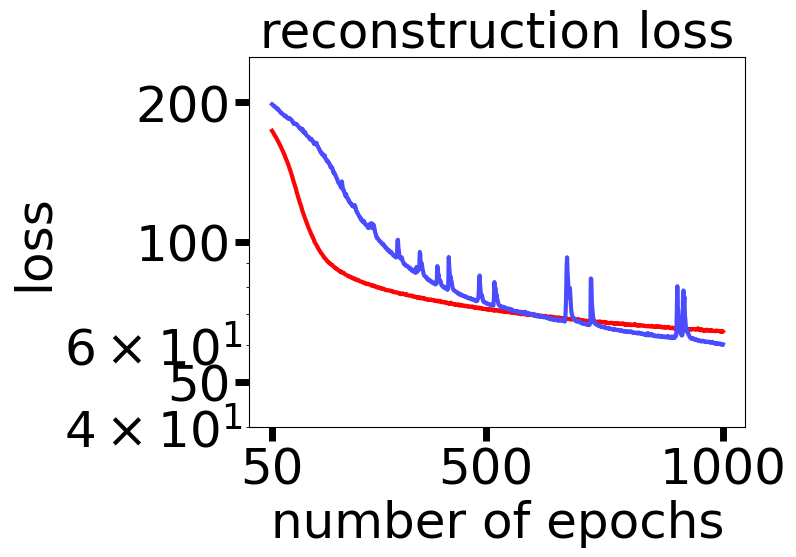

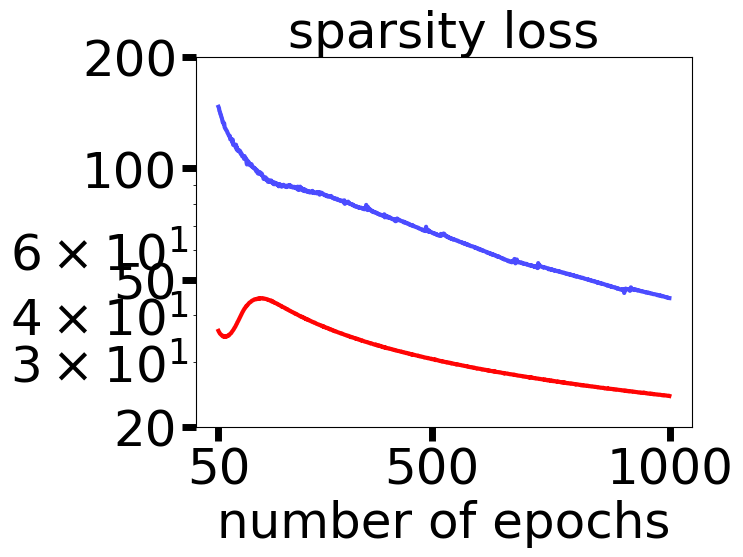

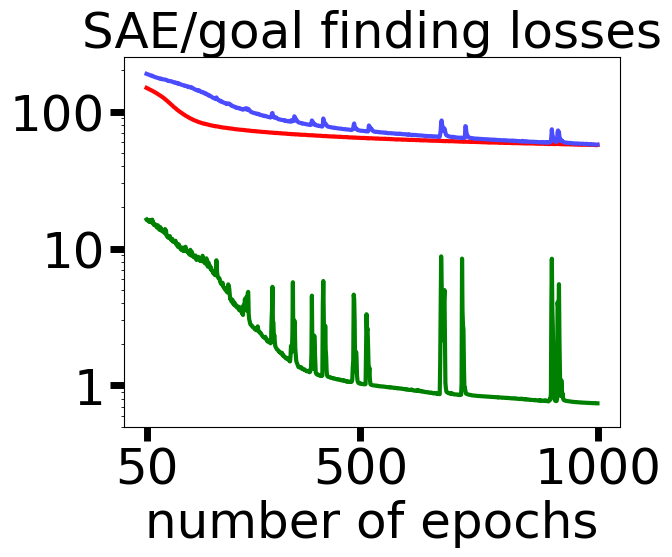

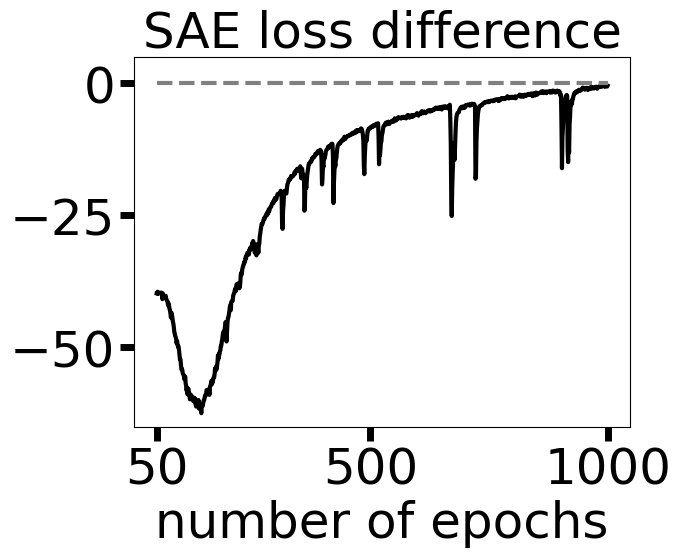

In [28]:
#@title PLOTS - Autoencoder loss plots

#plotting details
plt.rc('axes', labelsize=36)
plt.rc('xtick', labelsize=36)
plt.rc('ytick', labelsize=36)
plt.rc('axes', titlesize=36)
plt.rcParams['svg.fonttype']='none' #to make later editing of figures in inkscape easier
cmap=plt.get_cmap("bwr")



#load losses from case without student feedback
losses1=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_losses1_factor1.txt")
rec_losses1=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_rec_losses1_factor1.txt")
spar_losses1=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_spar_losses1_factor1.txt")
#load losses from case with student feedback
rec_losses2=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_rec_losses2_zeta{zeta_lossplot}_factor1.txt")
losses2=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_losses2_zeta{zeta_lossplot}_factor1.txt")
spar_losses2=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_spar_losses2_zeta{zeta_lossplot}_factor1.txt")
goal_losses2=np.loadtxt(file_loc+f"autoencoder/losses/nonlinear_goal_losses2_zeta{zeta_lossplot}_factor1.txt")



#Plot reconstruction losses with and without student feedback
fig,ax = plt.subplots()
ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)

ax.plot(range(epskip,len(losses1)), rec_losses1[epskip:len(losses1)], label="no feedback", color=cmap(0.99), lw=3)
ax.plot(range(epskip,len(losses1)), rec_losses2[epskip:len(losses1)], label="with feedback", color=cmap(0.15), lw=3)

ax.set_xlabel("number of epochs")
ax.set_ylabel("loss")
plt.title("reconstruction loss")
ax.set_yscale("log")
ax.set_xticks([epskip,500,1000])
ax.set_yticks([50,100,200],["50","100","200"])
plt.ylim(40,250)
if save_autoenc_lossplots:
    plt.savefig(file_loc+f"autoencoder/nonlinear_reconstruction_loss_zeta{zeta_std}_factor1.svg",format="svg")
    plt.savefig(file_loc+f"autoencoder/nonlinear_reconstruction_loss_zeta{zeta_std}_factor1.png",format="png")



#Plot sparsity losses with and without student feedback
fig,ax = plt.subplots()
ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)

ax.plot(range(epskip,len(losses1)), spar_losses1[epskip:len(losses1)], label="no feedback", color=cmap(0.99), lw=3)
ax.plot(range(epskip,len(losses1)), spar_losses2[epskip:len(losses1)], label="with feedback", color=cmap(0.15), lw=3)

ax.set_xlabel("number of epochs")
plt.title("sparsity loss")
ax.set_yscale("log")
ax.set_xticks([epskip,500,1000])
ax.set_yticks([20,50,100,200],["20","50","100","200"])
plt.ylim(20,200)
if save_autoenc_lossplots:
    plt.savefig(file_loc+f"autoencoder/nonlinear_sparsity_loss_zeta{zeta_std}_factor1.svg",format="svg")
    plt.savefig(file_loc+f"autoencoder/nonlinear_sparsity_loss_zeta{zeta_std}_factor1.png",format="png")



#Plot SAE losses with and without student feedback plus goal finding losses
fig,ax = plt.subplots()
ax.xaxis.set_tick_params(width=5, length=10)
ax.yaxis.set_tick_params(width=5, length=10)

ax.plot(range(epskip,len(losses1)), (1-gamma_sparse)*rec_losses1[epskip:len(losses1)]+gamma_sparse*spar_losses1[epskip:len(losses1)], label="no feedback", color=cmap(0.99), lw=3)
ax.plot(range(epskip,len(losses1)), (1-gamma_sparse)*rec_losses2[epskip:len(losses1)]+gamma_sparse*spar_losses2[epskip:len(losses1)], label="with feedback", color=cmap(0.15), lw=3)
ax.plot(range(epskip,len(losses1)), goal_losses2[epskip:len(losses1)], label="goal finding loss", color="green", lw=3)

ax.set_xlabel("number of epochs")
plt.title("SAE/goal finding losses")
ax.set_yscale("log")
ax.set_xticks([epskip,500,1000])
ax.set_yticks([1,10,100],["1","10","100"])
plt.ylim(0.5,250)
if save_autoenc_lossplots:
    plt.savefig(file_loc+f"autoencoder/nonlinear_combined_loss_zeta{zeta_std}_factor1.svg",format="svg")
    plt.savefig(file_loc+f"autoencoder/nonlinear_combined_loss_zeta{zeta_std}_factor1.png",format="png")



#Plot SAE loss difference between cases with and without student feedback
plt.figure()
plt.ticklabel_format(style='plain')
axt = plt.gca()
axt.tick_params(width=5, length=10)

plt.plot(range(epskip,len(losses1)), (1-gamma_sparse)*rec_losses1[epskip:len(losses1)]+gamma_sparse*spar_losses1[epskip:len(losses1)]-((1-gamma_sparse)*rec_losses2[epskip:len(losses1)]+gamma_sparse*spar_losses2[epskip:len(losses1)]), label="loss difference", color="black", lw=3)
plt.plot(range(epskip,len(losses1)), np.zeros(len(losses1))[epskip:] , color="gray", linestyle="dashed",lw=3) #mark the 0 with a dashed line

plt.xlabel("number of epochs")
plt.xticks([epskip,500,1000])
plt.title("SAE loss difference")
plt.ylim(-65,5)
if save_autoenc_lossplots:
    plt.savefig(file_loc+f"autoencoder/nonlinear_lossdifference_zeta{zeta_std}_factor1.svg",format="svg")
    plt.savefig(file_loc+f"autoencoder/nonlinear_lossdifference_zeta{zeta_std}_factor1.png",format="png")


goal location group 0, goal finding rates for the single languages (in %)
info:            [98.1 98.2 98.2 97.9 98.3] - average 98.1
misinfo:         [33.6 34.8 34.7 34.5 32.6] - average 34.0
smart rd walker: 26.7
rd walker:       15.4
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0. 0.]

goal location group 1, goal finding rates for the single languages (in %)
info:            [97.1 97.4 97.  95.9 97.8] - average 97.0
misinfo:         [36.8 35.  35.6 35.2 35. ] - average 35.5
smart rd walker: 26.7
rd walker:       17.1
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0. 0.]

goal location group 2, goal finding rates for the single languages (in %)
info:            [98.2 98.  98.3 98.  98. ] - average 98.1
misinfo:         [33.9 35.1 34.3 36.3 33.5] - average 34.6
smart rd walker: 26.7
rd walker:       13.5
p-valu

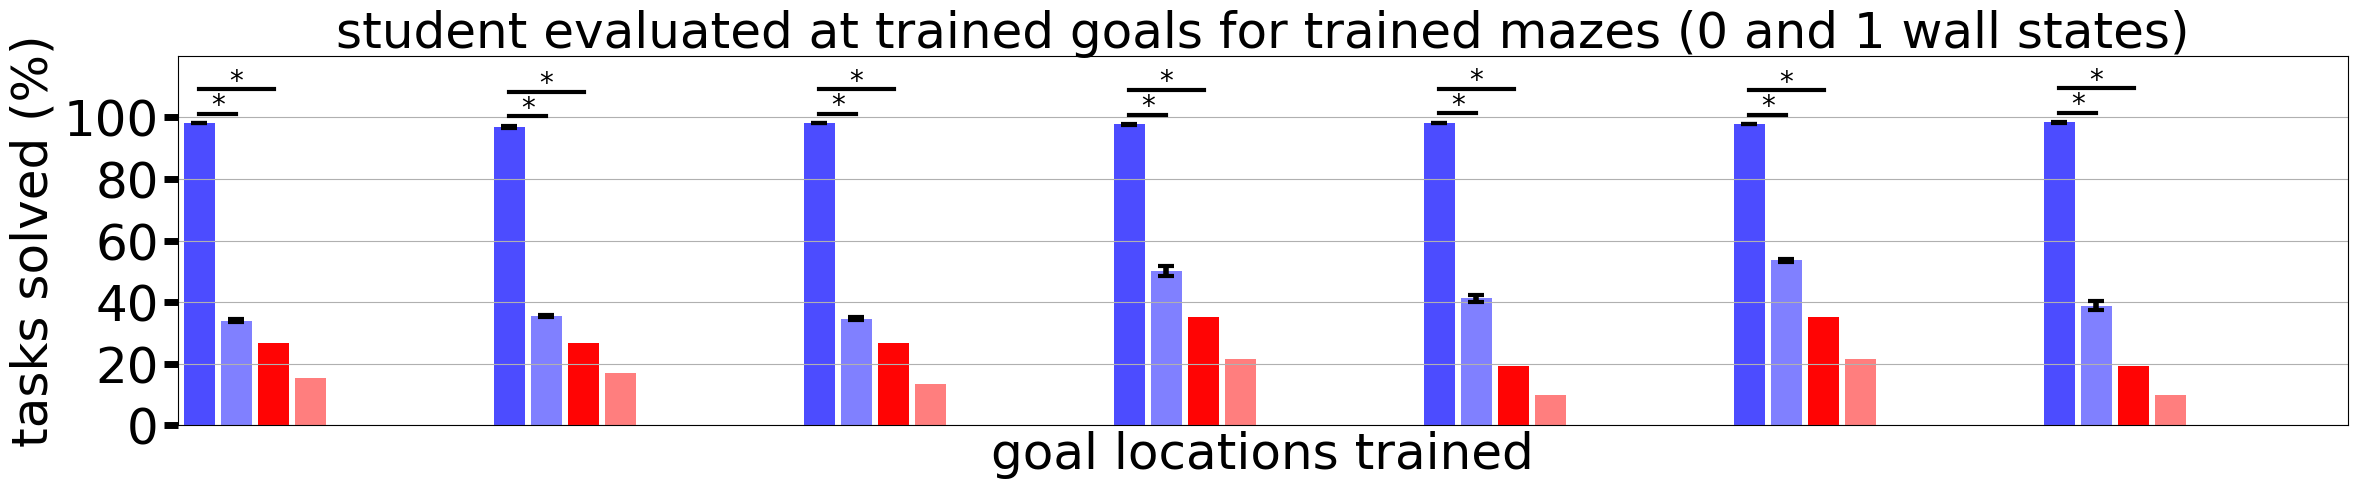

goal location group 1, goal finding rates for the single languages (in %)
info:            [84.9 80.4 81.8 83.8 80.4] - average 82.3
misinfo:         [35.1 32.  33.9 35.2 33. ] - average 33.9
smart rd walker: 26.7
rd walker:       13.5
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0. 0.]

goal location group 2, goal finding rates for the single languages (in %)
info:            [84.8 84.1 88.9 87.3 91.1] - average 87.2
misinfo:         [35.  37.4 33.3 35.2 35.5] - average 35.3
smart rd walker: 26.7
rd walker:       17.1
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0. 0.]

goal location group 3, goal finding rates for the single languages (in %)
info:            [ 8.2 17.4 14.9 20.7 23.5] - average 17.0
misinfo:         [ 5.7 13.7 10.1 12.1 15. ] - average 11.3
smart rd walker: 19.4
rd walker:       9.9
p-value

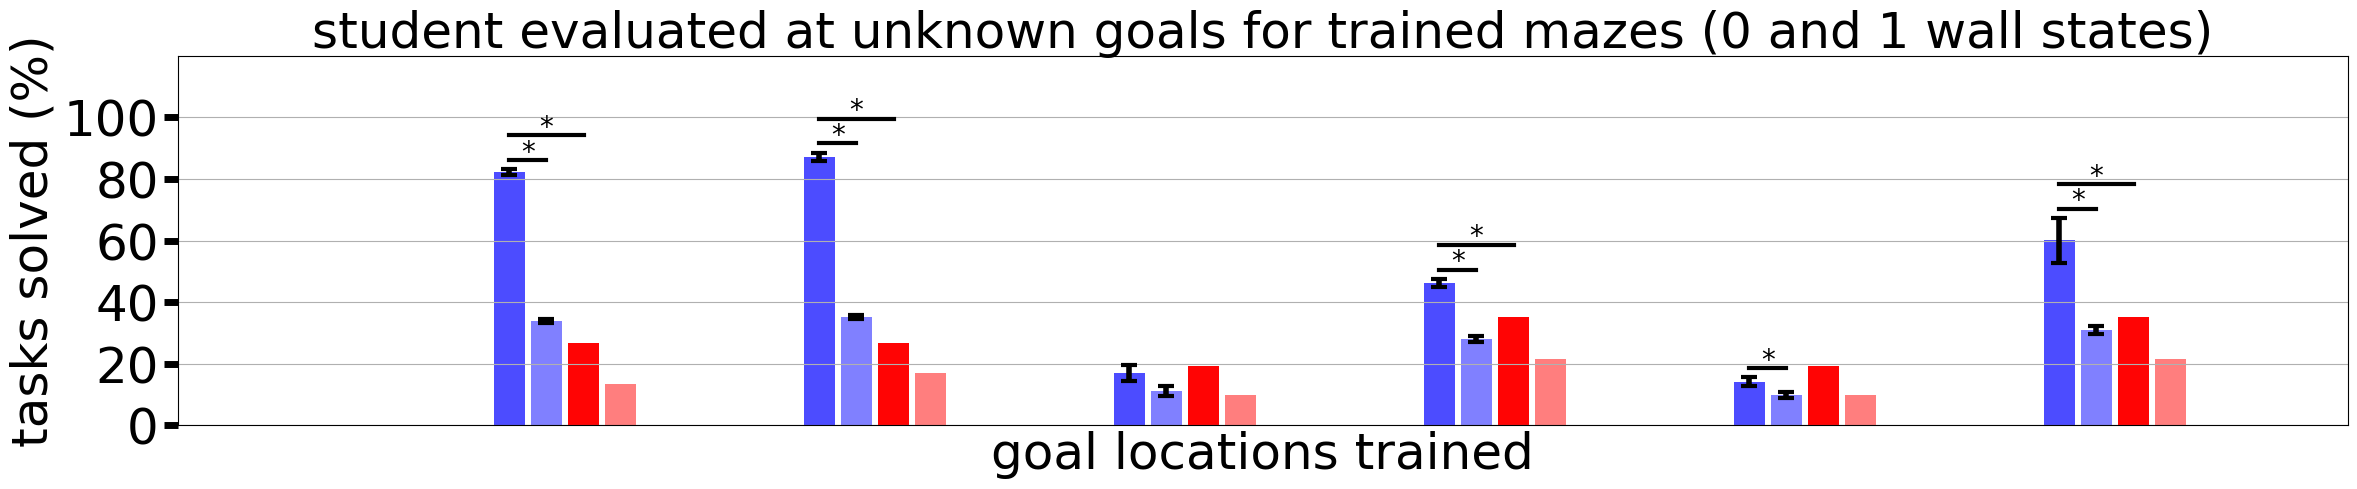

goal location group 0, goal finding rates for the single languages (in %)
info:            [81.7 82.8 79.3 81.  84.1] - average 81.8
misinfo:         [27.8 28.  26.9 27.6 28.7] - average 27.8
smart rd walker: 27.5
rd walker:       14.4
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0.354 0.   ]

goal location group 1, goal finding rates for the single languages (in %)
info:            [81.3 78.7 73.2 80.3 78.6] - average 78.4
misinfo:         [31.5 29.6 30.8 29.7 31.3] - average 30.6
smart rd walker: 27.8
rd walker:       16.3
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0.002 0.   ]

goal location group 2, goal finding rates for the single languages (in %)
info:            [80.7 78.9 82.4 80.2 83.3] - average 81.1
misinfo:         [27.9 29.1 27.9 28.6 28.7] - average 28.4
smart rd walker: 27.1
rd walker:      

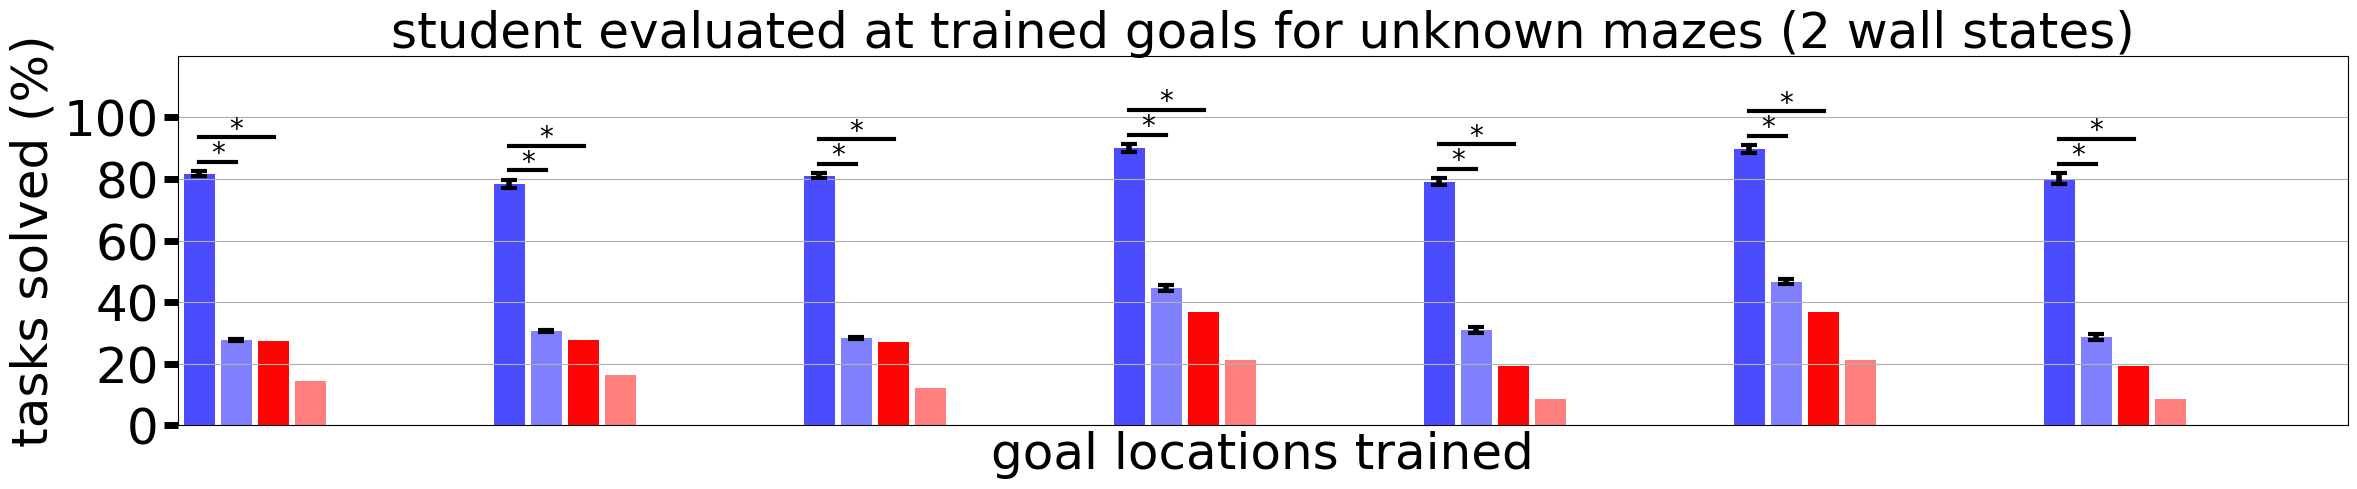

goal location group 1, goal finding rates for the single languages (in %)
info:            [73.  69.2 61.6 72.7 70.8] - average 69.4
misinfo:         [28.6 28.4 27.7 26.7 27.5] - average 27.8
smart rd walker: 27.1
rd walker:       12.3
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0.122 0.   ]

goal location group 2, goal finding rates for the single languages (in %)
info:            [71.8 72.8 74.5 73.1 78.7] - average 74.2
misinfo:         [30.7 30.2 29.6 29.8 30. ] - average 30.1
smart rd walker: 27.8
rd walker:       16.3
p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    [0. 0. 0.]
p-values (t-test) for misinformed (vs rd-smart, rd) are: [0. 0.]

goal location group 3, goal finding rates for the single languages (in %)
info:            [ 6.4 18.1 14.4 12.4 20.2] - average 14.3
misinfo:         [ 4.5 11.2  8.2  7.8 10.8] - average 8.5
smart rd walker: 19.3
rd walker:       8.5
p-

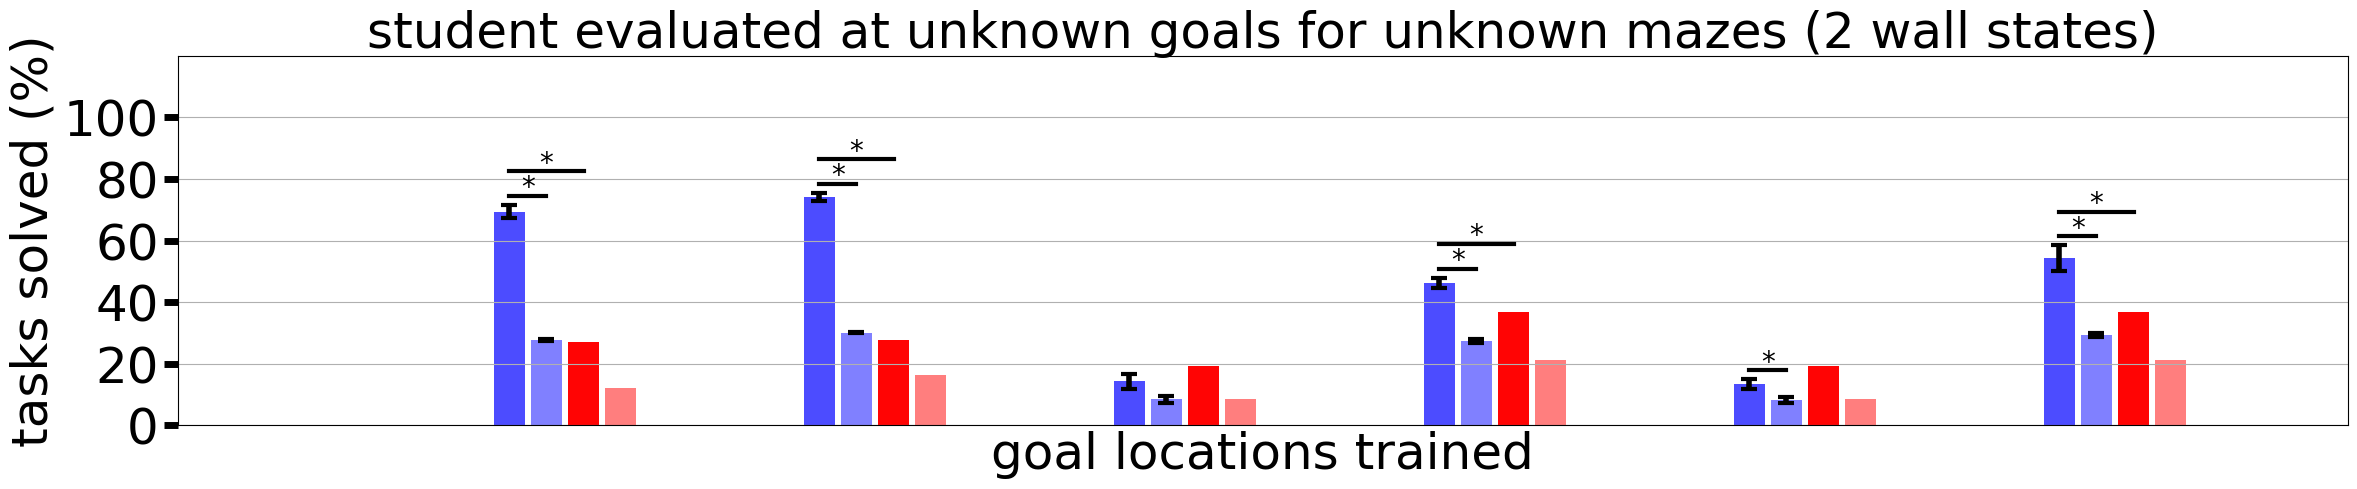

In [29]:
#@title PLOTS - Student performance plots (different goal locations trained) - large figure


#label dictionaries for all trained and unknown mazes respectively
label_dict_train=read_dict_from_pkl(file_loc+"teacher/label dictionaries/"+f"q_matrices_labelstraining_4x4.pkl")
label_dict_test=read_dict_from_pkl(file_loc+"teacher/label dictionaries/"+f"q_matrices_labelstest_4x4.pkl")

#plot settings
plt.rc('axes', labelsize=36)
plt.rc('xtick', labelsize=36)
plt.rc('ytick', labelsize=36)
plt.rc('axes', titlesize=36)
cmap=plt.get_cmap("bwr")

#a function to put p-value stars over bars
def add_pvalues(rects_x, rects_y, rect_width, pvalues, critical_p=0.05):
    '''
    rects_x - list of x-positions of the bars
    rects_y - list of bar heights (plus error bar)
    rect_width - rectangle width
    pvalues - list of pvalues (in order p01,p02,...,p0n,p12,...p1n,...,p n-1 n)
    critical_p - the critical p-value (if we are below that, we put a star in the plot)
    '''
    line_y = []
    y_offset_init=3
    y_offset_between=8
    ycounter=0 #counter for how many star bars we have already placed
    pcounter=0
    for i, [rect1_x, rect1_y] in enumerate(zip(rects_x, rects_y)):
        for j, [rect2_x, rect2_y] in enumerate(zip(rects_x, rects_y)):
            if i < j:
                pvalue = pvalues[pcounter]
                pcounter+=1
                star = ''
                if pvalue < critical_p:
                    star='*'
                if star:
                    x = (rect1_x  + rect2_x) / 2
                    y = max(rect1_y,rect2_y) + y_offset_init+ycounter*y_offset_between
                    line_y.append(y)
                    ax.annotate(star, xy=(x, y), fontsize=20,ha='center')
                    ax.plot([rect1_x , rect2_x],[y, y], lw=3, c='black')
                    ycounter+=1



for method in ["no_learning"]: #iterate over learning methods
    method_add_on="simple learning" if method=="simple_learning" else "no learning"
    for solving_rate_method in ["stepfactor"]:
        param= stepfactor_goalloc_plots if solving_rate_method=="stepfactor" else rdrate_goalloc_plots
        #potentially chuck out languages if the performances are bad
        chucked_indices=[[] for z in goal_groups_plots]
        for plot in [0,1,2,3]: #iterate over performance on known and unknown tasks

            goal_groups_adjusted=list(goal_groups_plots)
            if plot in [1,3] and 0 in goal_groups_plots:
                goal_groups_adjusted.remove(0)
            goal_groups_adjusted=np.array(goal_groups_adjusted)

            ldict=label_dict_train if plot in [0,1] else label_dict_test
            known_addon="trained" if plot in [0,1] else "unknown"
            avg_rates=[[],[],[],[]] if solving_rate_method=="stepfactor" else [[],[]] #average solving rates over all tasks
            sem_rates=[[],[],[],[]] if solving_rate_method=="stepfactor" else [[],[]] #standard error of the mean in the average solving rates over all tasks
            #for t-tests
            p01_list,p02_list,p03_list,p12_list,p13_list,p23_list=[],[],[],[],[],[]
            plists=[p01_list,p02_list,p03_list,p12_list,p13_list,p23_list]
            for m in goal_groups_adjusted:

                folder=folders_goalloc_plots[m]+"_known" if plot in [0,1] else folders_goalloc_plots[m]+"_unknown"

                rates=[[],[],[],[]] if solving_rate_method=="stepfactor" else [[],[]] #solving rates from all tasks listed for the three students (random walker is separate)

                for language in range(language_nr_goalloc_plots):
                    single_rates=[[],[],[],[]] if solving_rate_method=="stepfactor" else [[],[]]
                    #load the solving rates
                    for k,student in enumerate(["info","misinfo"]):
                        single_rates[k]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_{student}_{method}_{solving_rate_method}{param}.txt")
                    if solving_rate_method=="stepfactor":
                        single_rates[2]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_rdwalkersmart_{solving_rate_method}{param}.txt")
                        single_rates[3]=np.loadtxt(file_loc+"student/"+f"{folder}/{folder}_language{language}/"+f"solving_rates_rdwalker_{solving_rate_method}{param}.txt")

                    #filter out only the solving rates from tasks with trained goal locations
                    if plot==0 or plot==2:
                        for std in range(len(single_rates)):
                            newrates=[]
                            i=0
                            for j,label in ldict.items():
                                if label[2]!=student_init:
                                    if label[2] in train_goals_dict[m]:
                                        newrates+=[single_rates[std][i]]
                                    i+=1
                            single_rates[std]=newrates

                    #filter out only the solving rates from tasks with unknown goal locations
                    if plot==1 or plot==3:
                        for std in range(len(single_rates)):
                            newrates=[]
                            i=0
                            for j,label in ldict.items():
                                if label[2]!=student_init:
                                    if not(label[2] in train_goals_dict[m]):
                                        newrates+=[single_rates[std][i]]
                                    i+=1
                            single_rates[std]=newrates

                    #chuck the language out if the informed student is worse than the misinformed student!
                    if chuck_out:
                        if (plot==0 and (np.mean(single_rates[0])<np.mean(single_rates[3]) or np.mean(single_rates[0])<np.mean(single_rates[1]))) or (language in chucked_indices[m]):
                            if plot==0:
                                chucked_indices[m]+=[language]
                                print("Chucked out a language!")
                            continue

                    for index in range(len(single_rates)):
                        rates[index]+=[np.mean(single_rates[index])]

                print(f"goal location group {m}, goal finding rates for the single languages (in %)")
                print(f"info:            {np.round(100*np.array(rates[0]),1)} - average {round(100*np.mean(rates[0]),1)}")
                print(f"misinfo:         {np.round(100*np.array(rates[1]),1)} - average {round(100*np.mean(rates[1]),1)}")
                print(f"smart rd walker: {round(100*rates[2][0],1)}")
                print(f"rd walker:       {round(100*rates[3][0],1)}")

                #do t-tests (informed and misinformed with all others - for random walker comparison do 1-sided t-test, for student comparison do 2-sided t-test)
                #informed with misinformed
                p01=sp.stats.ttest_ind(rates[0], rates[1]).pvalue
                #informed with rd walkers
                p02=sp.stats.ttest_1samp(rates[0], rates[2][0]).pvalue
                p03=sp.stats.ttest_1samp(rates[0], rates[3][0]).pvalue
                #misinformed with rd walkers
                p12=sp.stats.ttest_1samp(rates[1], rates[2][0]).pvalue
                p13=sp.stats.ttest_1samp(rates[1], rates[3][0]).pvalue
                pvalues=[p01,p02,p03,p12,p13,1]
                #append p-values to list
                for i,plist in enumerate(plists):
                    plist+=[pvalues[i]]
                pinfo_array=np.round_(np.array([p01,p02,p03]),3)
                pmisinfo_array=np.round_(np.array([p12,p13]),3)
                print(f"p-values (t-test) for informed (vs misinfo, rd-smart, rd) are:    {pinfo_array}")
                print(f"p-values (t-test) for misinformed (vs rd-smart, rd) are: {pmisinfo_array}")
                print("")


                #add average solving rate and NOW STANDARD ERROR OF THE MEAN
                for j,rates_student in enumerate(rates):
                    avg_rates[j]+=[100*np.mean(rates_student)]
                    #std_rates[j]+=[100*np.std(rates_student)]
                    sem_rates[j]+=[100*np.std(rates_student, ddof=1)/mt.sqrt(language_nr_goalloc_plots)]

            #plot
            fig,ax=plt.subplots(figsize=(28,4.8))
            plt.tick_params(bottom=False, labelbottom=False) #remove ticks and labels from y axis
            plt.grid(visible=True, axis="y")
            plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)
            axt = plt.gca()
            axt.tick_params(width=5, length=10)
            labels=["informed student","misinformed student","smart random walker","random walker"] if solving_rate_method=="stepfactor" else ["informed student","misinformed student"]
            colors=[cmap(0.15),cmap(0.25),cmap(0.99),cmap(0.75)] if solving_rate_method=="stepfactor" else [cmap(0.15),cmap(0.25)]
            bar_positions= [goal_groups_adjusted-0.2, goal_groups_adjusted+0.2] if solving_rate_method=="rate" else [goal_groups_adjusted-0.18, goal_groups_adjusted-0.06,goal_groups_adjusted+0.06,goal_groups_adjusted+0.18]
            for rates,sem,label,color,bar_pos in zip(avg_rates, sem_rates, labels, colors, bar_positions):
                rates,sem=np.array(rates),np.array(sem)
                width =0.1 if solving_rate_method=="stepfactor" else 0.35
                ax.bar(bar_pos,rates,label=label, width=width, color=color)
                if label in ["informed student","misinformed student"]:
                    ax.errorbar(bar_pos,rates,yerr=sem, capsize=6,elinewidth=4,capthick=3,color="black", fmt="none")

            trange=range(7) if plot in [0,2] else range(6)
            rect_width =0.1 if solving_rate_method=="stepfactor" else 0.35
            for t in trange:
                rects_x=[t-0.18,t-0.06,t+0.06,t+0.18] if plot in [0,2] else [t+1-0.18,t+1-0.06,t+1+0.06,t+1+0.18]
                rects_y=[avg_rates[i][t]+sem_rates[i][t] for i in range(4)]
                #only show stars if informed is better, not other way around!
                p01val=p01_list[t] if avg_rates[0][t]>avg_rates[1][t] else 1
                p02val=p02_list[t] if avg_rates[0][t]>avg_rates[2][t] else 1
                p03val=p03_list[t] if avg_rates[0][t]>avg_rates[3][t] else 1
                p12val=p12_list[t] if avg_rates[1][t]>avg_rates[2][t] else 1
                p13val=p13_list[t] if avg_rates[1][t]>avg_rates[3][t] else 1
                p_values=[p01val, p02val,1,1,1,1]
                add_pvalues(rects_x,rects_y,rect_width,p_values)


            ax.set_ylim(0,120)
            ax.set_ylabel("tasks solved (%)")
            if plot==0:
                plt.title(f"student evaluated at trained goals for trained mazes (0 and 1 wall states)")
            elif plot==1:
                plt.title(f"student evaluated at unknown goals for trained mazes (0 and 1 wall states)")
            elif plot==2:
                plt.title(f"student evaluated at trained goals for unknown mazes (2 wall states)")
            elif plot==3:
                plt.title(f"student evaluated at unknown goals for unknown mazes (2 wall states)")
            ax.set_xlim(-0.25,len(goal_groups_plots)-0.25)
            ax.set_yticks([0,20,40,60,80,100])


            ax.set_xlabel(r"goal locations trained")
            #plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=25) #put legend outside the plot so that no lines are covered!
            if save_goalloc_plots:
                plt.savefig(file_loc+"student/"+f"{folders_goalloc_plots[0]}"+f"/solvingrates_{method}_{solving_rate_method}_zeta5_factor1_plot{plot}.png", bbox_inches='tight', format="png")
                plt.savefig(file_loc+"student/"+f"{folders_goalloc_plots[0]}"+f"/solvingrates_{method}_{solving_rate_method}_zeta5_factor1_plot{plot}.svg", format="svg")
            plt.show()




Analyzing the language nonlinear_noregularization_language0

Doing PCA of teacher Q-matrices

We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 551.98, var. between 1894.74, beta 0.774, F 47.81
Goal groups: var. within 1828.77, var. between 617.95, beta 0.253, F 4.71



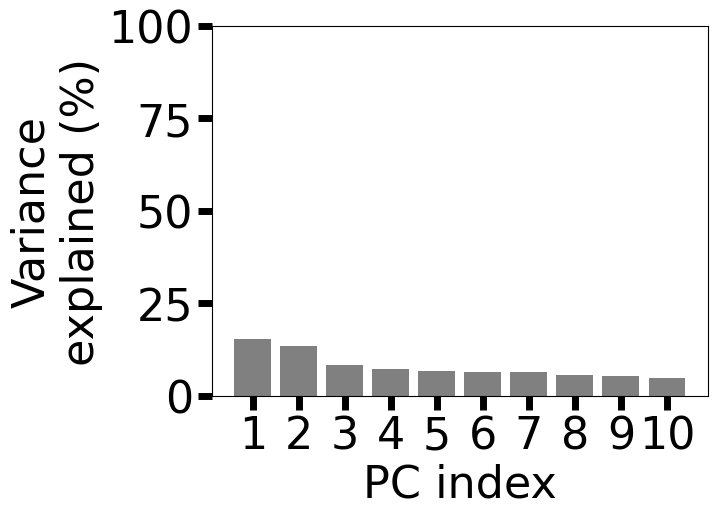

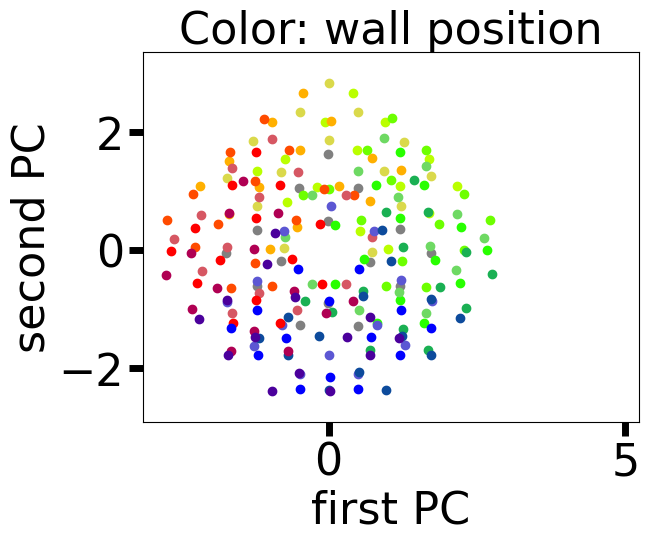

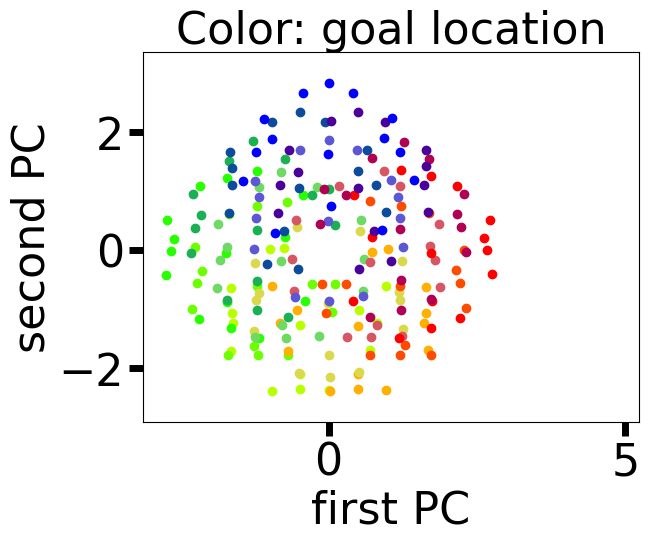

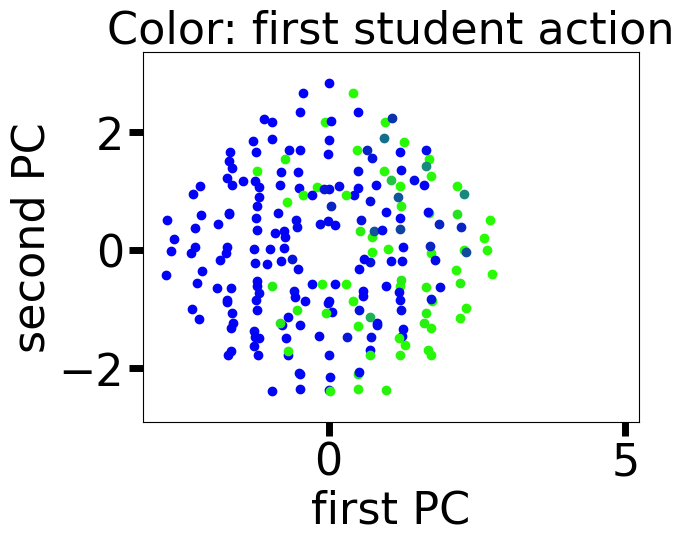





Doing PCA of student Q-matrices

We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 11876.34, var. between 1167.2, beta 0.089, F 1.37
Goal groups: var. within 2708.09, var. between 10335.46, beta 0.792, F 53.16



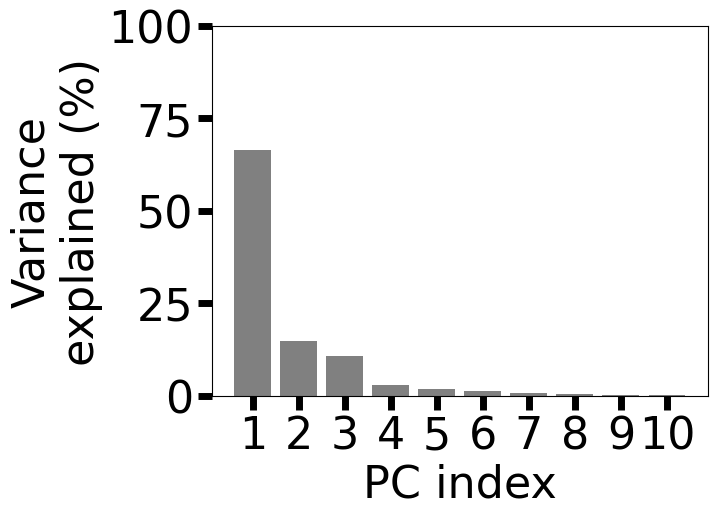

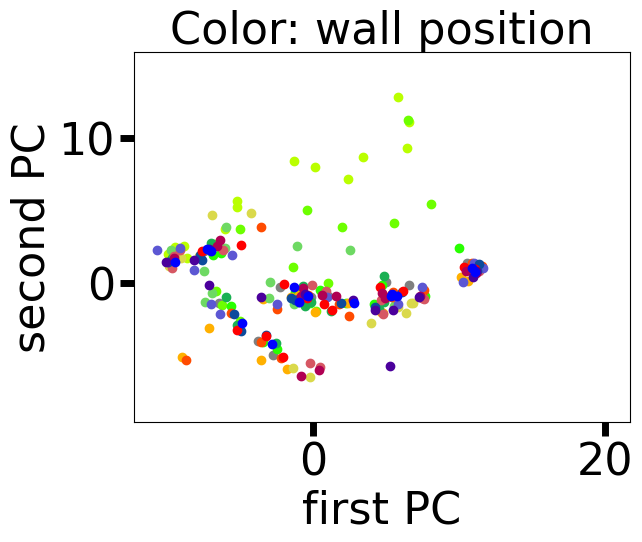

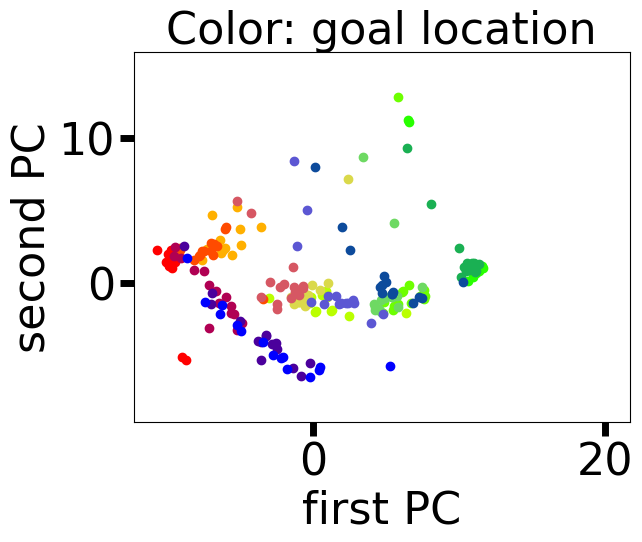

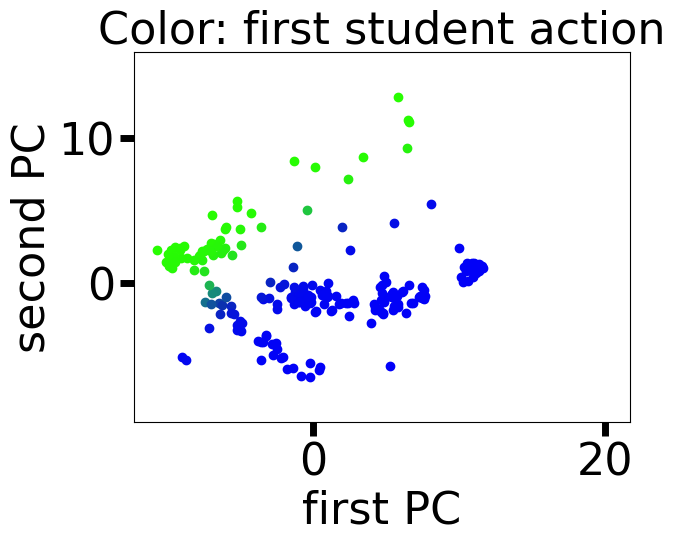





Doing PCA of student P-matrices

We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 539.47, var. between 49.01, beta 0.083, F 1.27
Goal groups: var. within 131.99, var. between 456.5, beta 0.776, F 48.17



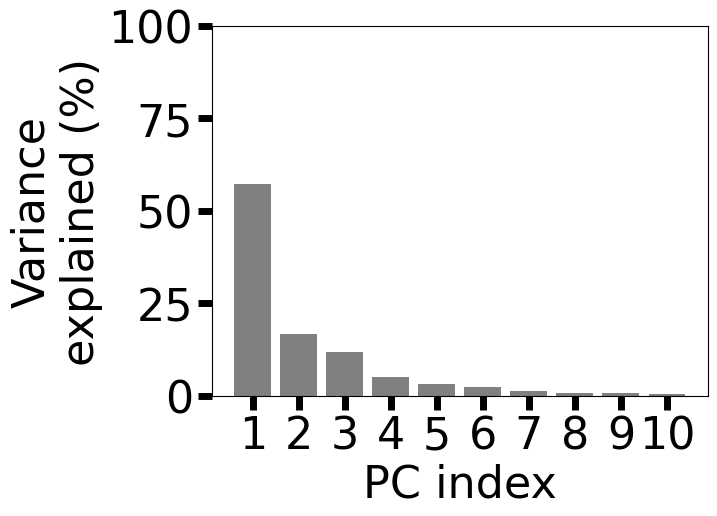

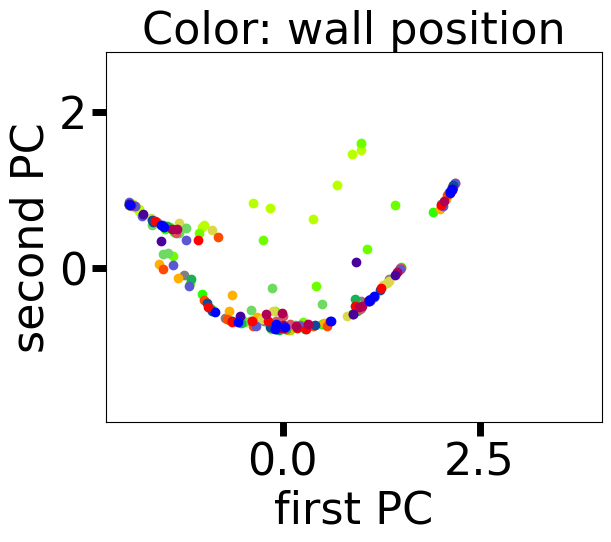

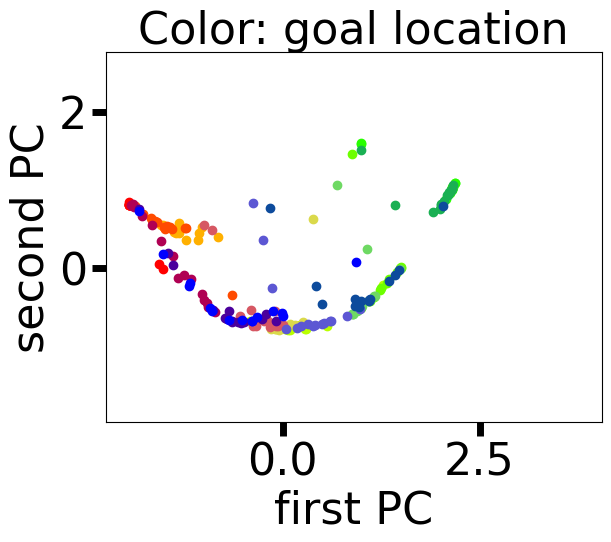

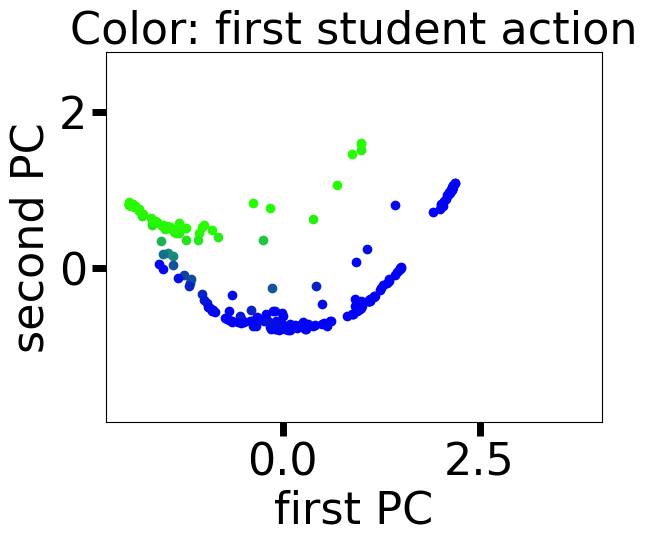





Doing PCA of messages from student Q-matrices

We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 10.25, var. between 1.38, beta 0.118, F 1.87
Goal groups: var. within 4.49, var. between 7.14, beta 0.614, F 22.17



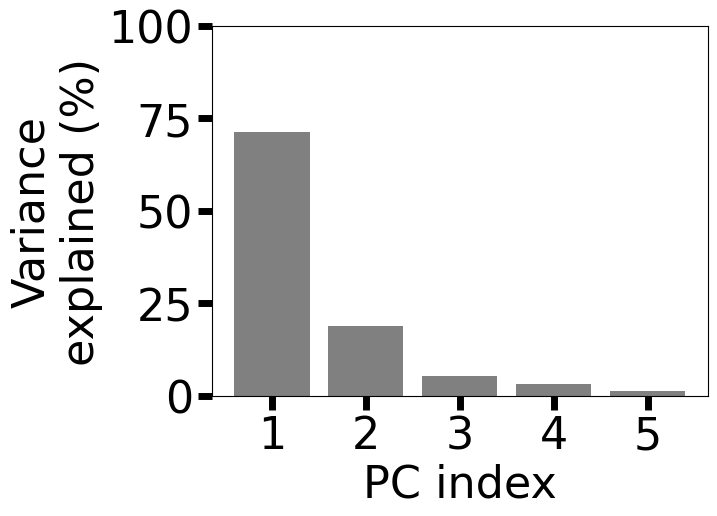

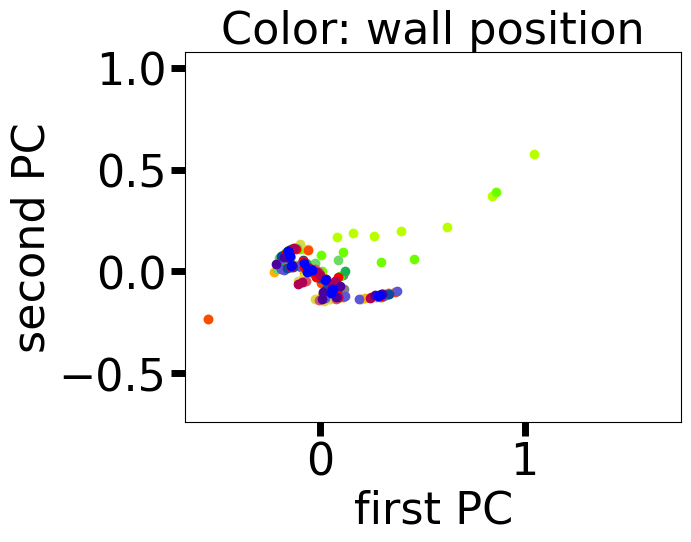

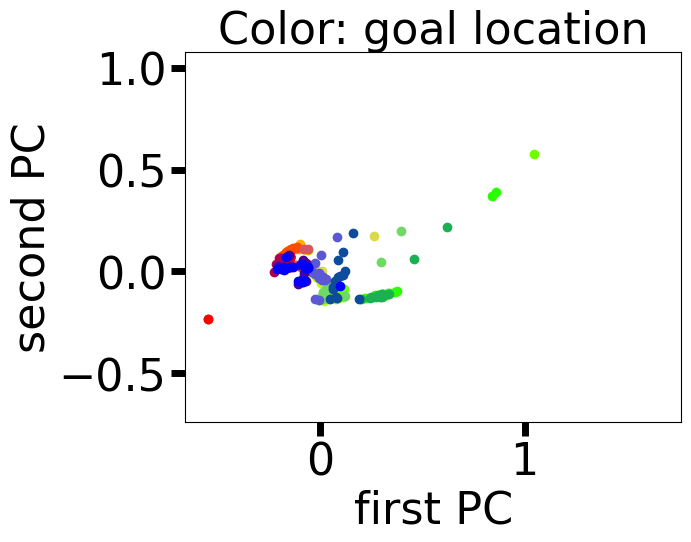

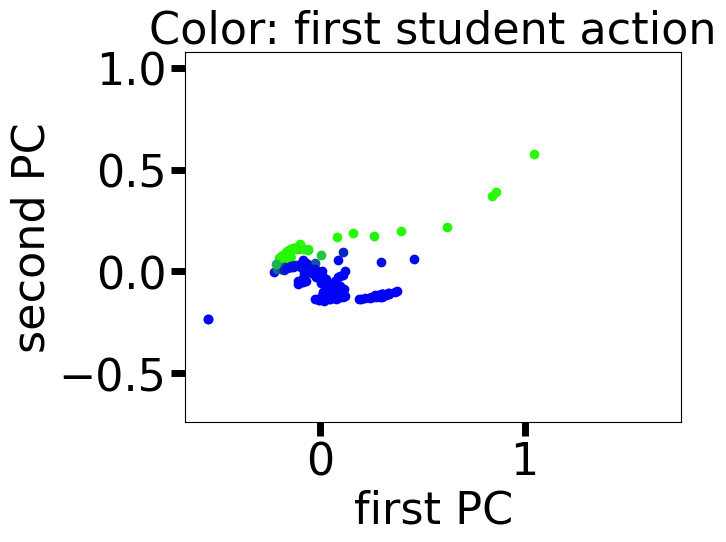





Doing PCA of messages from student P-matrices

We include 210 messages in the 15 groups in the variance analysis with world groupings
We include 210 messages in the 15 groups in the variance analysis with goal groupings
World groups: var. within 0.21, var. between 0.05, beta 0.188, F 3.23
Goal groups: var. within 0.11, var. between 0.16, beta 0.594, F 20.4



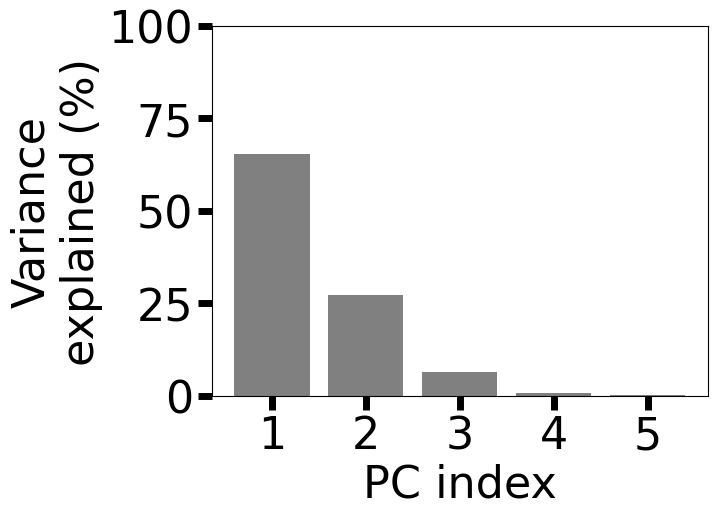

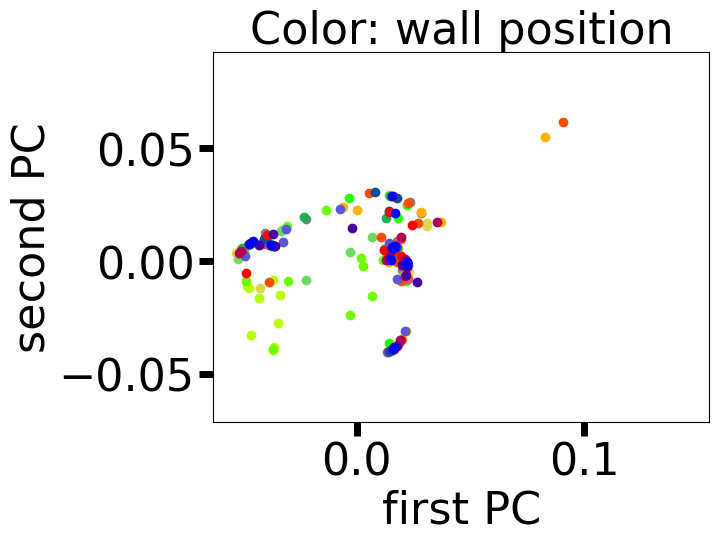

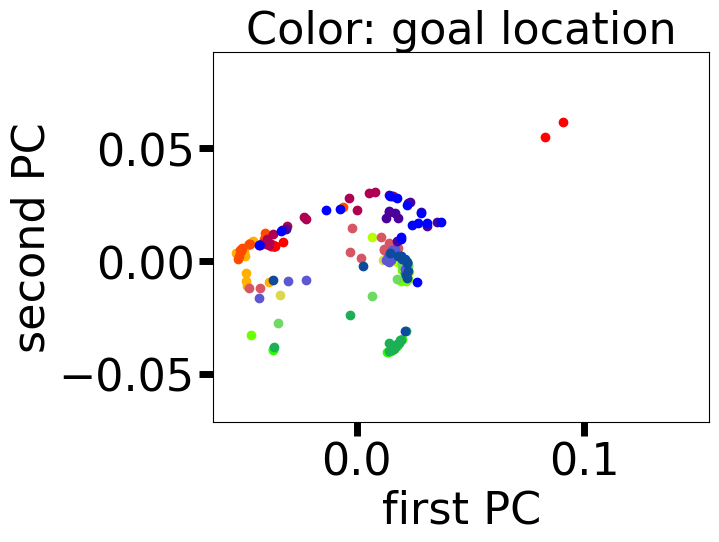

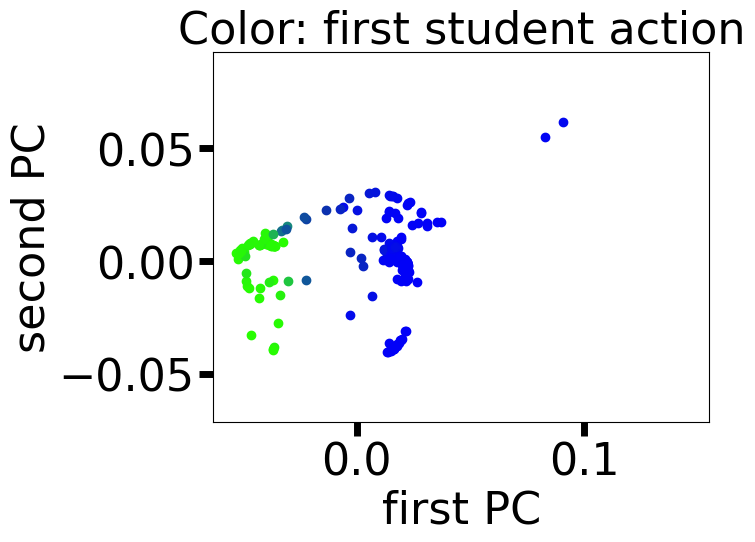

In [30]:
#@title PLOTS - Closing the loop
save_closingloop_plots=False
language_code_closingloop="nonlinear_noregularization_language0"


cmap = ColorMap2DZiegler(range_x=(-0.5-(grid_dim/2-1), 0.5+(grid_dim/2-1)), range_y=(-0.5-(grid_dim/2-1), 0.5+(grid_dim/2-1))) #2d color map for goal locations
cmap2=plt.get_cmap("bwr")
softy=nn.Softmax(dim=0)
label_list=[[i,j,k] for [i,j,k,l] in label_dict.values()]
pca1, pca2=PCA(grid_dim**2*4), PCA(K) #q matrix PCA and message PCA
cval=(grid_dim-1)/2 #central value for reference if we use color by goal location or wall position
state_tensors=get_state_tensors(1) #for autoencoder forward function

#create color dictionary for goal and wall state positions
color_dict={0:"grey"}
for s in range(1,grid_dim**2):
    #Scatterplot of the q-matrices, PC1 vs PC2
    x,y=s%grid_dim, mt.floor(s/grid_dim)
    color_dict[s]=cmap(x-cval,y-cval)/255

#plot settings
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)
plt.rc('axes', titlesize=32)
plt.rcParams['svg.fonttype']='none' #"to make later editing of figures easier" (Carlos)


print("")
print(f"Analyzing the language {language_code_closingloop}")
print("")
if not os.path.exists(file_loc+f"closing the loop/{language_code_closingloop}"):
    os.mkdir(file_loc+f"closing the loop/{language_code_closingloop}")

#load the language
autoencoder = ConvAutoEncoder(data_shape, K, closingloop_nonlinear_ae, closingloop_nonlinear_std).to(device)
autoencoder.load_state_dict(torch.load(file_loc+"autoencoder/autoencoder network parameters/"+f"params_autoenc{language_code_closingloop}.pt"))
autoencoder.eval()

#create the (regular) messages
message_dict={}
for task_index,q_matrix in enumerate(q_matrix_dict.values()):
    q_matrix=torch.unsqueeze(q_matrix,0) #need this because the autoencoder always expects batches of inputs!
    message=autoencoder.encode(q_matrix)[0]
    message_dict[task_index]=message

#Data analysis
message_list=[mssg.detach().cpu().numpy() for i,mssg in message_dict.items()]
#1.PCA of the original Q-matrices
q_matrix_list=np.array([torch.flatten(Q).detach().numpy() for Q in q_matrix_dict.values()])
#2.PCA of the student Q-matrices
q_matrixstd_list=np.array([torch.flatten(autoencoder.student(torch.tensor([m]),state_tensors)[0]).detach().numpy() for m in message_list])
qmatrix_dict_studentq={k:autoencoder.student(torch.tensor([m]),state_tensors)[0] for k,m in enumerate(message_list)}
write_dict_into_pkl(qmatrix_dict_studentq,file_loc+f"closing the loop/{language_code_closingloop}/studentQmatrices.pkl") #save the Q-matrices belonging to this language
#3.PCA of the student probability matrices
p_matrixstd_list=np.array([torch.flatten(softy(autoencoder.student(torch.tensor([m]),state_tensors)[0])).detach().numpy() for m in message_list])
qmatrix_dict_studentp={k:softy(autoencoder.student(torch.tensor([m]),state_tensors)[0]) for k,m in enumerate(message_list)}
#4.PCA of messages from student Q-matrices
mstd_fromq_list=np.array([autoencoder.encode(torch.unsqueeze(autoencoder.student(torch.tensor([m]),state_tensors)[0],0))[0].detach().numpy() for m in message_list])
message_dict_studentq={k:m for k,m in enumerate(mstd_fromq_list)}
#5.PCA of messages from student probability matrices
mstd_fromp_list=np.array([autoencoder.encode(torch.unsqueeze(softy(autoencoder.student(torch.tensor([m]),state_tensors)[0]),0))[0].detach().numpy() for m in message_list])
message_dict_studentp={k:m for k,m in enumerate(mstd_fromp_list)}


datalist=[q_matrix_list, q_matrixstd_list, p_matrixstd_list, mstd_fromq_list, mstd_fromp_list]
savelist=["teacherQ", "studentQ", "studentP", "message_studentQ", "message_studentP"]
printlist=["teacher Q-matrices", "student Q-matrices", "student P-matrices", "messages from student Q-matrices", "messages from student P-matrices"]
for t, [data, savedata,printdata] in enumerate(zip(datalist,savelist,printlist)):
    print(f"Doing PCA of {printdata}")
    print("")

    #first do variance analysis
    variance_analyzer(autoencoder,data, label_list, plot_worlds)

    pca=pca1 if t<3 else pca2 #different dimensionalities for Q-matrix space and message space require different PCAs
    data_pca=pca.fit_transform(data)

    #PLOT VARIANCE EXPLAINED BY PC COMPONENT
    fig,ax = plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    var_arr=np.round_(pca.explained_variance_ratio_*100,2)
    ax.set_ylim(0,100)
    if pca==pca1:
        plt.bar(range(11)[1:],var_arr[:10], color="gray") #for each message dimension have one PC
        plt.xticks(range(11)[1:])
    else:
        plt.bar(range(K+1)[1:],var_arr[:K], color="gray") #for each message dimension have one PC
        plt.xticks(range(K+1)[1:])

    plt.xlabel(f"PC index")
    plt.ylabel(r"Variance" "\n" r"explained (%)")
    if save_closingloop_plots:
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_varexplained.png", format="png")
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_varexplained.svg", format="svg")


    #PCA PLOT - COLOR BY WORLD (WALL PLACEMENT)
    fig,ax = plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    for world in range(16):
        world_indices=[k for k,label in enumerate(label_list) if label[0]==world]
        ax.scatter(data_pca[world_indices,0],data_pca[world_indices,1],label=f"world {world}", color=color_dict[world])
    ax.set_xlabel("first PC")
    ax.set_ylabel("second PC")
    xdatamin,xdatamax=min(data_pca[:,0]), max(data_pca[:,0])
    ydatamin,ydatamax=min(data_pca[:,1]), max(data_pca[:,1])
    ymean=(ydatamax+ydatamin)/2
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ax.set_xlim(xmin,xmax+(xmax-xmin)/3)
    ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    plt.title("Color: wall position")
    if save_closingloop_plots:
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_colorworld.png", format="png")
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_colorworld.svg", format="svg")


    #PCA PLOT - COLOR BY GOAL LOCATION
    fig,ax=plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    for goal in range(16):
        goal_indices=[k for k,label in enumerate(label_list) if label[2]==goal]
        ax.scatter(data_pca[goal_indices,0],data_pca[goal_indices,1],label=f"goal {goal}", color=color_dict[goal])
    ax.set_xlabel("first PC")
    ax.set_ylabel("second PC")
    xdatamin,xdatamax=min(data_pca[:,0]), max(data_pca[:,0])
    ydatamin,ydatamax=min(data_pca[:,1]), max(data_pca[:,1])
    ymean=(ydatamax+ydatamin)/2
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ax.set_xlim(xmin,xmax+(xmax-xmin)/3)
    ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    plt.title("Color: goal location")
    if save_closingloop_plots:
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_colorgoal.png", format="png")
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_colorgoal.svg", format="svg")


    #PCA PLOT - COLOR BY INITIAL ACTION
    fig,ax=plt.subplots()
    ax.xaxis.set_tick_params(width=5, length=10)
    ax.yaxis.set_tick_params(width=5, length=10)
    softy=nn.Softmax(dim=0)
    for l,message in enumerate(message_list):
        state_tensors=get_state_tensors(1)
        Q=autoencoder.student(torch.tensor([message]), state_tensors)[0]
        probas=softy(Q[:,0%grid_dim,mt.floor(0/grid_dim)]).detach().cpu().numpy()
        #combine the four probabilities into a 2-dimensional vector using the four corners of a square with four different colours
        extr=0.5+grid_dim/2-1
        comb2d=probas[0]*np.array([extr,extr])+probas[1]*np.array([extr,-extr])+probas[2]*np.array([-extr,-extr])+probas[3]*np.array([-extr,extr])
        ax.scatter(data_pca[l,0],data_pca[l,1],color=cmap(comb2d[0],comb2d[1])/255)

    ax.set_xlabel("first PC")
    ax.set_ylabel("second PC")
    xdatamin,xdatamax=min(data_pca[:,0]), max(data_pca[:,0])
    ydatamin,ydatamax=min(data_pca[:,1]), max(data_pca[:,1])
    ymean=(ydatamax+ydatamin)/2
    xmin, xmax = xdatamin - 0.07*(xdatamax-xdatamin), xdatamax + 0.07*(xdatamax-xdatamin) #x axis limits a bit larger than data range to not cut points in the middle
    ax.set_xlim(xmin,xmax+(xmax-xmin)/3)
    ax.set_ylim(ymean-1/2*(xmax-xmin), ymean+1/2*(xmax-xmin)) #manually set equal aspect ratio, it was the only way that worked..
    plt.title("Color: first student action")
    if save_closingloop_plots:
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_coloraction.png", format="png")
        plt.savefig(file_loc+f"closing the loop/{language_code_closingloop}/{savedata}_coloraction.svg", format="svg")

    plt.show()
    print("\n"*3)
